In [1]:
%matplotlib inline
import sys
sys.path.append("../lib/")
import os
import string
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.tree import plot_tree
import seaborn as sns
import graphviz
import shap

from raman_lib.visualization import (plot_spectra_peaks, 
                                     plot_qc_summary, 
                                     plot_confidence_scores, 
                                     plot_coefs, 
                                     plot_confusion_matrix, 
                                     plot_roc_curve, 
                                     plot_validation_curve,
                                     plot_roc_comparison,
                                     boxplot_comparison)

# Setup

In [2]:
dataset = "L_540_2022_CERB"
#dataset = "pro"
#dataset = "cyanos"


In [3]:
results_path = Path("../results/") / dataset
img_path = Path("../img/") / dataset

img_path.mkdir(parents=True, exist_ok=True)

In [4]:
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))

y, y_key = pd.factorize(data.label)

In [5]:
rocs = {}
aucs = {}
p_vals = {}
accs = {}
f1_scores = {}
fit_times = {}
predict_times = {}

In [6]:
plt.style.use("seaborn-paper")
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["figure.dpi"] = 200

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10

# Quality Control

In [7]:
qc_results = pd.read_csv(results_path / (dataset + "_qc_scores.csv"))

qc_results.describe()

Median Height      N Peaks
count    1501.000000  1501.000000
mean      691.025173    11.225183
std       711.919141     6.923481
min         0.000000     0.000000
25%       250.865296     5.000000
50%       469.992938    12.000000
75%       907.834316    16.000000
max      8645.468667    30.000000

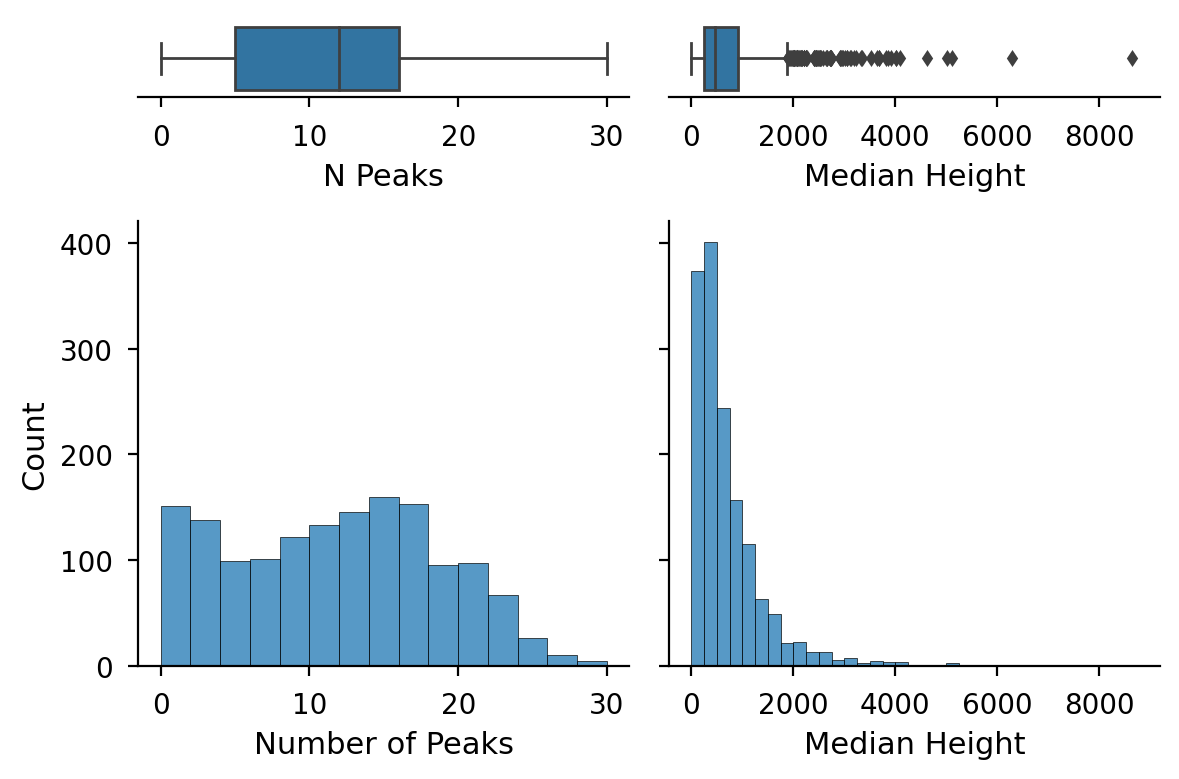

In [8]:
fig, ((ax_box1, ax_box2), (ax_hist1, ax_hist2)) = plt.subplots(
    2, 2, sharex="col", sharey="row", gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 4))

sns.boxplot(x=qc_results.iloc[:,1], ax=ax_box1, fliersize=3, linewidth=1)
sns.boxplot(x=qc_results.iloc[:,0], ax=ax_box2, fliersize=3, linewidth=1)
sns.histplot(qc_results.iloc[:,1], ax=ax_hist1, binrange=None, binwidth=2)
sns.histplot(qc_results.iloc[:,0], ax=ax_hist2, binrange=None, binwidth=250)

ax_box1.set(yticks=[])
ax_box2.set(yticks=[])
sns.despine(ax=ax_hist1)
sns.despine(ax=ax_hist2)
sns.despine(ax=ax_box1, left=True)
sns.despine(ax=ax_box2, left=True)

ax_hist1.set_xlabel("Number of Peaks")
ax_hist2.set_xlabel(qc_results.columns[0])

#ax_hist1.set_ylim([None, ymax_peaks])
#ax_hist2.set_ylim([None, ymax_score])

ax_box1.tick_params(axis="x", labelbottom=True)
ax_box2.tick_params(axis="x", labelbottom=True)

fig.tight_layout()

# Dimensionality Reduction
## LDA
### Overview

In [11]:
ct_df[f1_scores]

NameError: name 'ct_df' is not defined

In [12]:
current_path = results_path / "lda_dim_reduction/lda/"
name = "LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

AttributeError: 'DataFrame' object has no attribute 'test_f1'

### Confidence scores by class

Text(0, 0.5, 'Confidence score (-)')

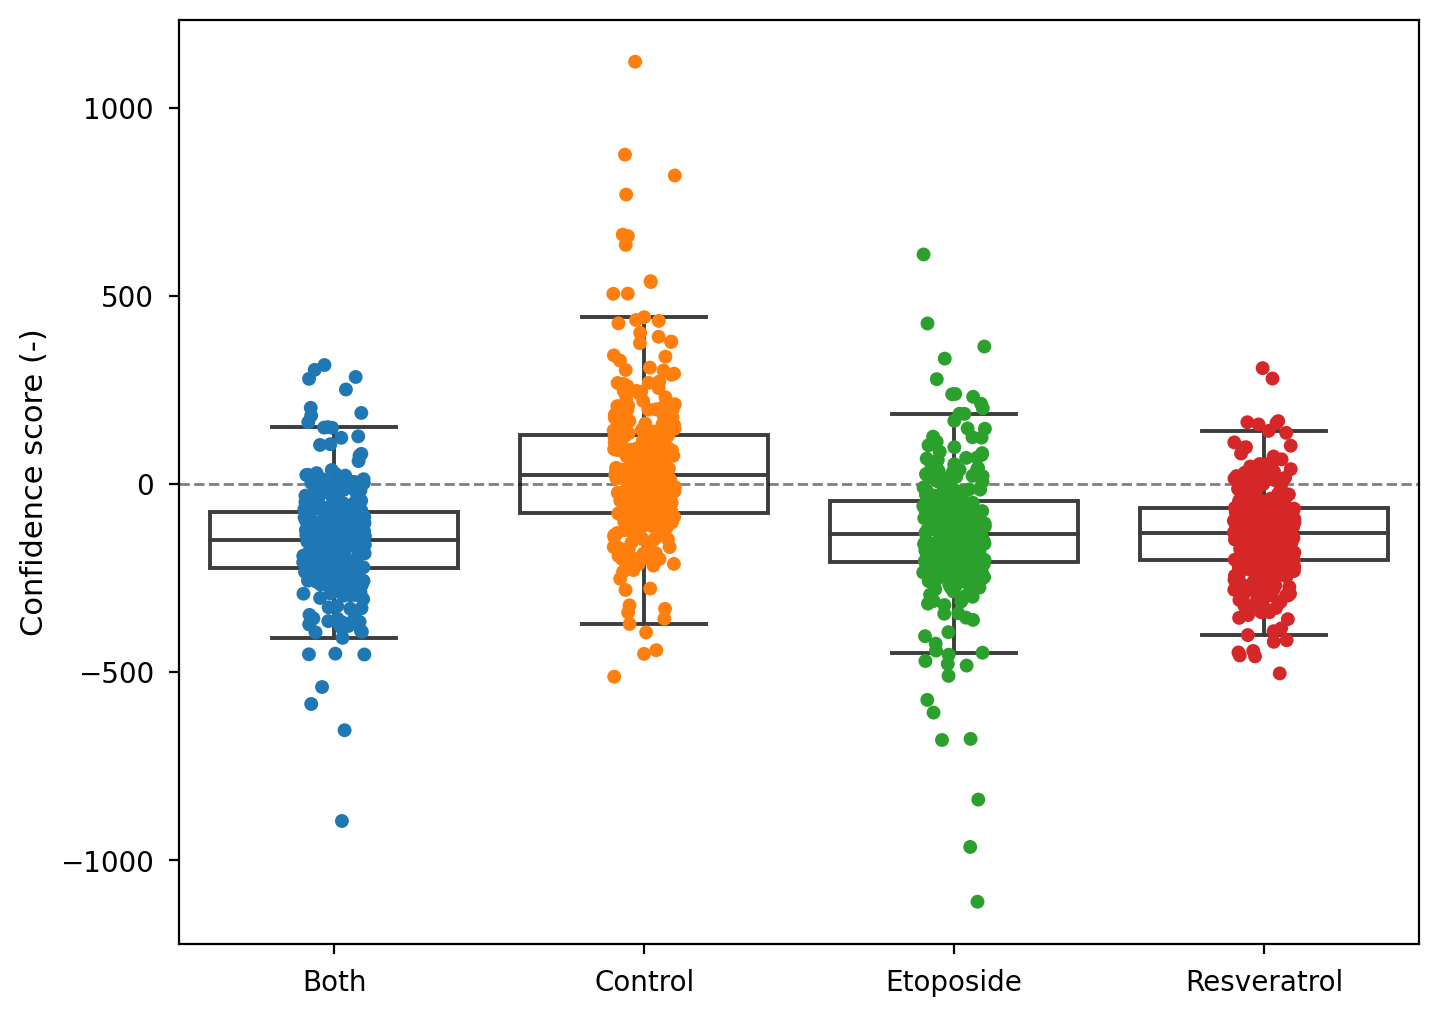

In [13]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.5)
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.set_ylabel("Confidence score (-)")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

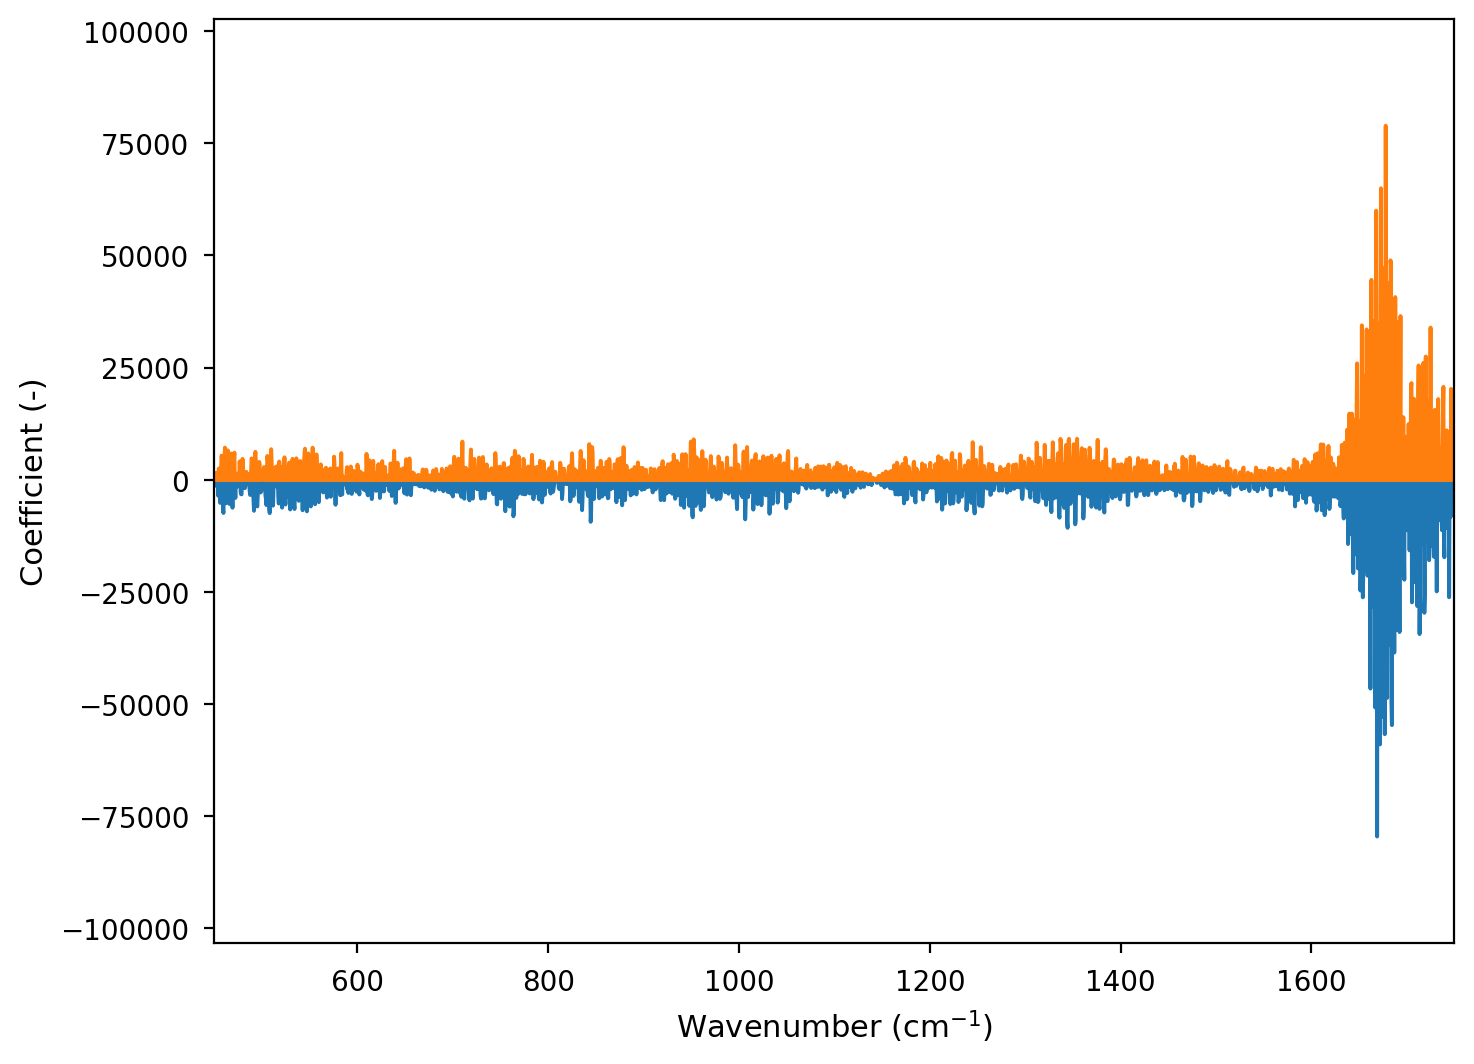

In [14]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax)

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)

### Confusion Matrix

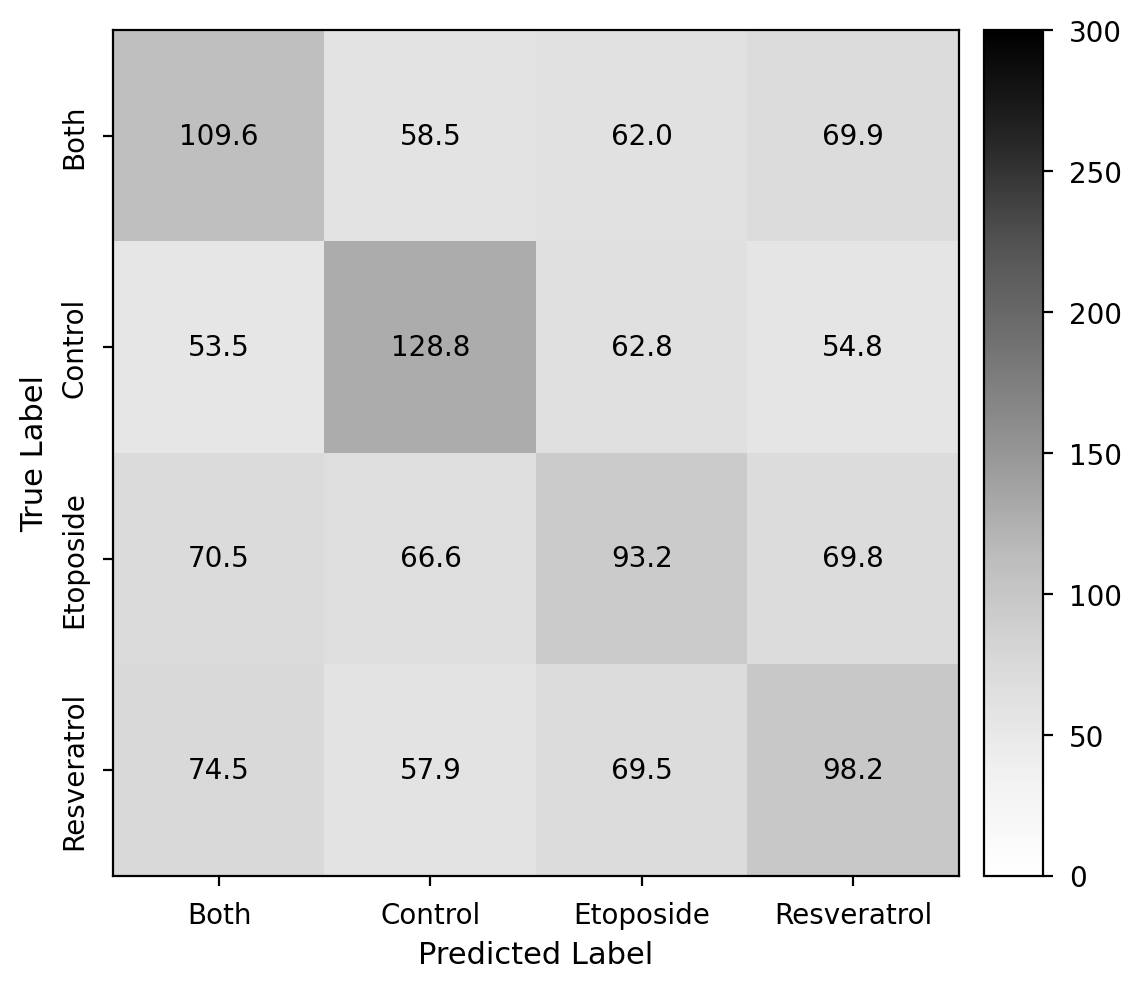

In [15]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

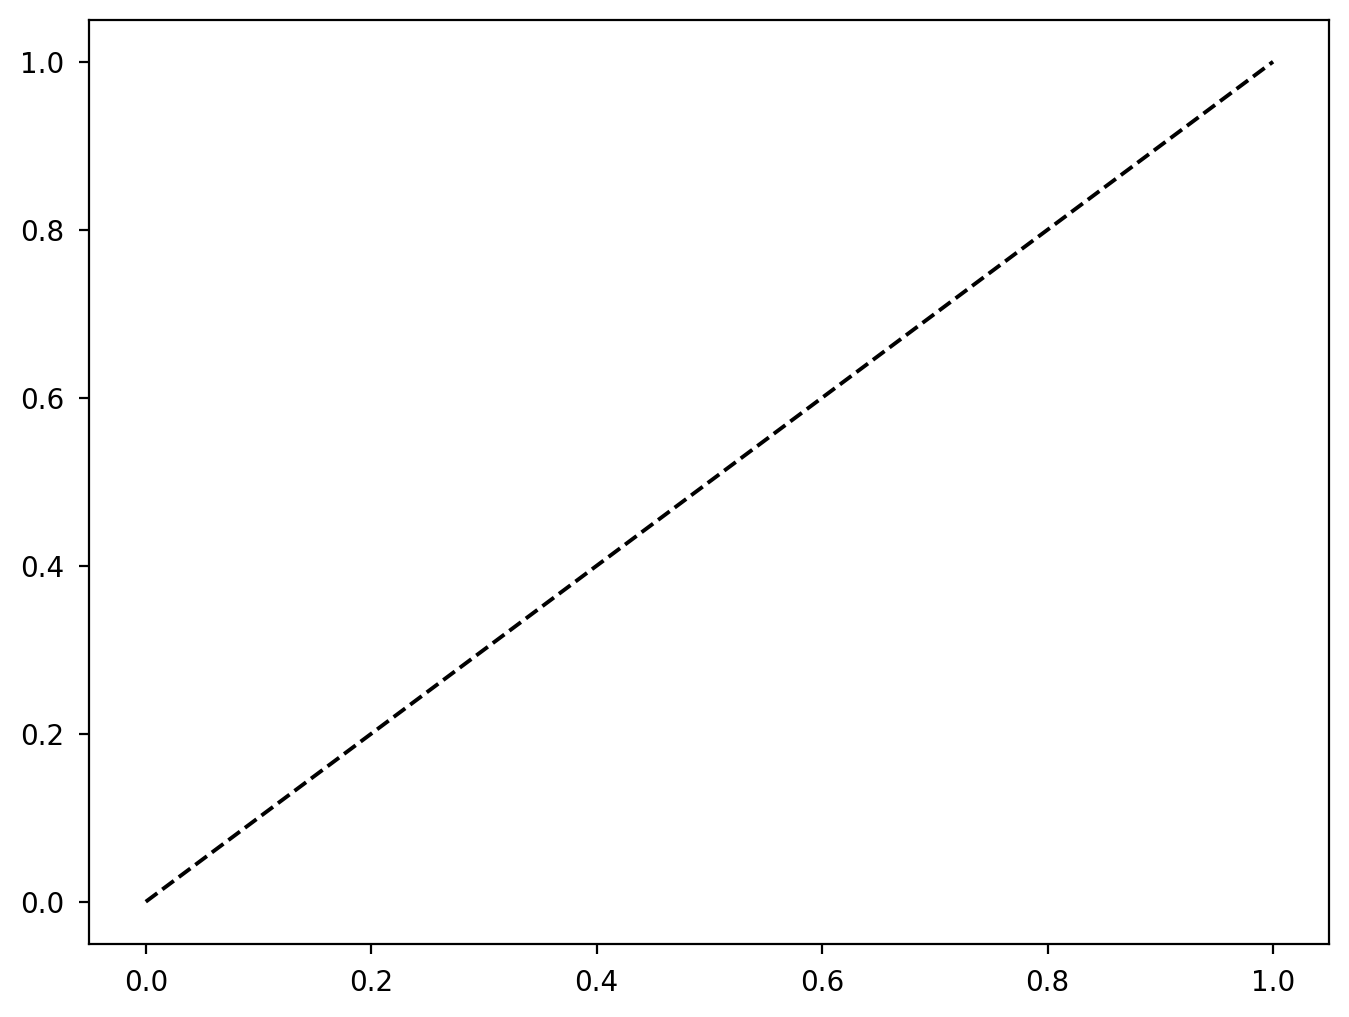

In [16]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

rocs[name] = roc
aucs[name] = auc

## PCA-LDA
### Overview

In [19]:
current_path = results_path / "lda_dim_reduction/pca_lda/"
name = "PCA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_accuracy  test_accuracy  fit_time  predict_time       p_value
count        3.000000       3.000000  3.000000      3.000000  3.000000e+00
mean         0.658482       0.596726  1.118630      0.013545  3.066696e-61
std          0.015678       0.005208  0.107045      0.001748  5.304964e-61
min          0.643601       0.591518  1.055017      0.011693  3.393785e-64
25%          0.650298       0.594122  1.056837      0.012734  3.873631e-64
50%          0.656994       0.596726  1.058656      0.013776  4.353478e-64
75%          0.665923       0.599330  1.150436      0.014471  4.598348e-61
max          0.674851       0.601935  1.242217      0.015167  9.192342e-61

### Validation Curve

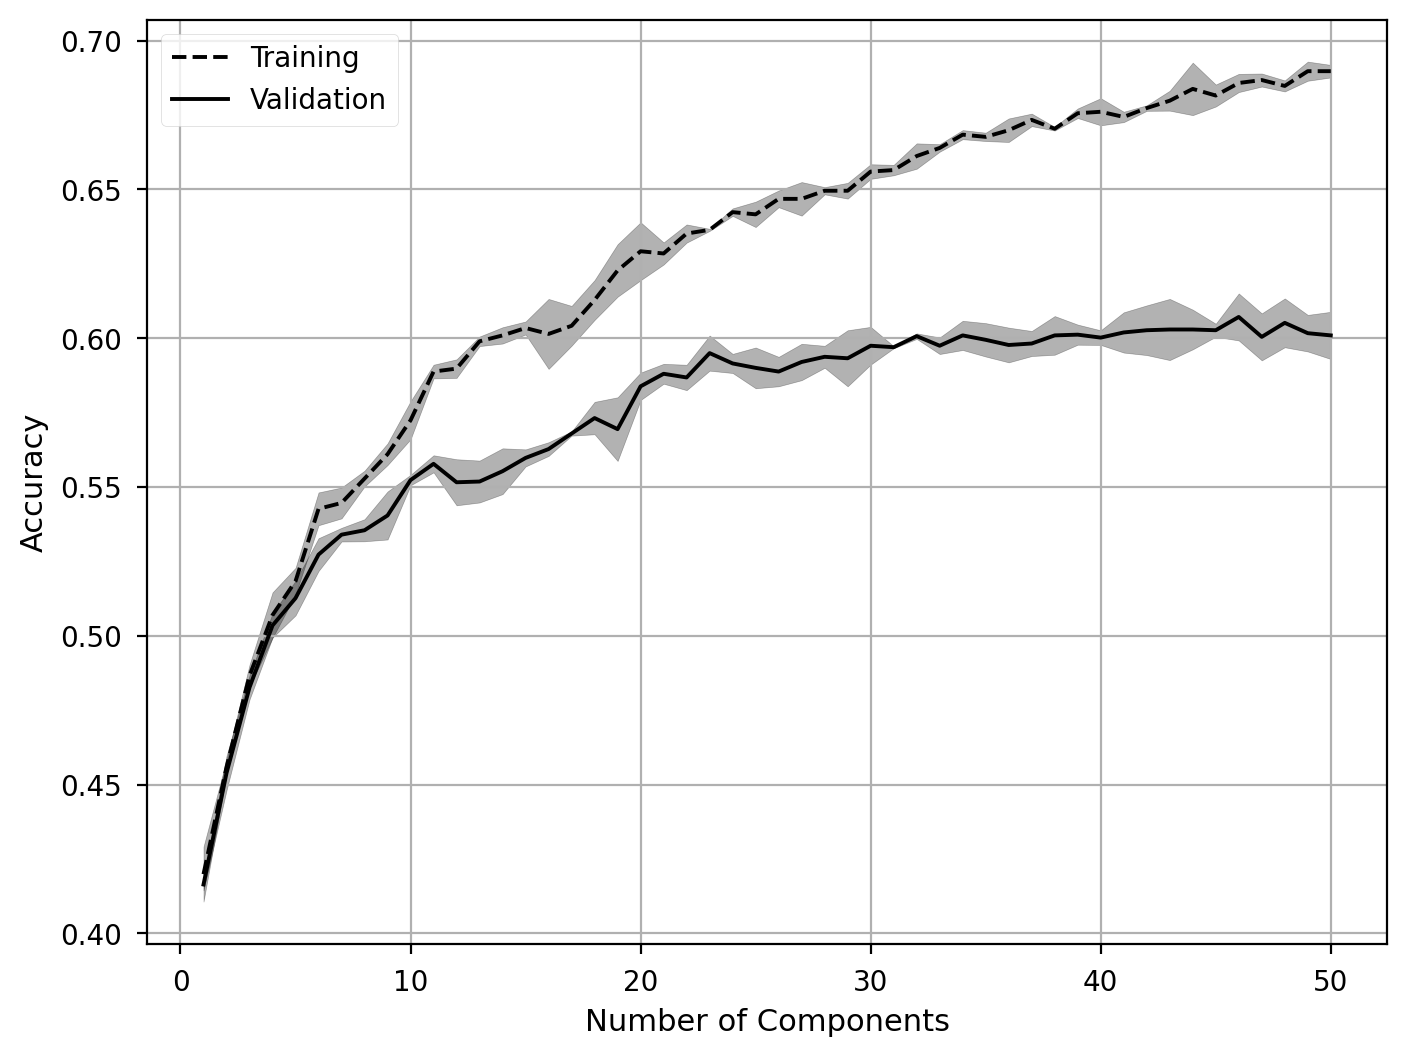

In [20]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Number of Components")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

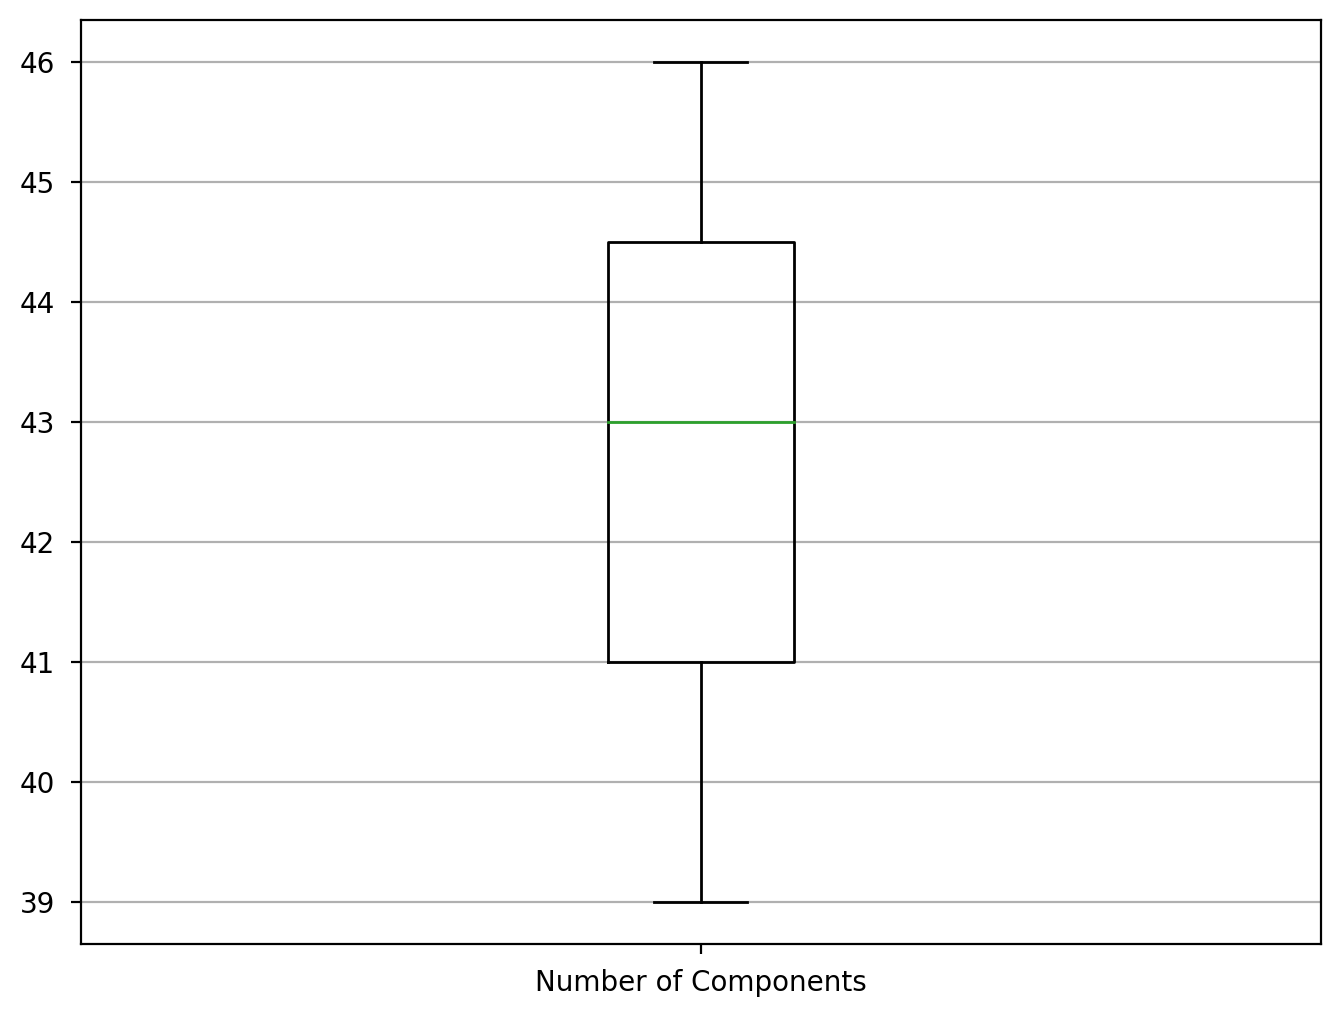

In [21]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Number of Components"])
ax.grid(axis="y")

### Confidence scores by class

ValueError: Grouper and axis must be same length

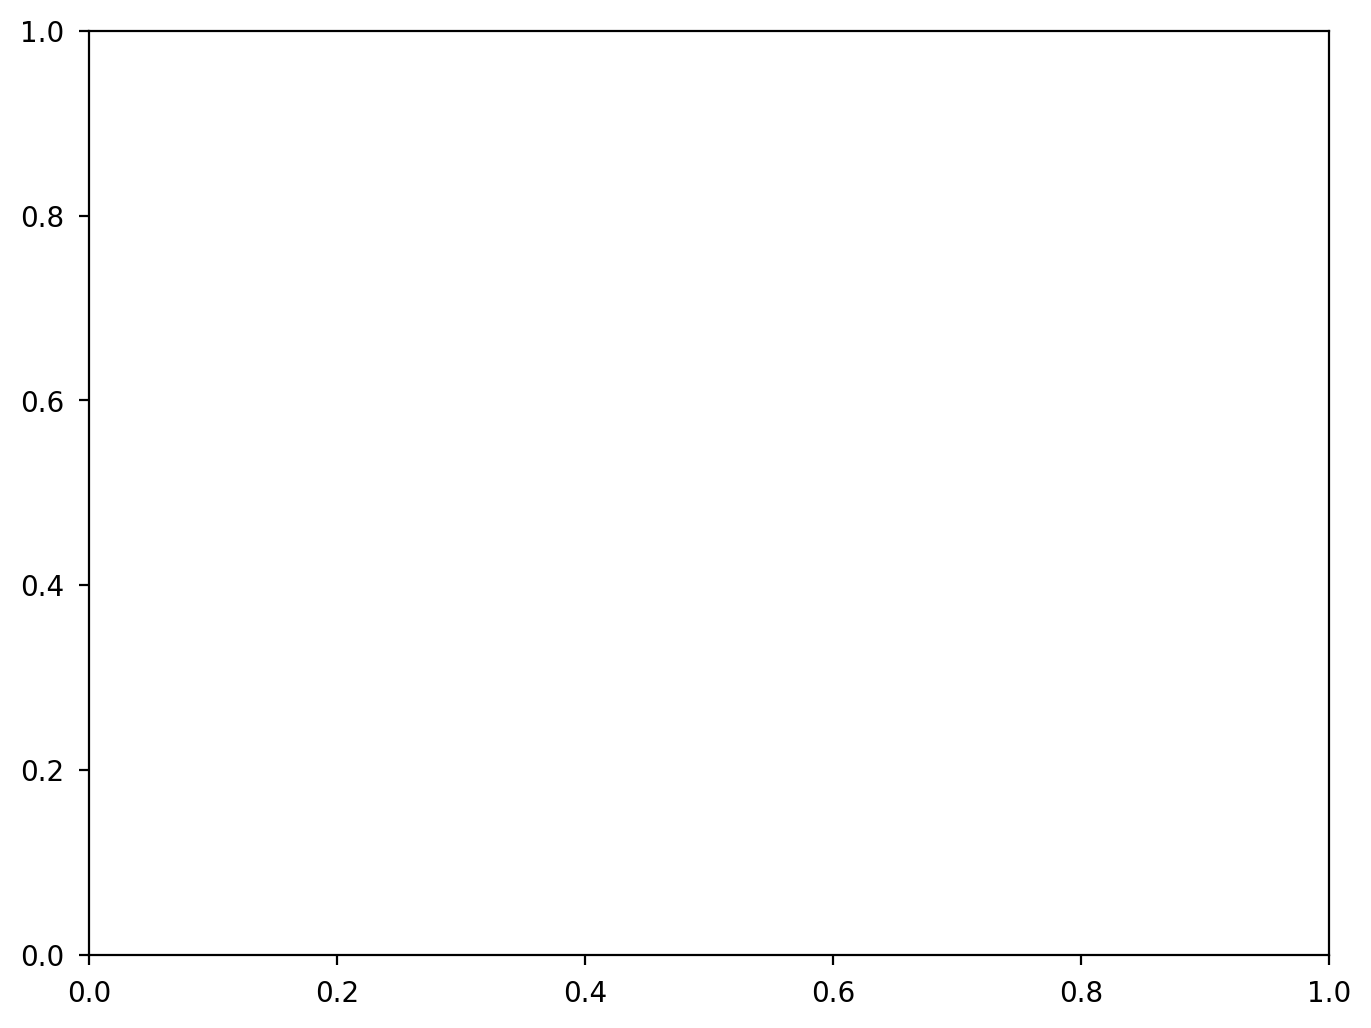

In [22]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

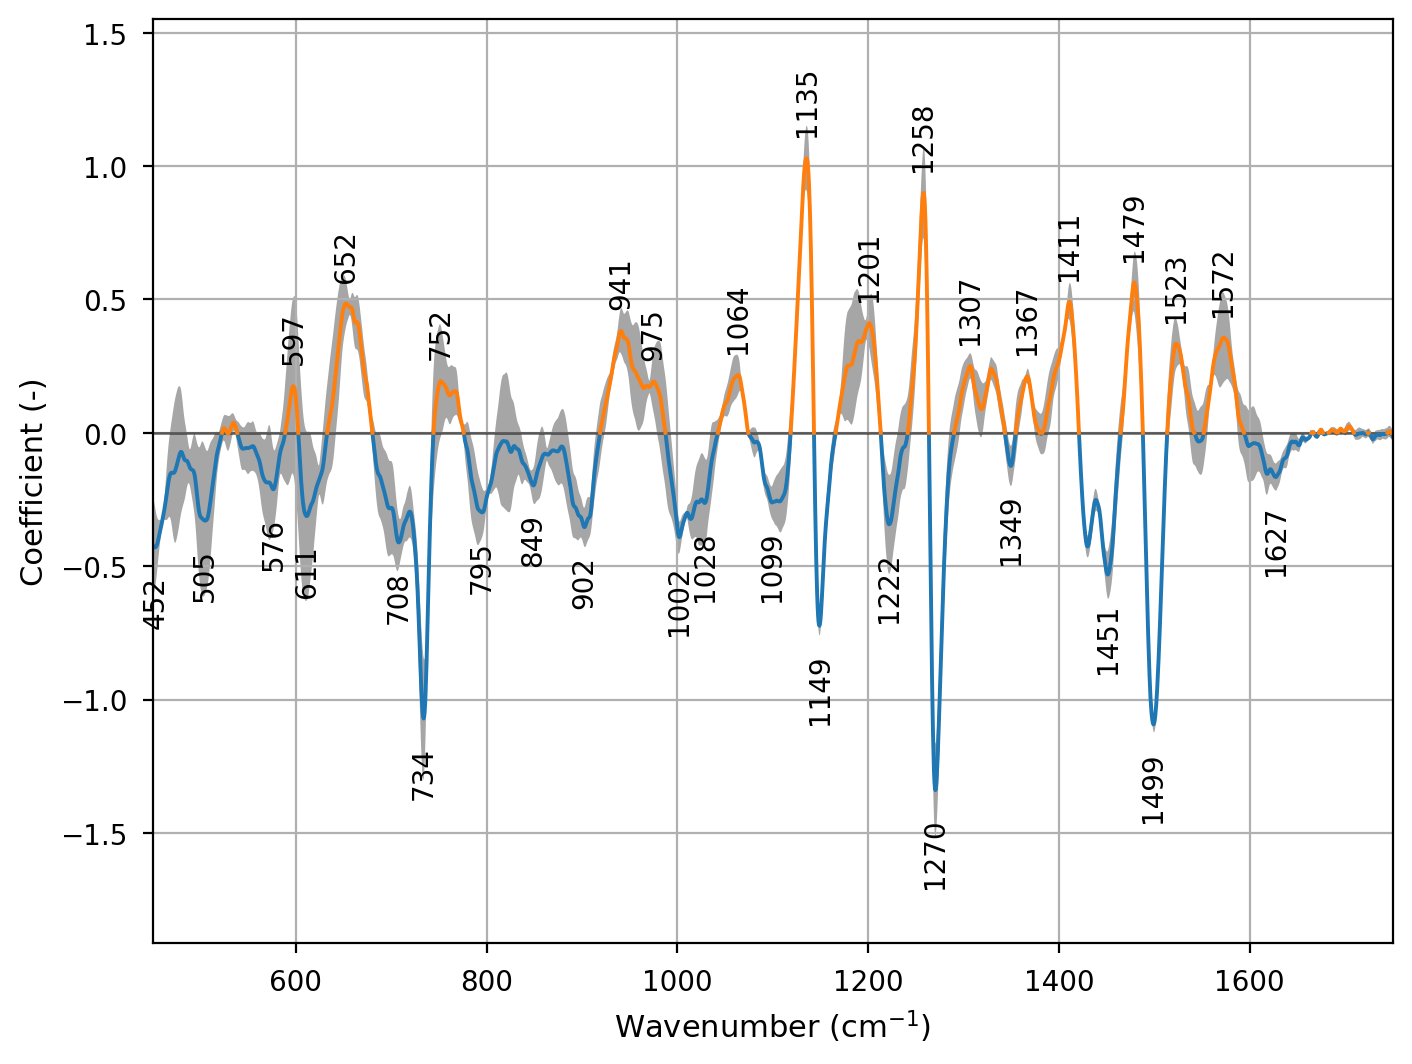

In [23]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.1, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

ValueError: Found input variables with inconsistent numbers of samples: [1200, 1344]

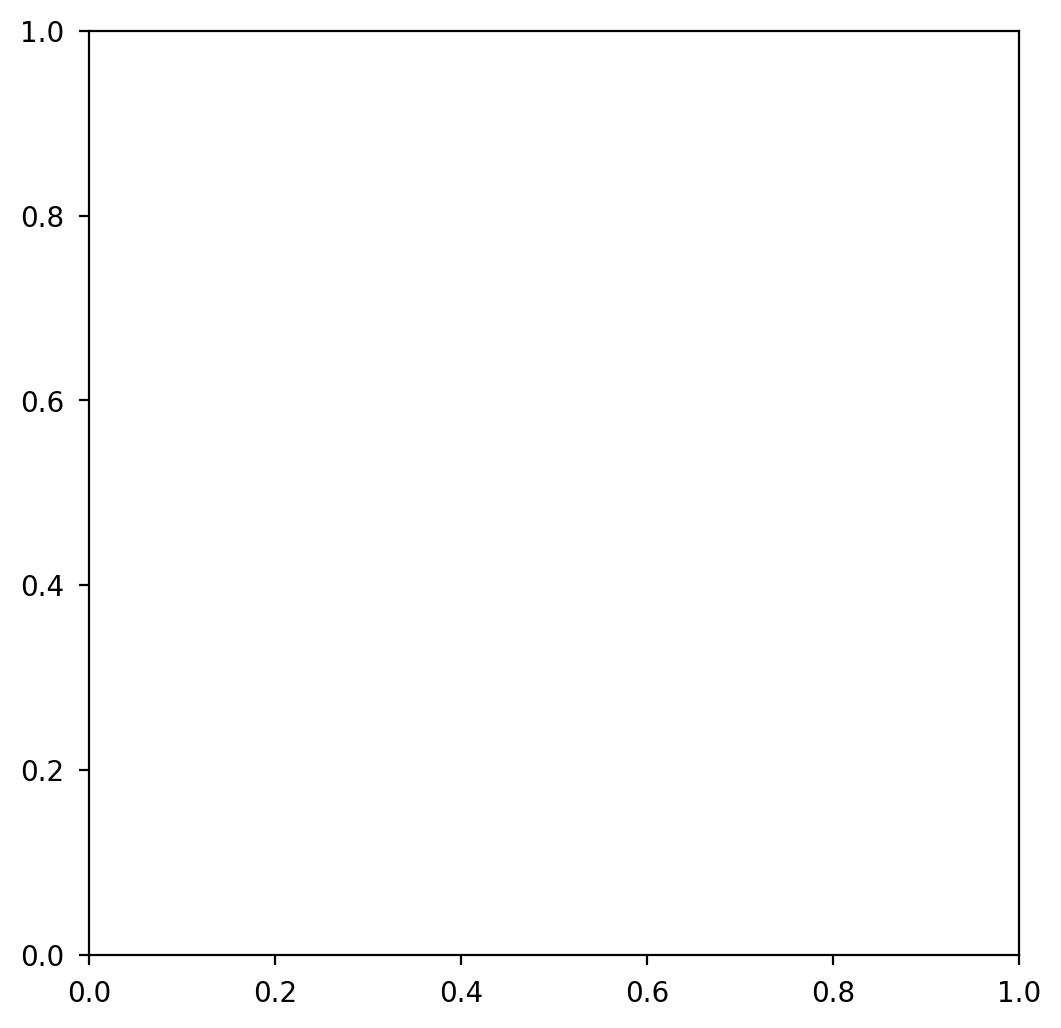

In [24]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

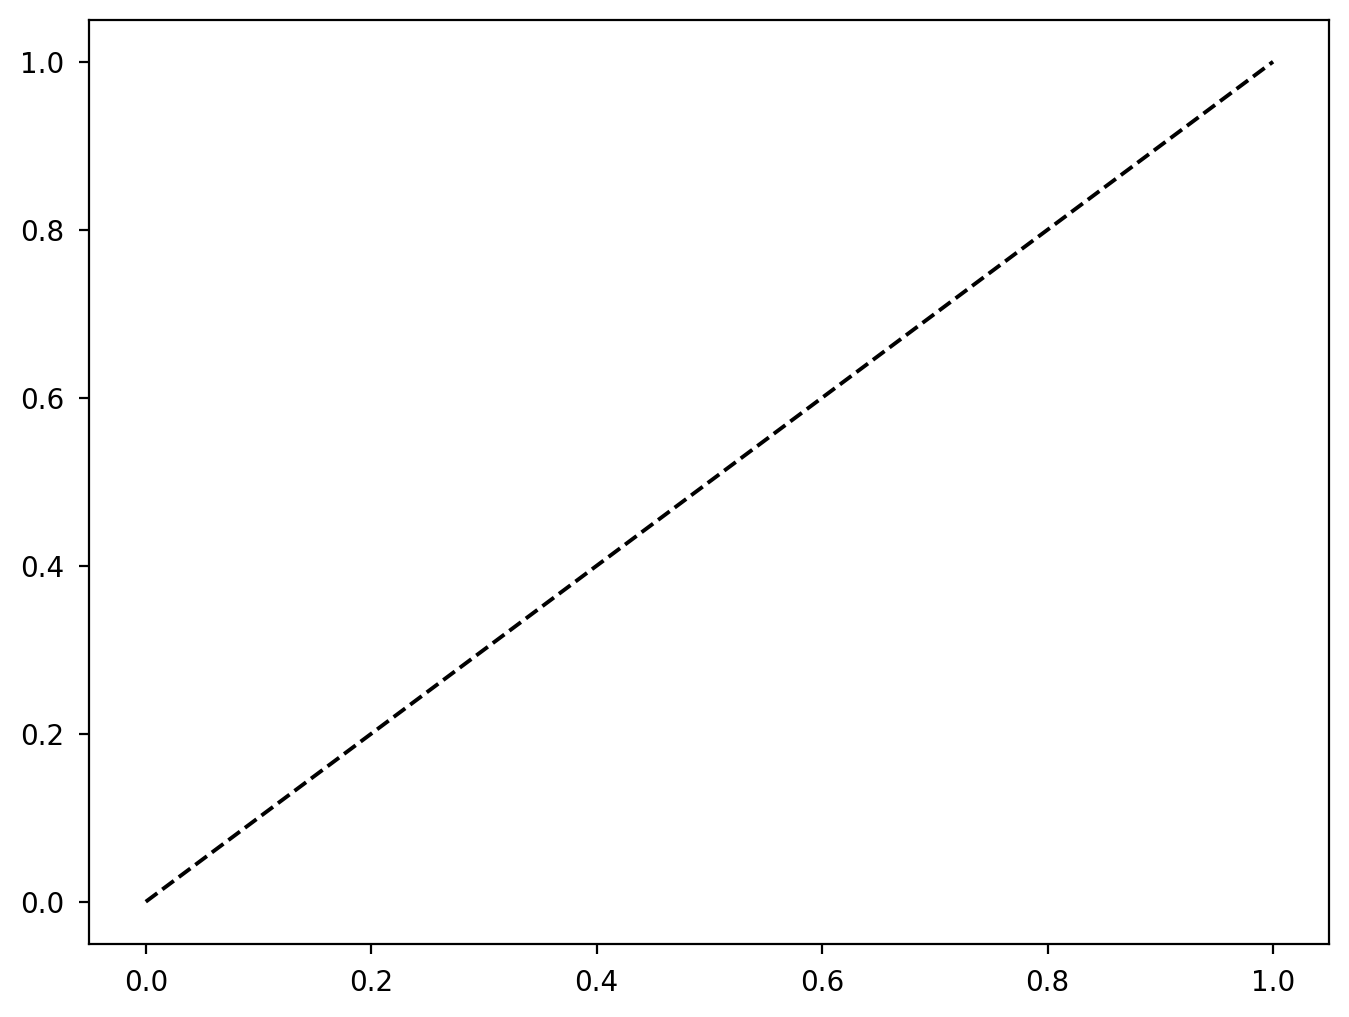

In [25]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## NMF-LDA
### Overview

In [26]:
current_path = results_path / "lda_dim_reduction/nmf_lda/"
name = "NMF-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

AttributeError: 'DataFrame' object has no attribute 'test_f1'

### Validation Curve

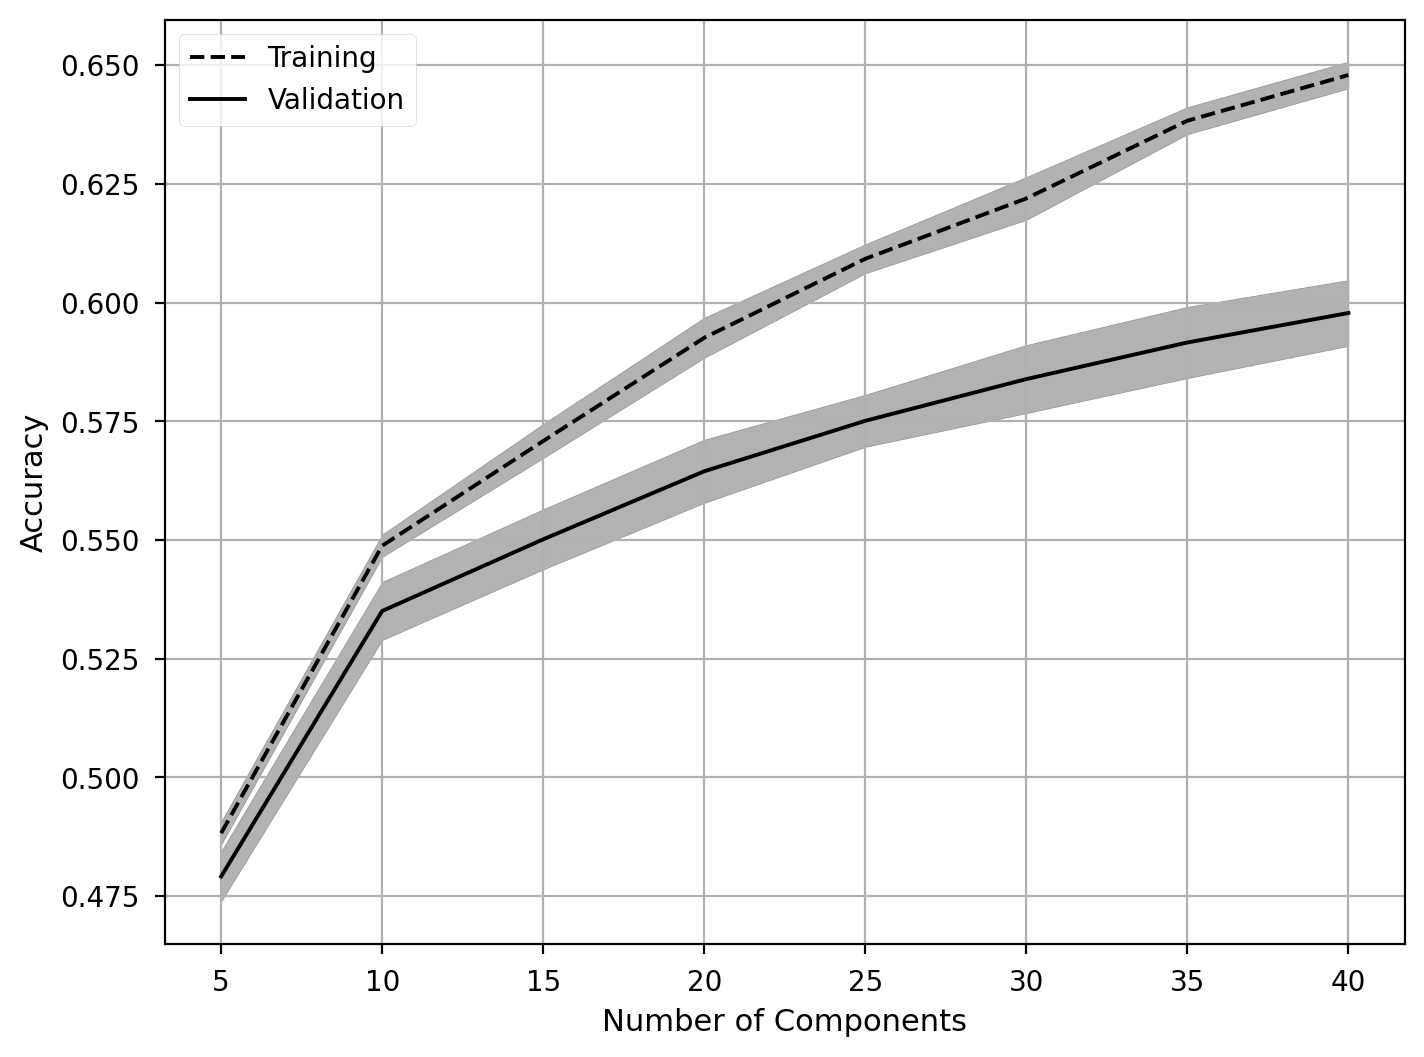

In [27]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Number of Components")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

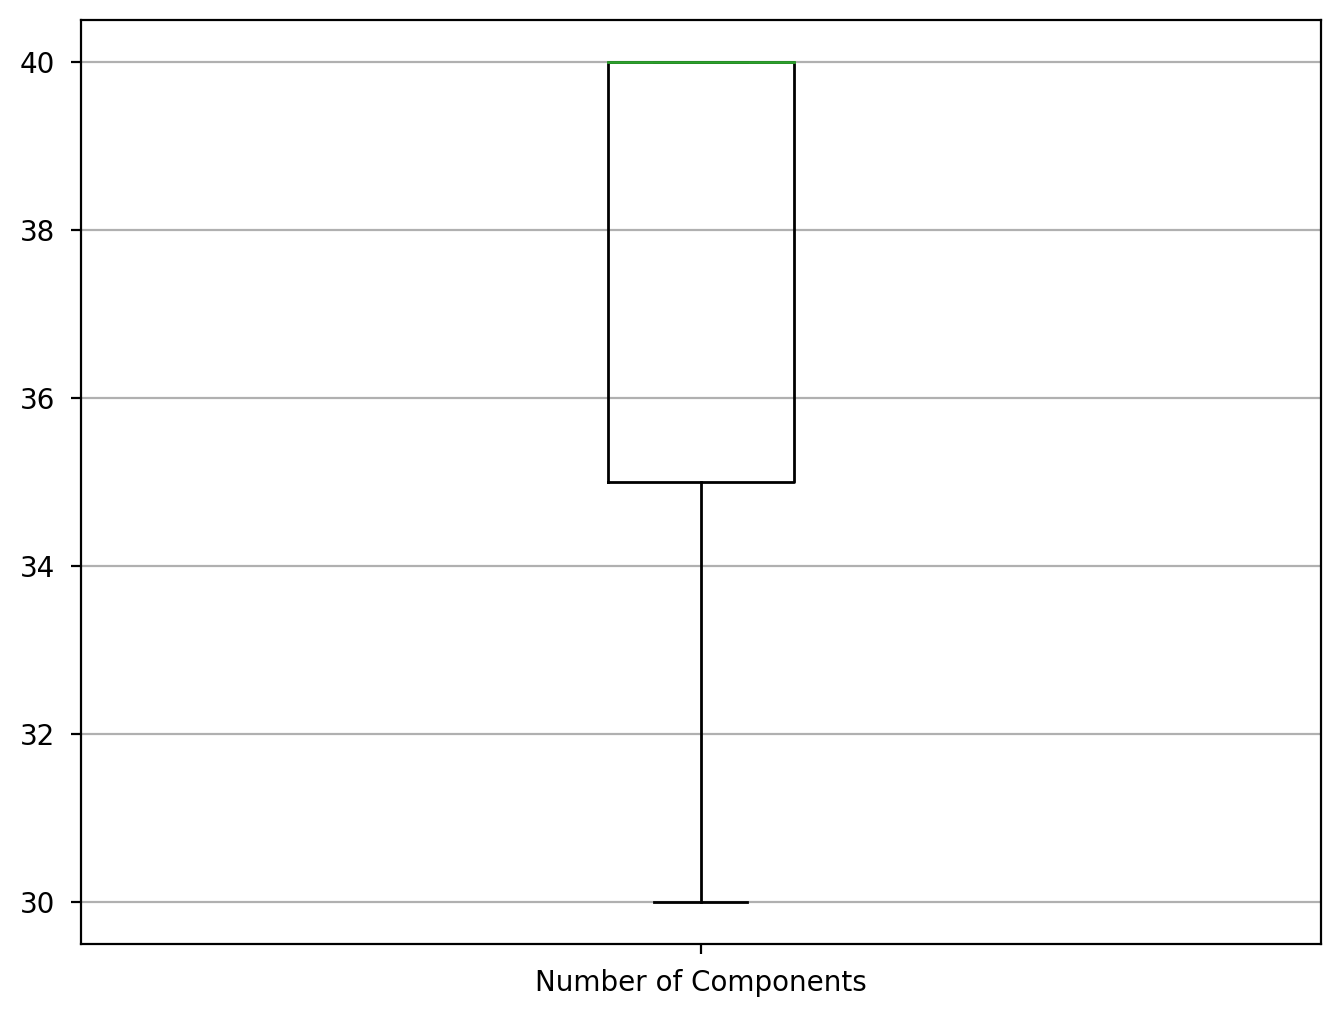

In [28]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Number of Components"])
ax.grid(axis="y")

### Confidence scores by class

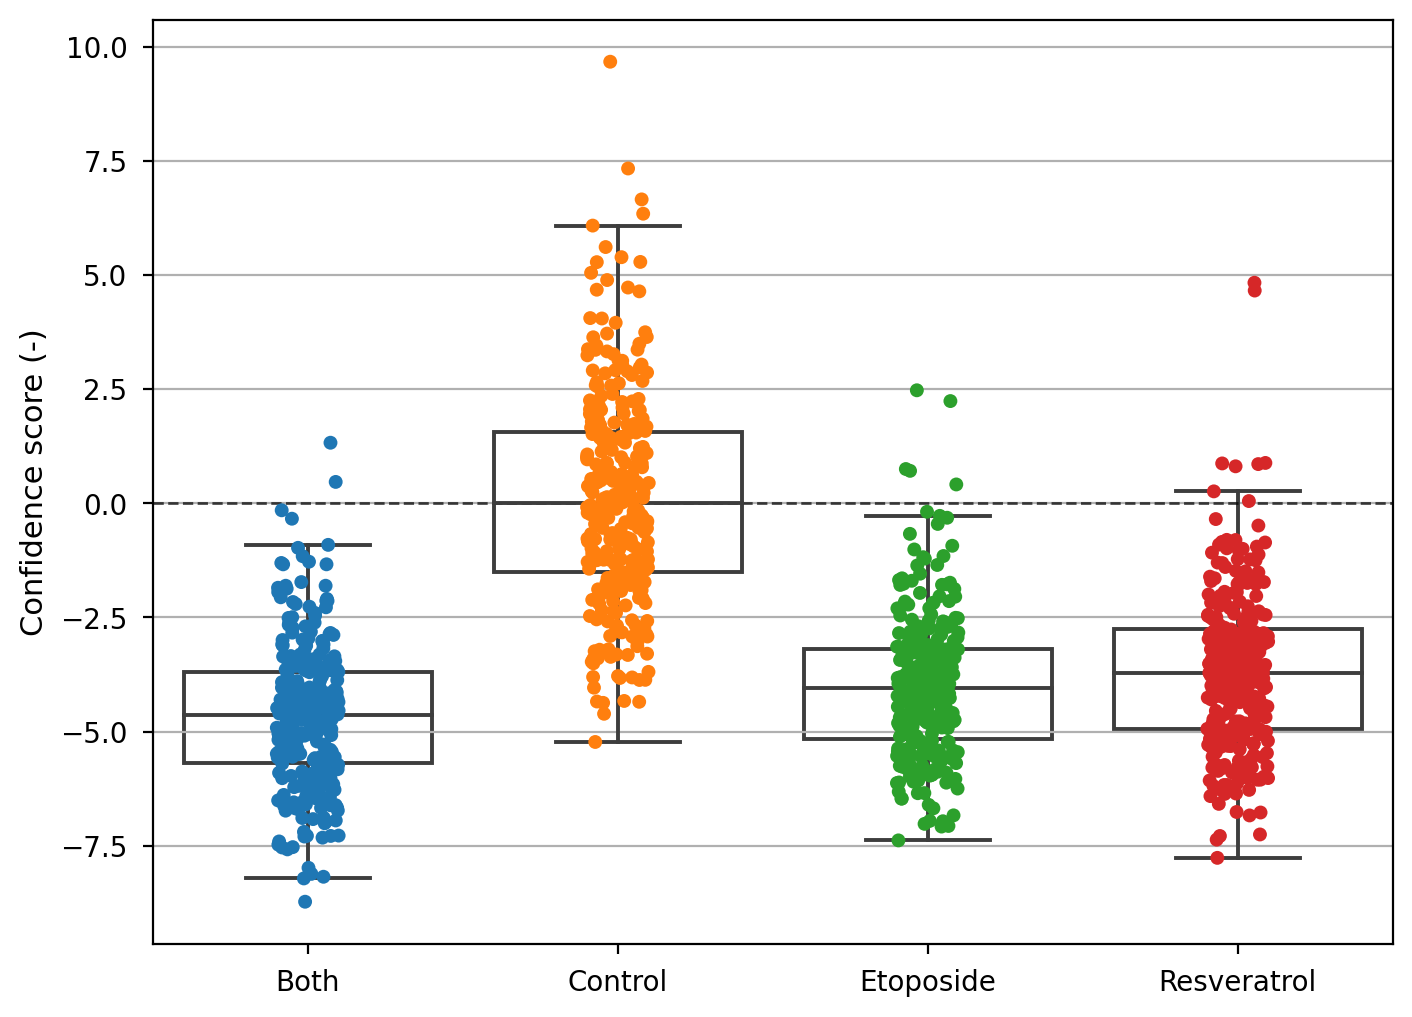

In [29]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

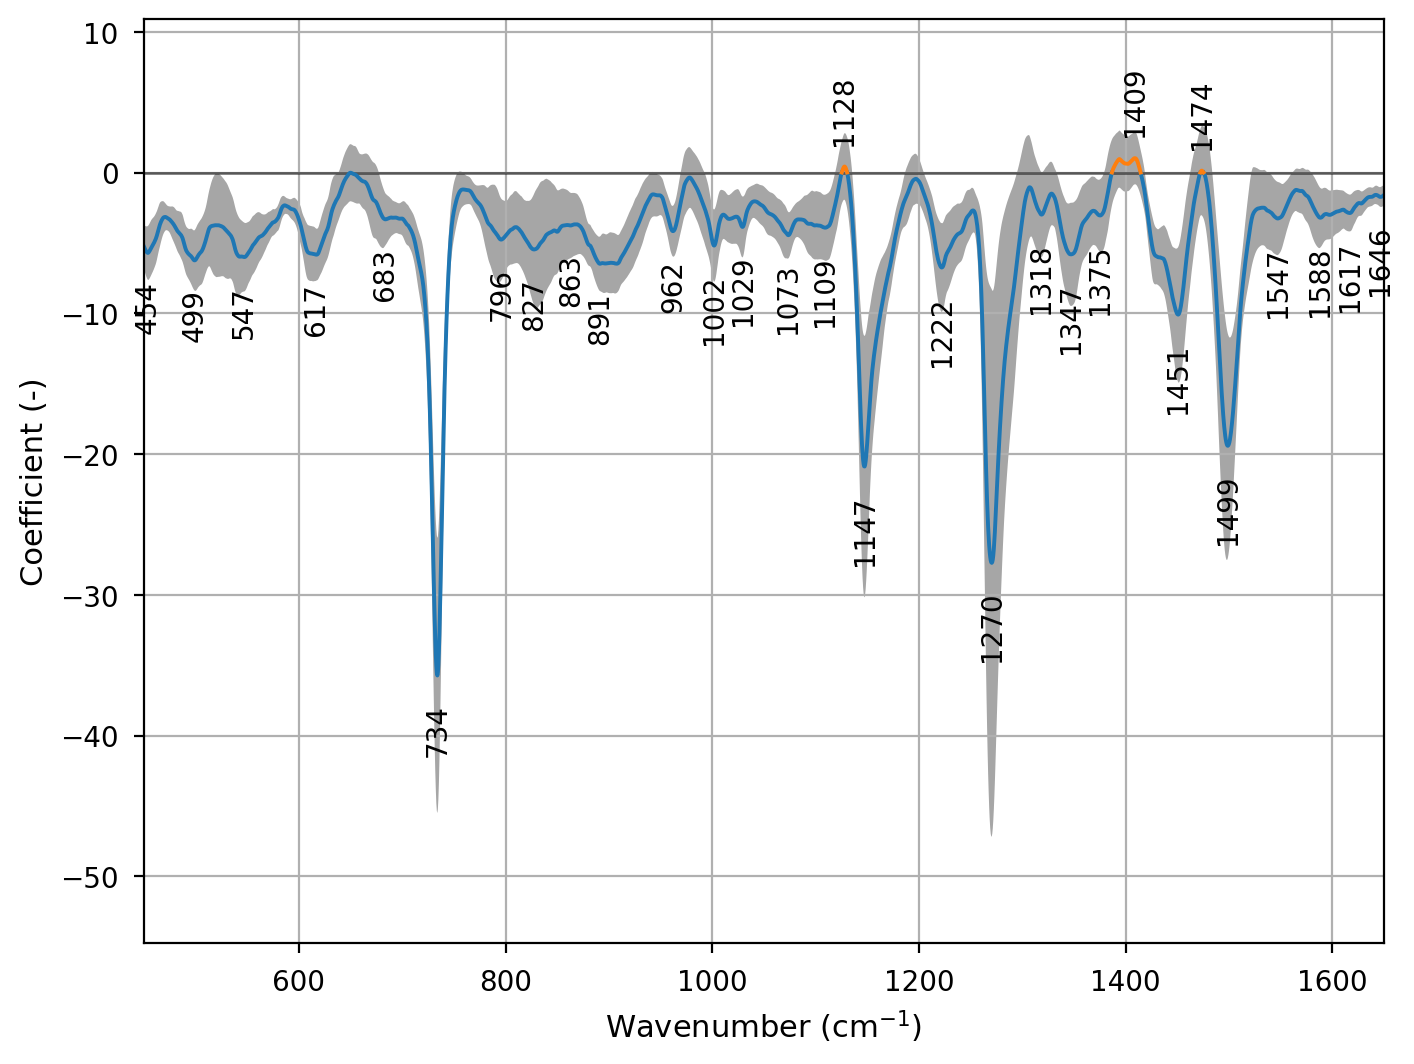

In [30]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.1, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

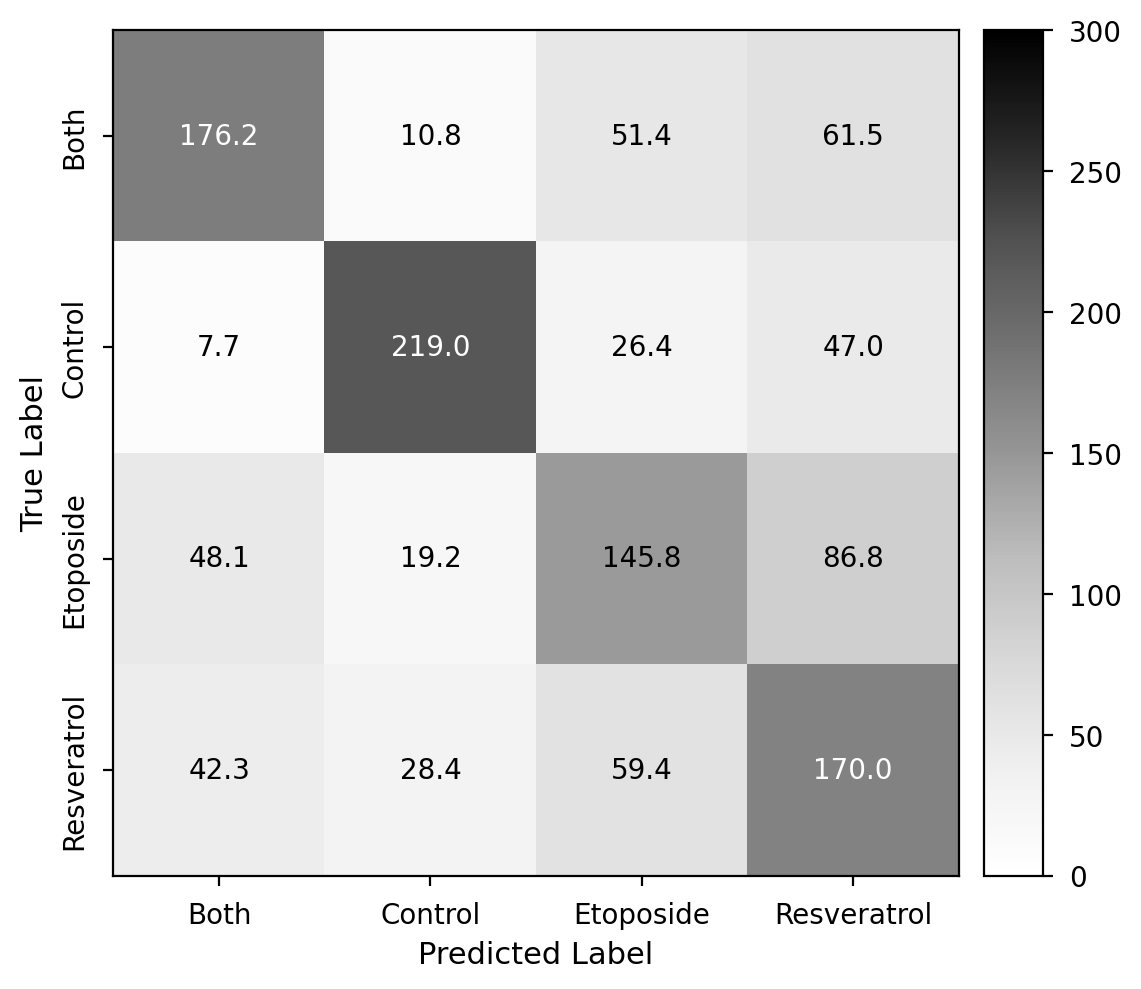

In [31]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

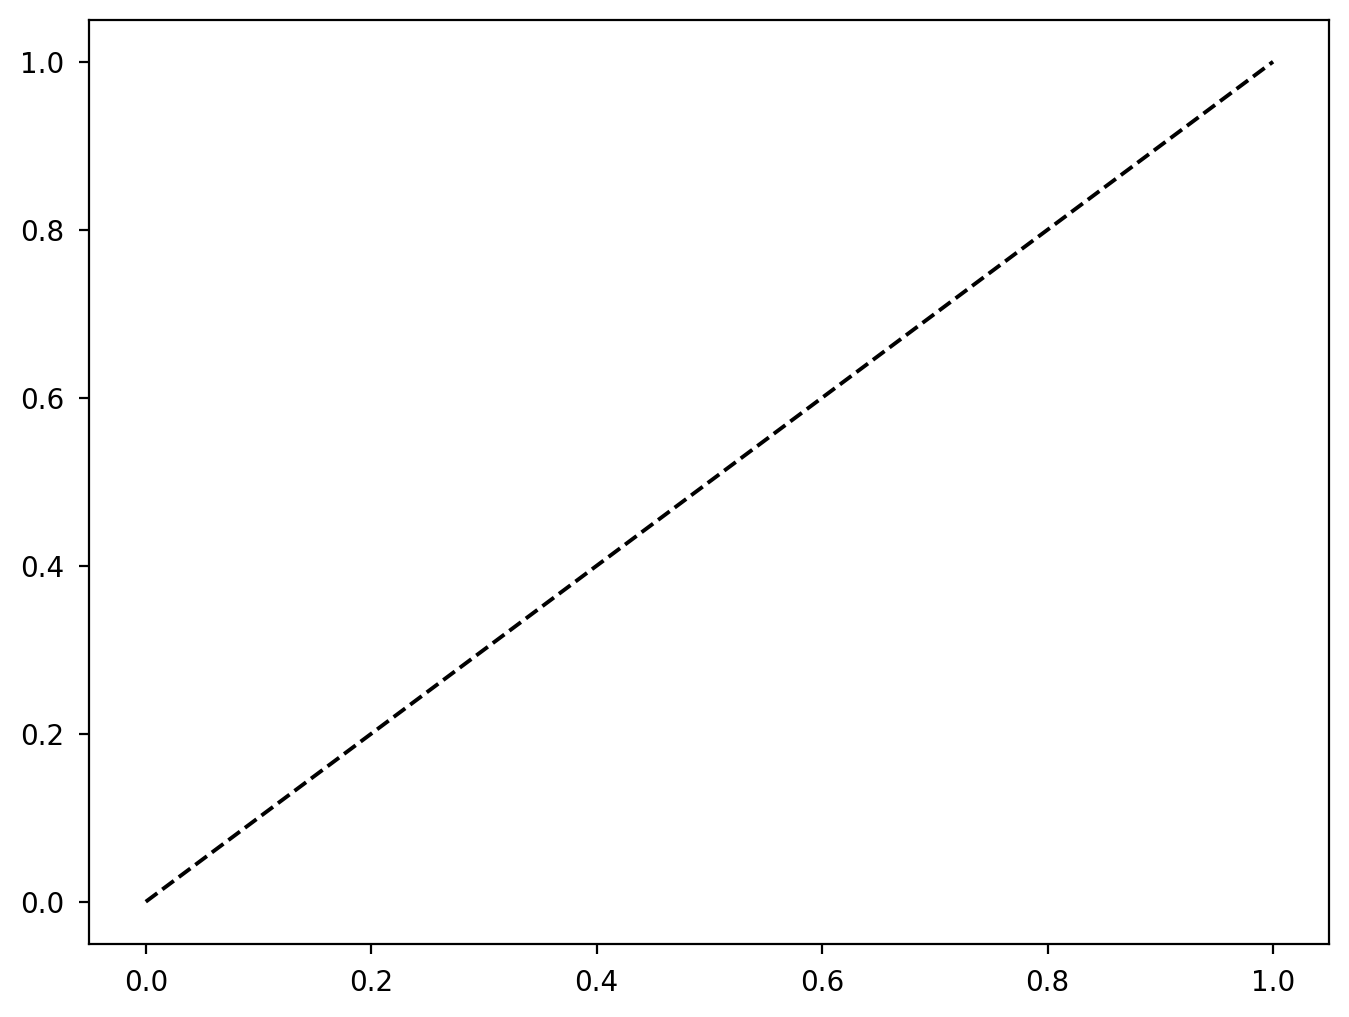

In [32]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Feature Agglomeration (FA) - LDA
### Overview

In [34]:
current_path = results_path / "lda_dim_reduction/fa_lda/"
name = "FA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_accuracy  test_accuracy   fit_time  predict_time       p_value
count       20.000000      20.000000  20.000000     20.000000  2.000000e+01
mean         0.631583       0.580042   3.435669      0.009588  3.344761e-49
std          0.003656       0.011715   0.033746      0.000230  1.467738e-48
min          0.625208       0.555000   3.373843      0.009083  3.497577e-59
25%          0.629271       0.571458   3.411470      0.009479  1.414674e-55
50%          0.631563       0.582083   3.431543      0.009578  1.627376e-54
75%          0.633490       0.588542   3.460009      0.009713  1.207279e-51
max          0.638333       0.597500   3.497648      0.010055  6.569610e-48

### Validation Curve

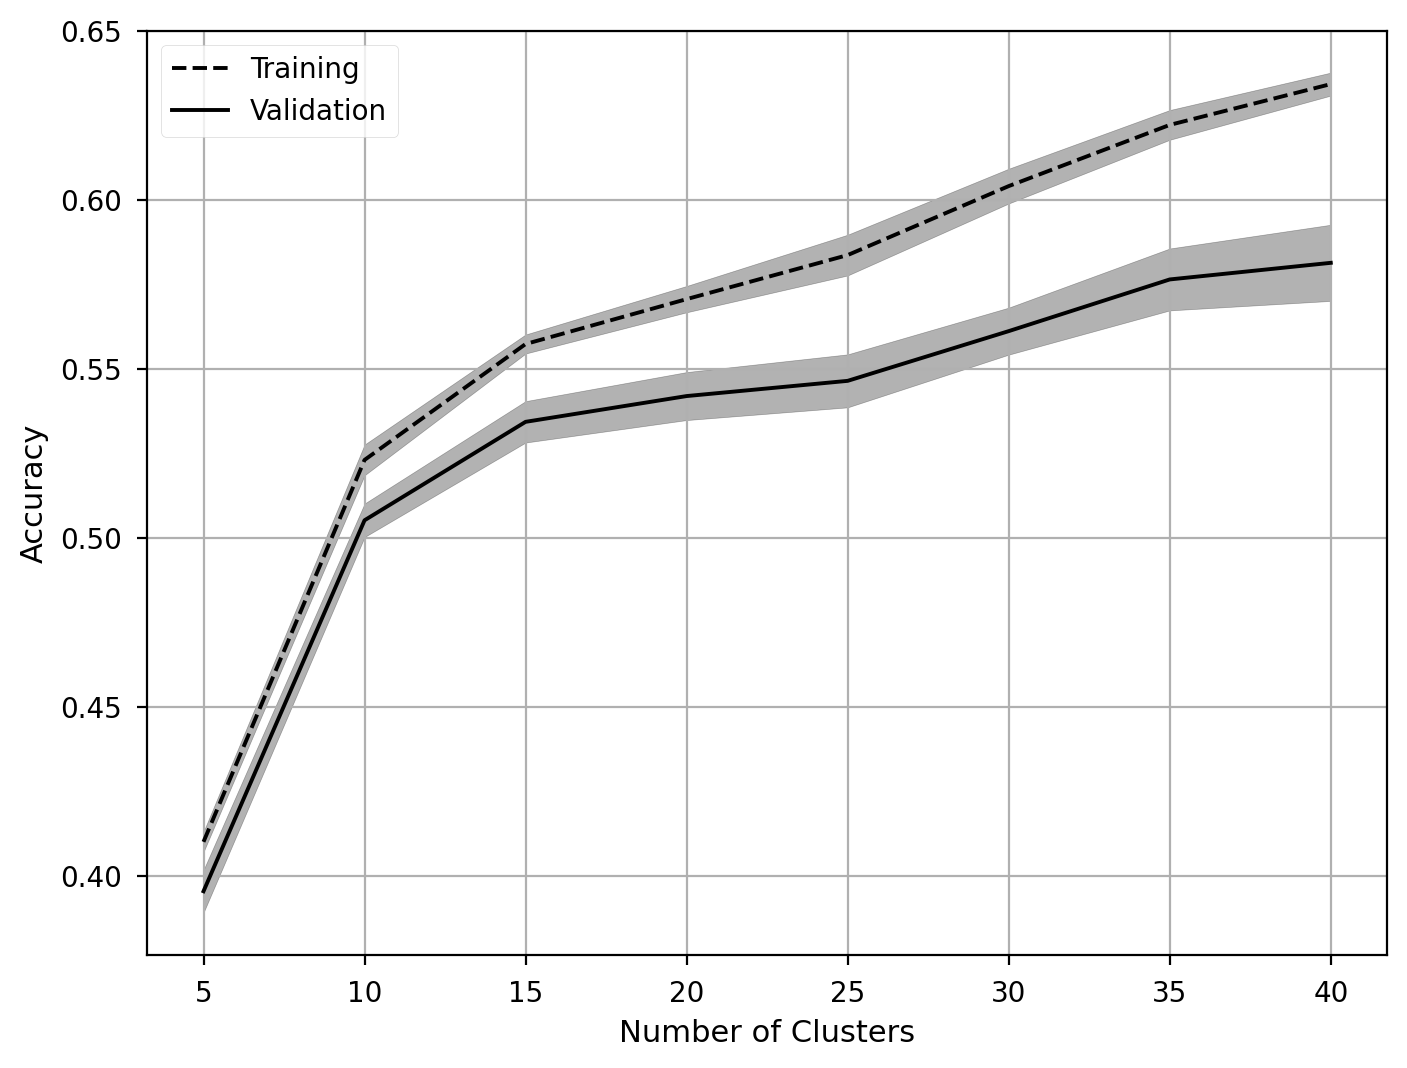

In [35]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

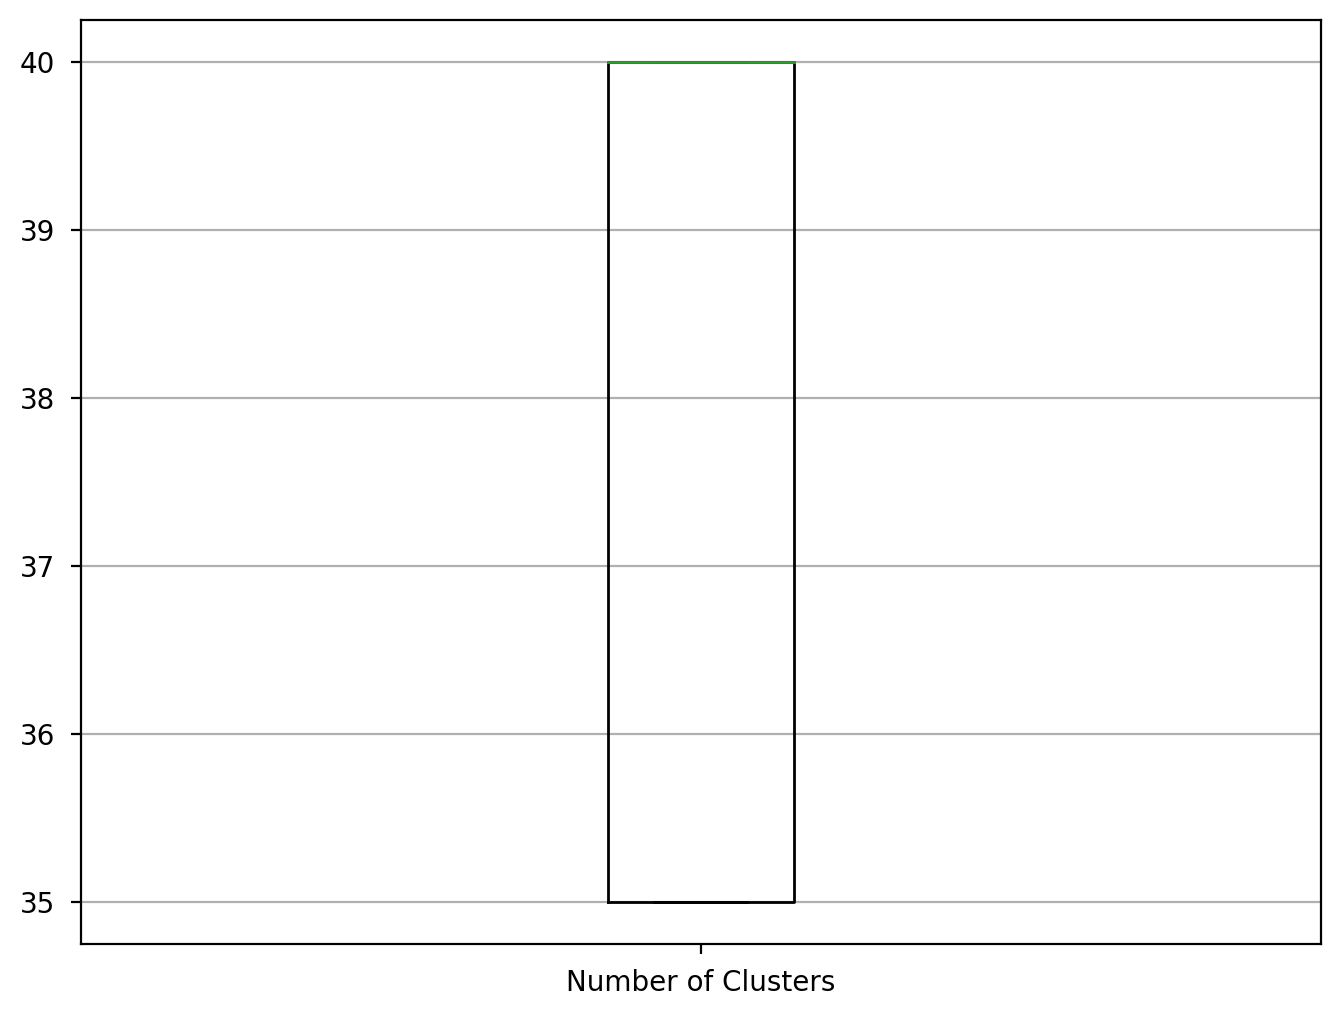

In [36]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Number of Clusters"])
ax.grid(axis="y")

### Confidence scores by class

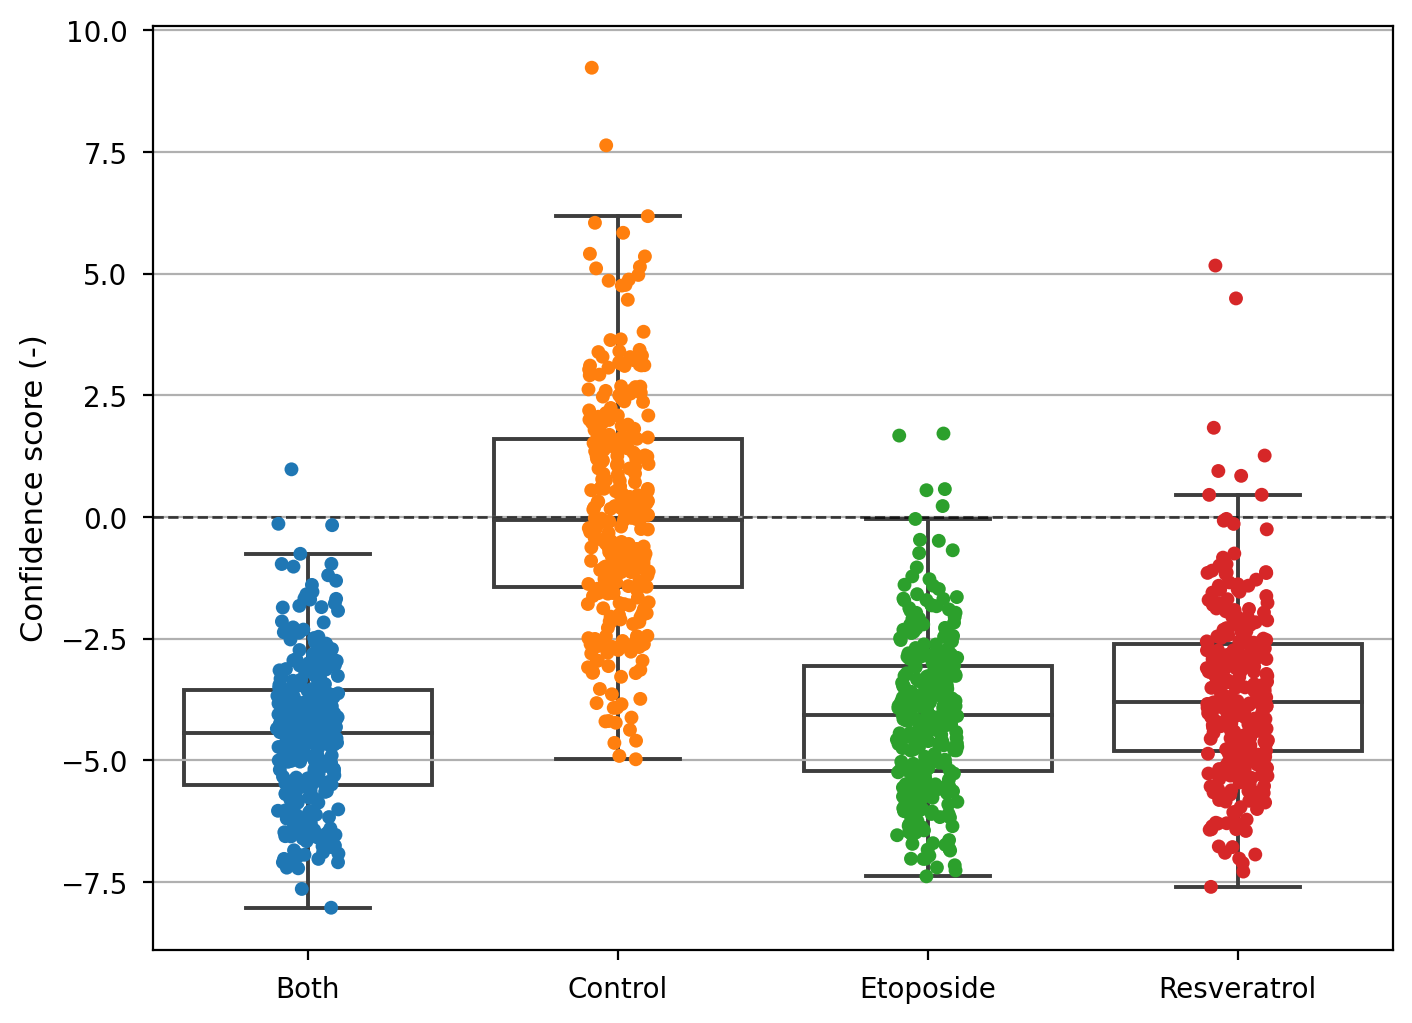

In [37]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

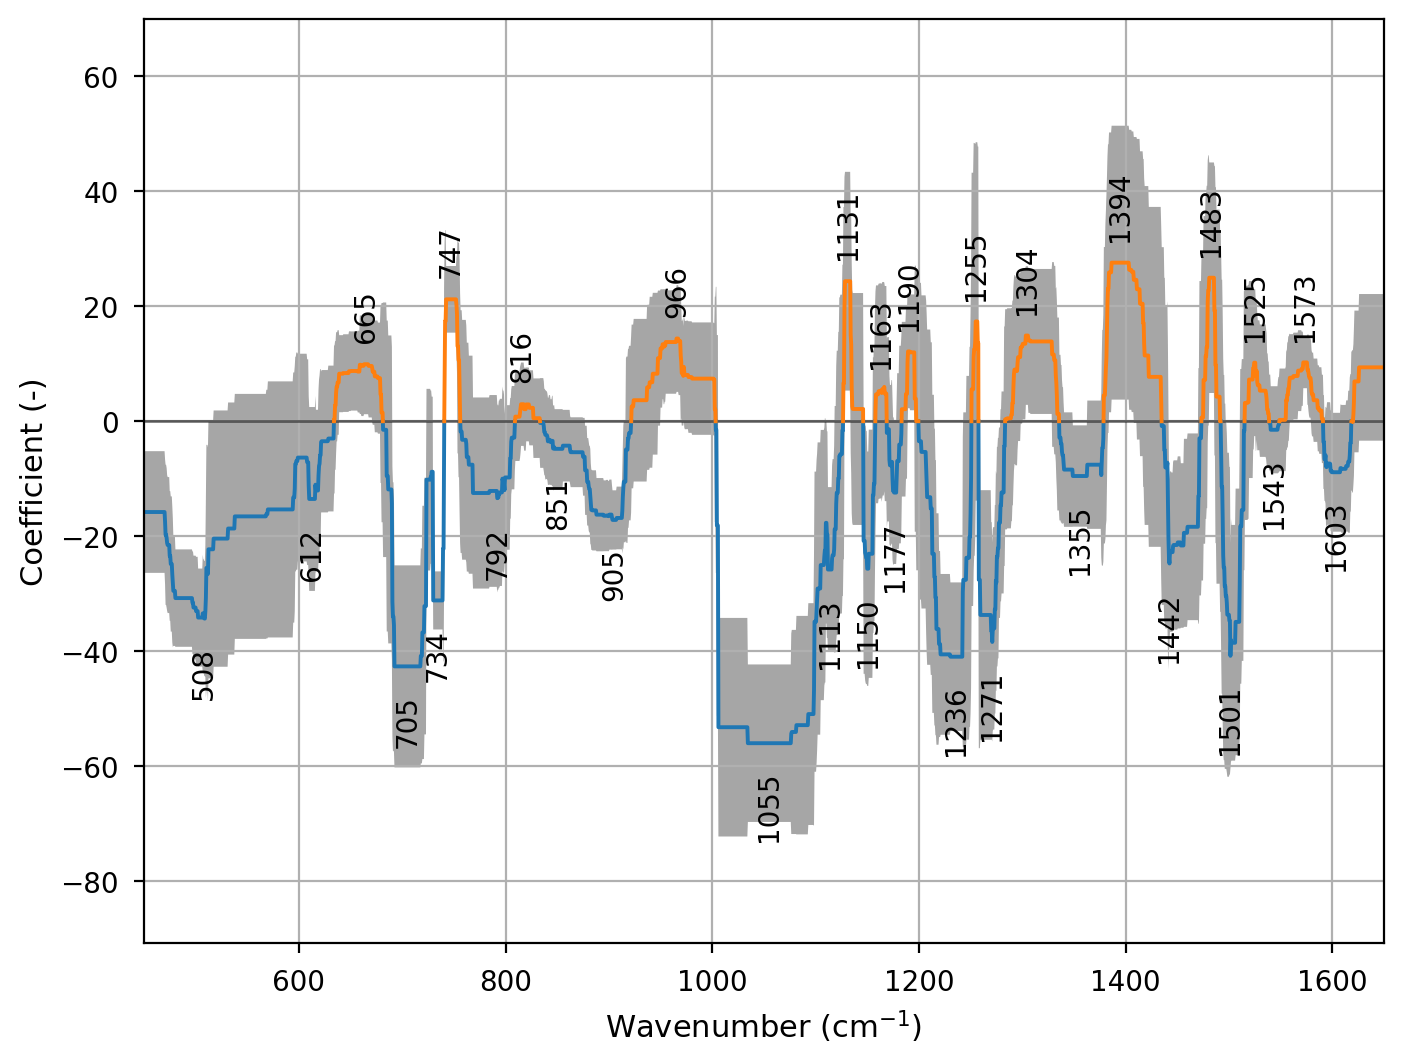

In [38]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.1, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

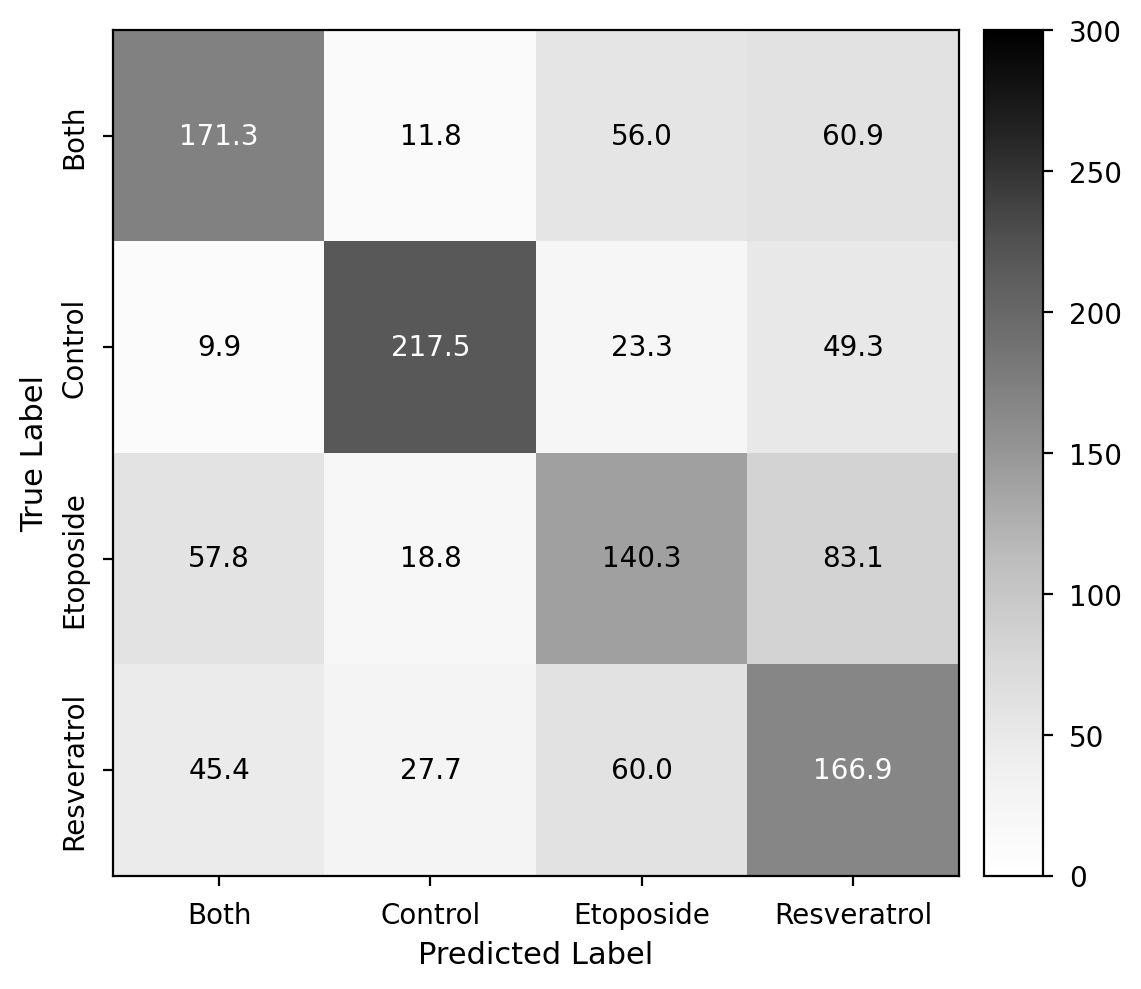

In [39]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

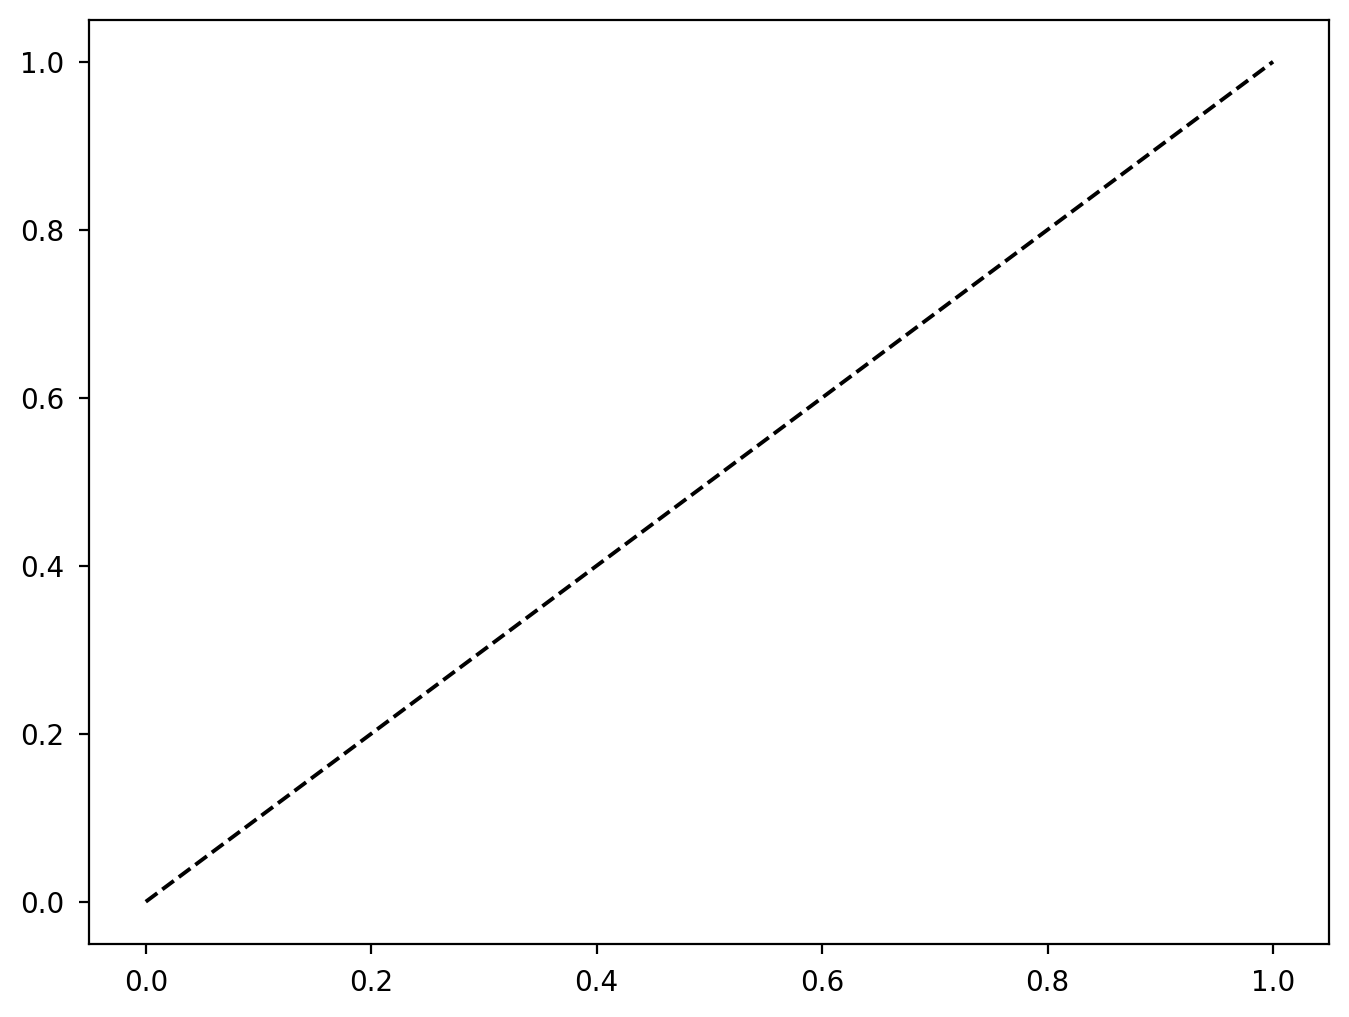

In [40]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Peak-LDA
### Overview

In [42]:
current_path = results_path / "lda_dim_reduction/peak_lda/"
name = "Peak-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_accuracy  test_accuracy   fit_time  predict_time       p_value
count       20.000000      20.000000  20.000000     20.000000  2.000000e+01
mean         0.597677       0.558417   0.479857      0.000944  6.816144e-47
std          0.003921       0.008156   0.021796      0.000161  1.276432e-46
min          0.591458       0.547500   0.452185      0.000757  1.415434e-53
25%          0.594688       0.551875   0.465451      0.000856  8.502810e-50
50%          0.597604       0.556667   0.472170      0.000927  1.826225e-48
75%          0.600573       0.563958   0.483167      0.000970  4.146912e-47
max          0.607083       0.571667   0.535483      0.001472  4.014038e-46

### Validation Curve

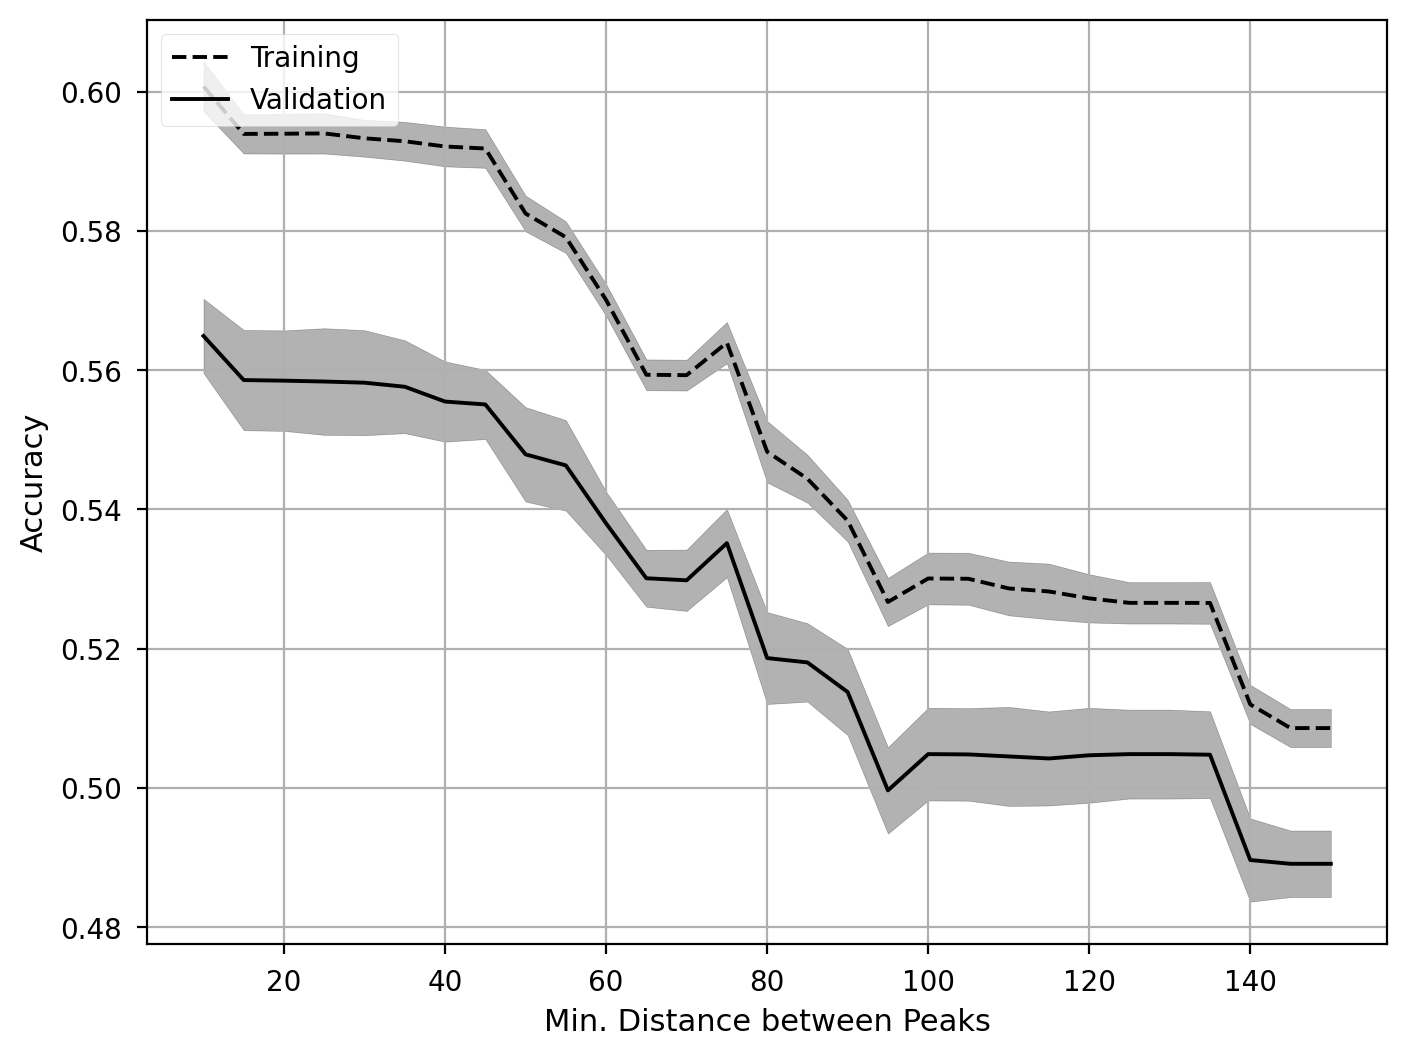

In [43]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Min. Distance between Peaks")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

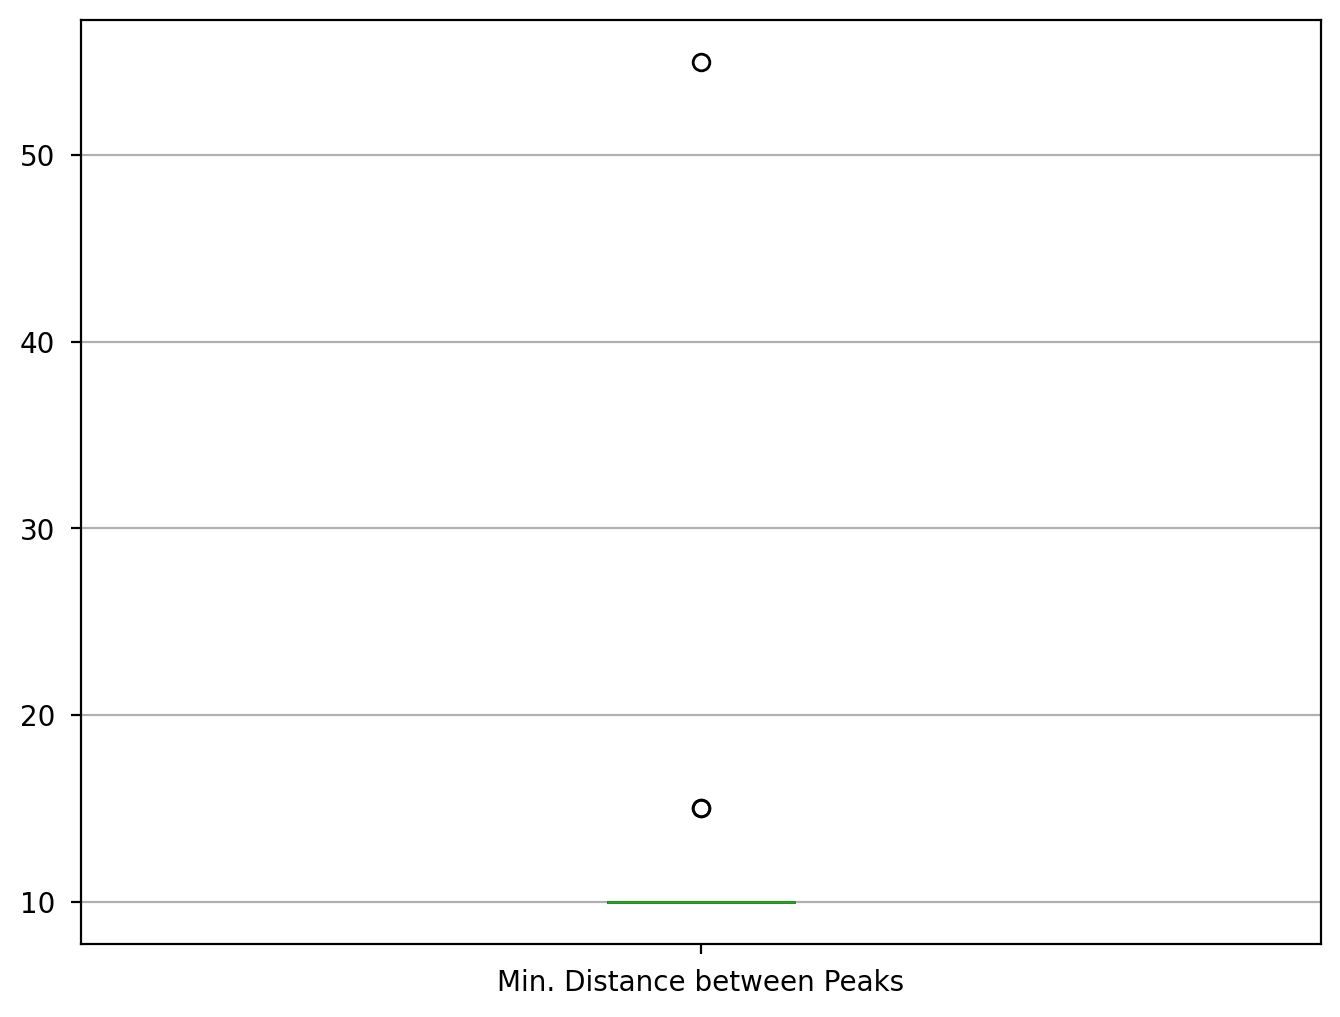

In [44]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Min. Distance between Peaks"])
ax.grid(axis="y")

### Confidence scores by class

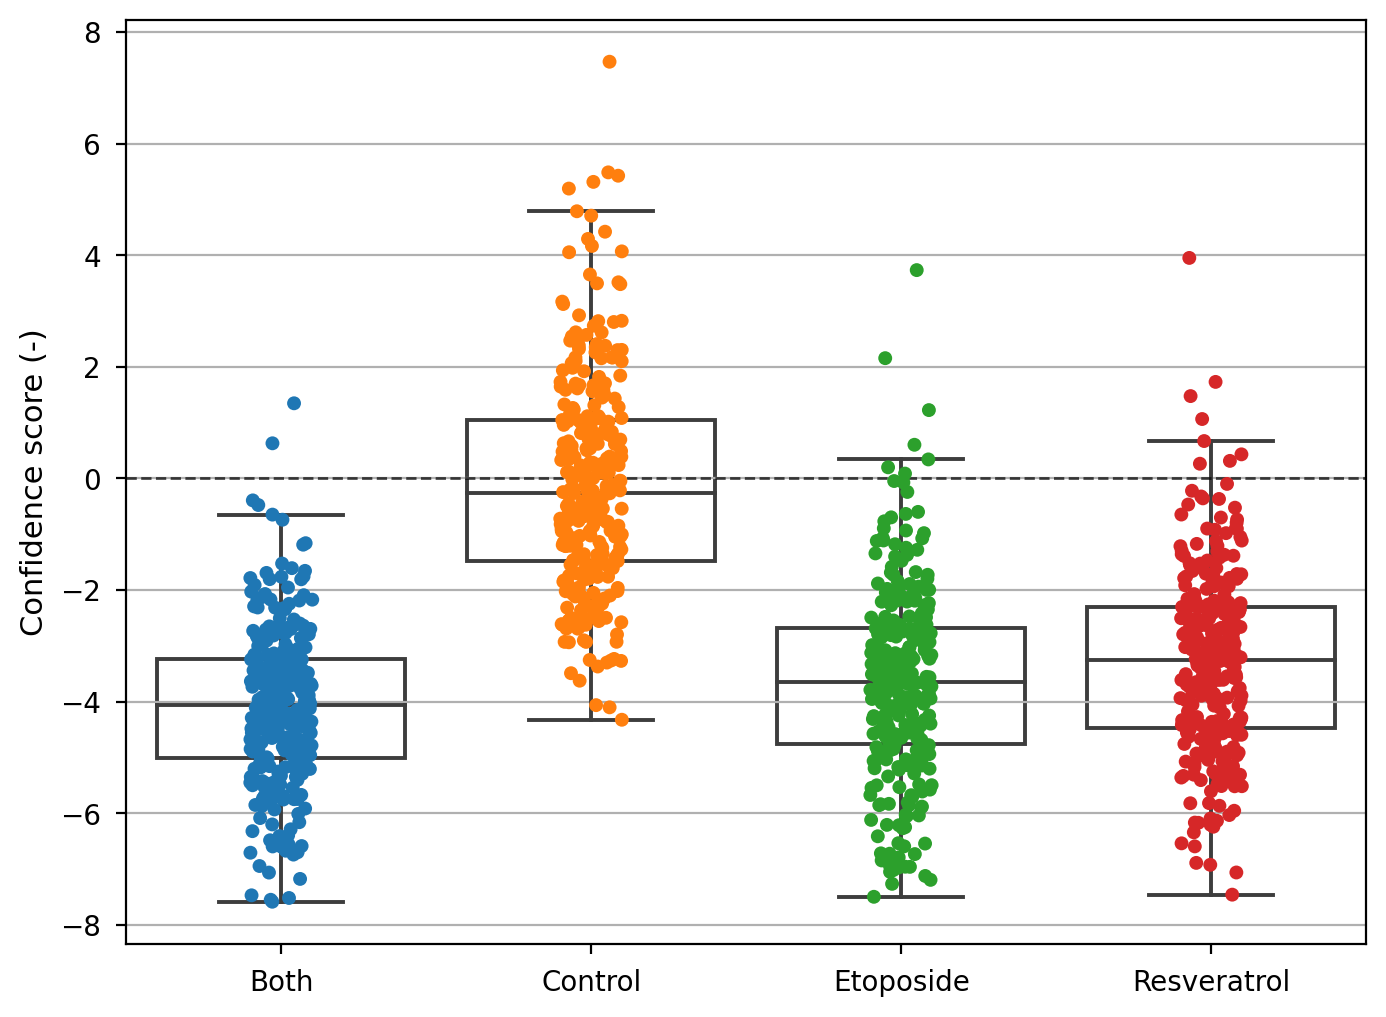

In [45]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

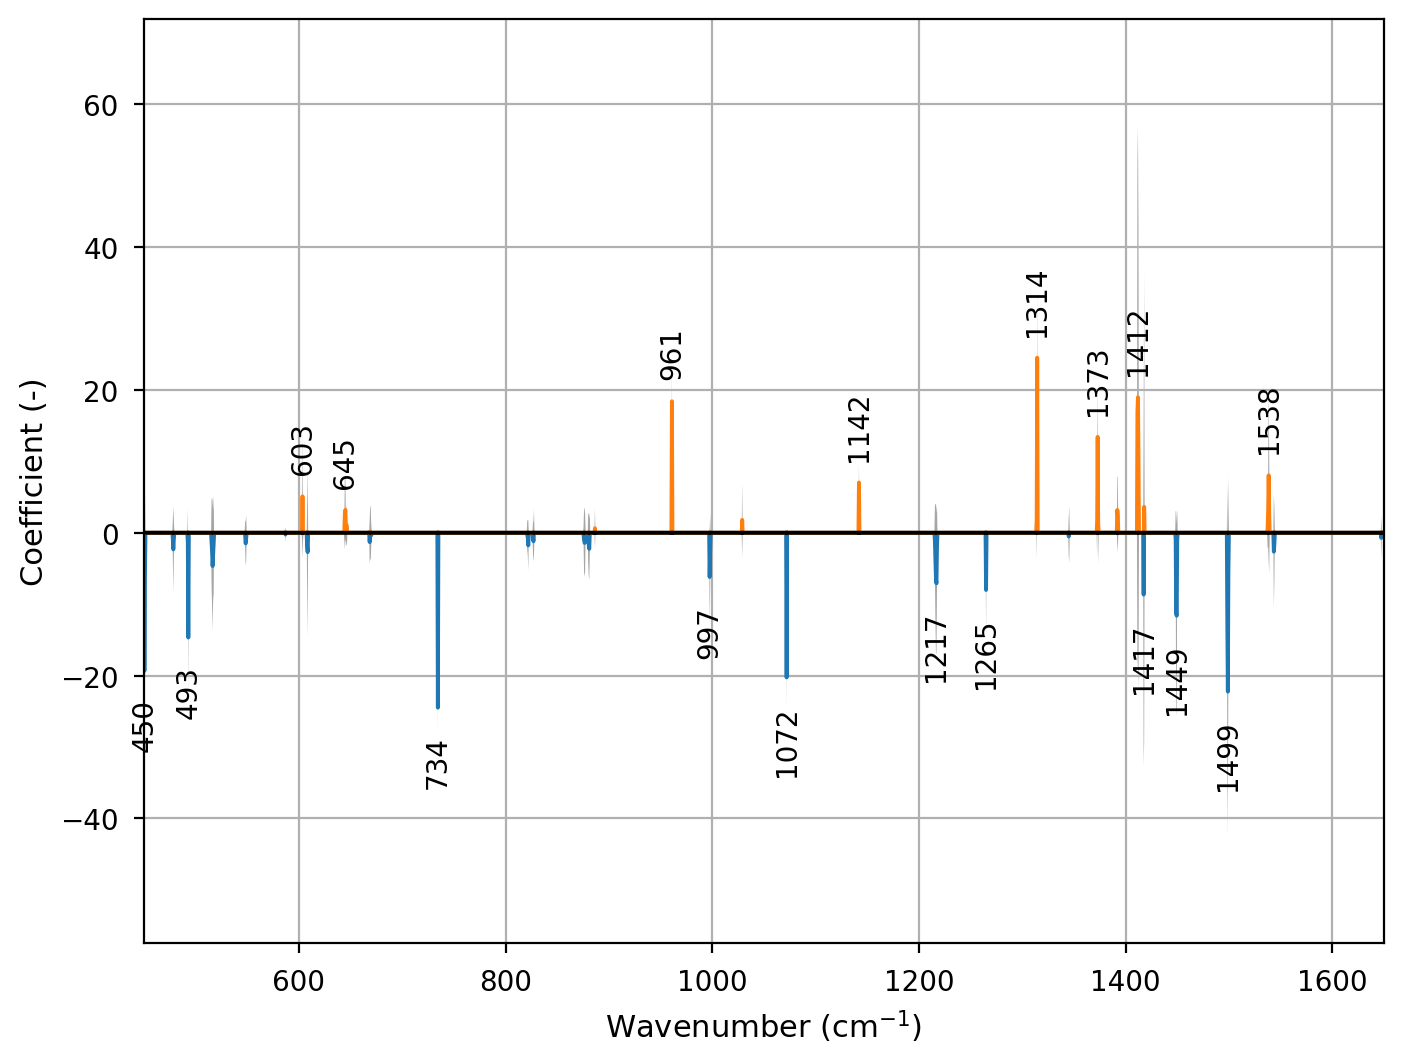

In [46]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 3, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

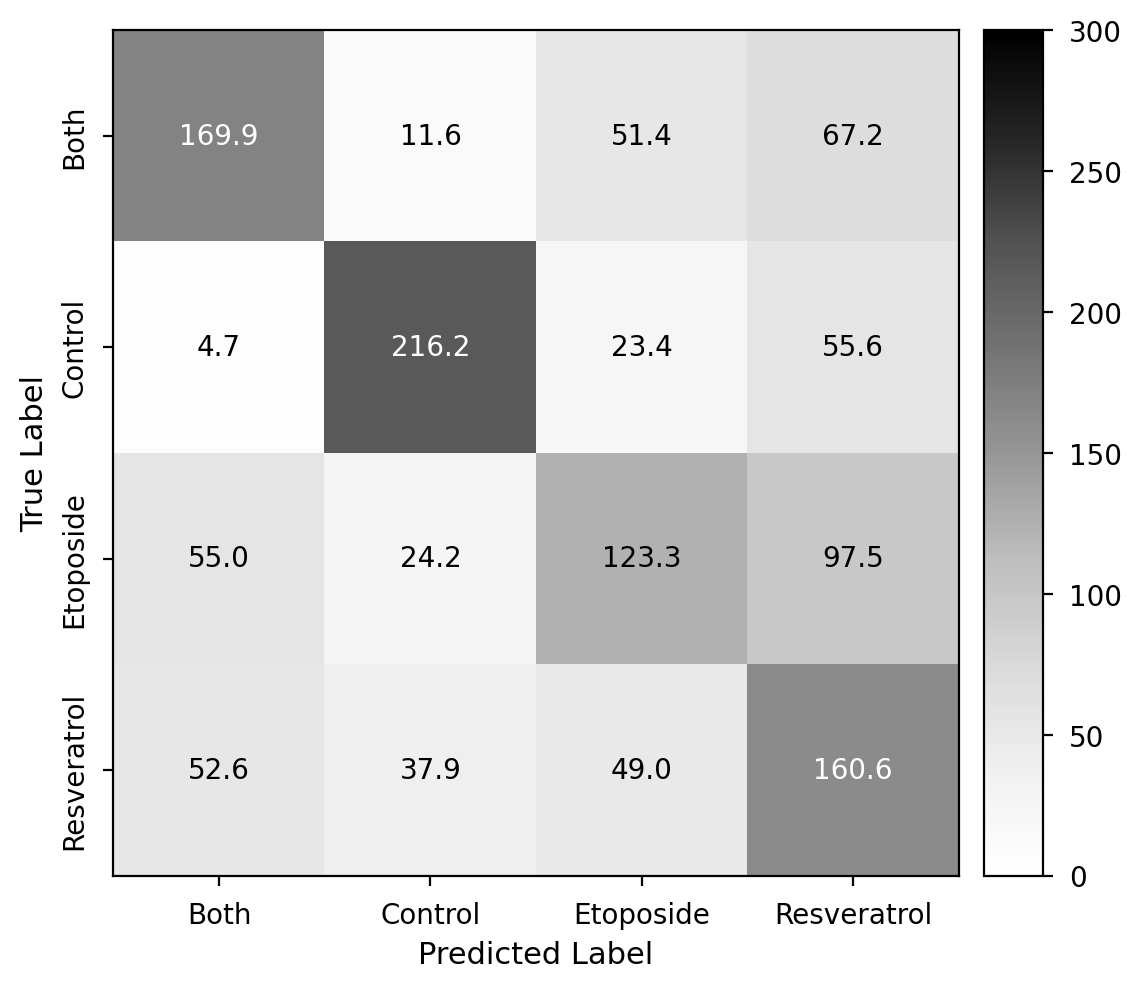

In [47]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

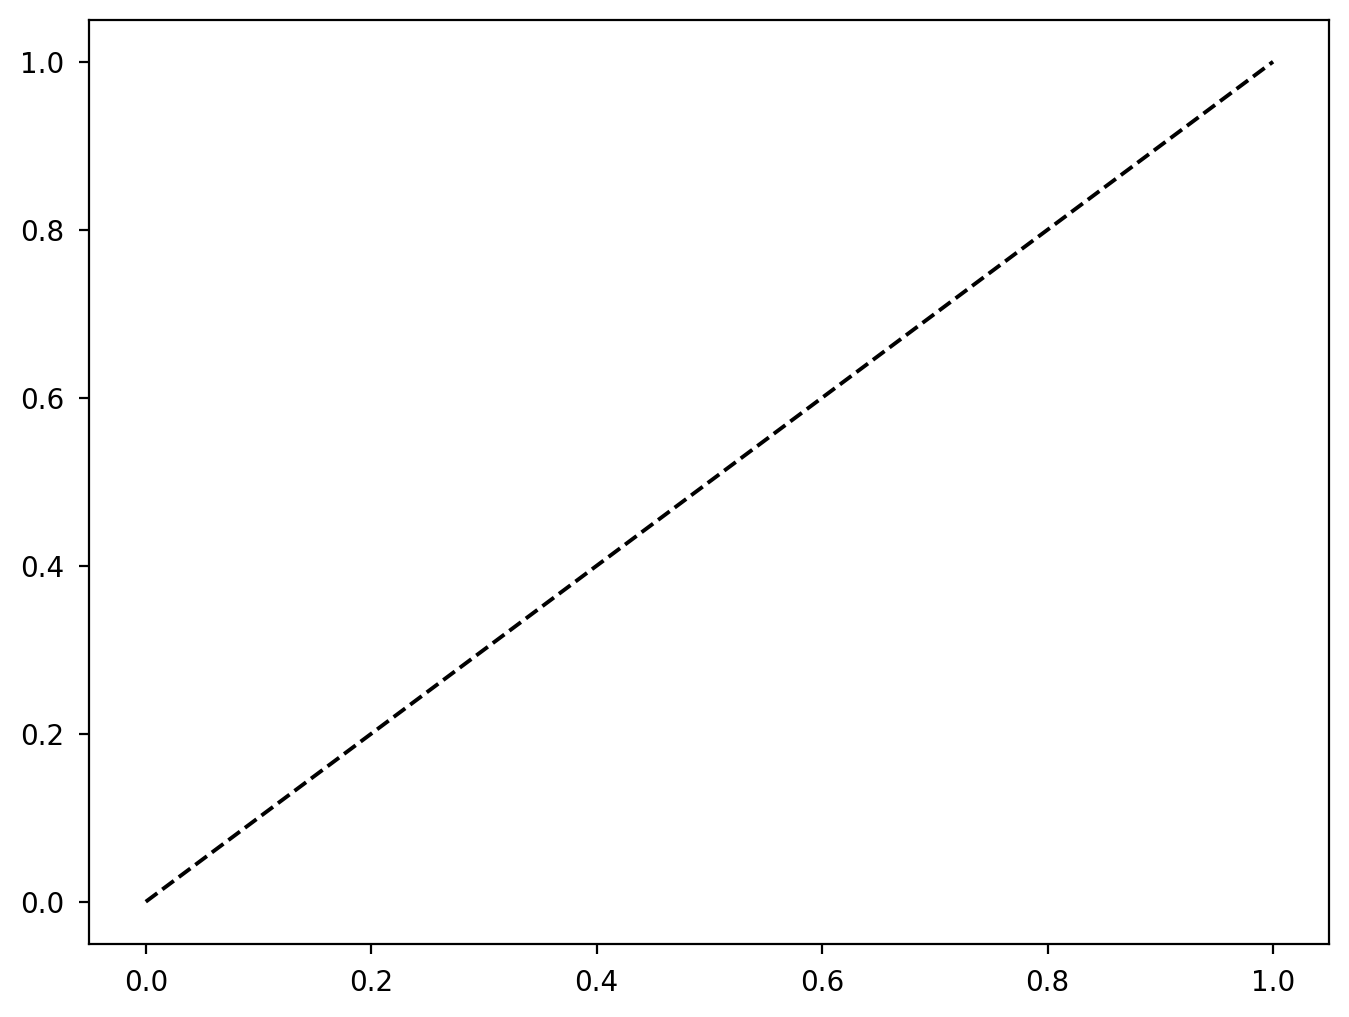

In [48]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Comparison of LDA with different dimensionality Reductions

Text(0, 0.5, 'Accuracy')

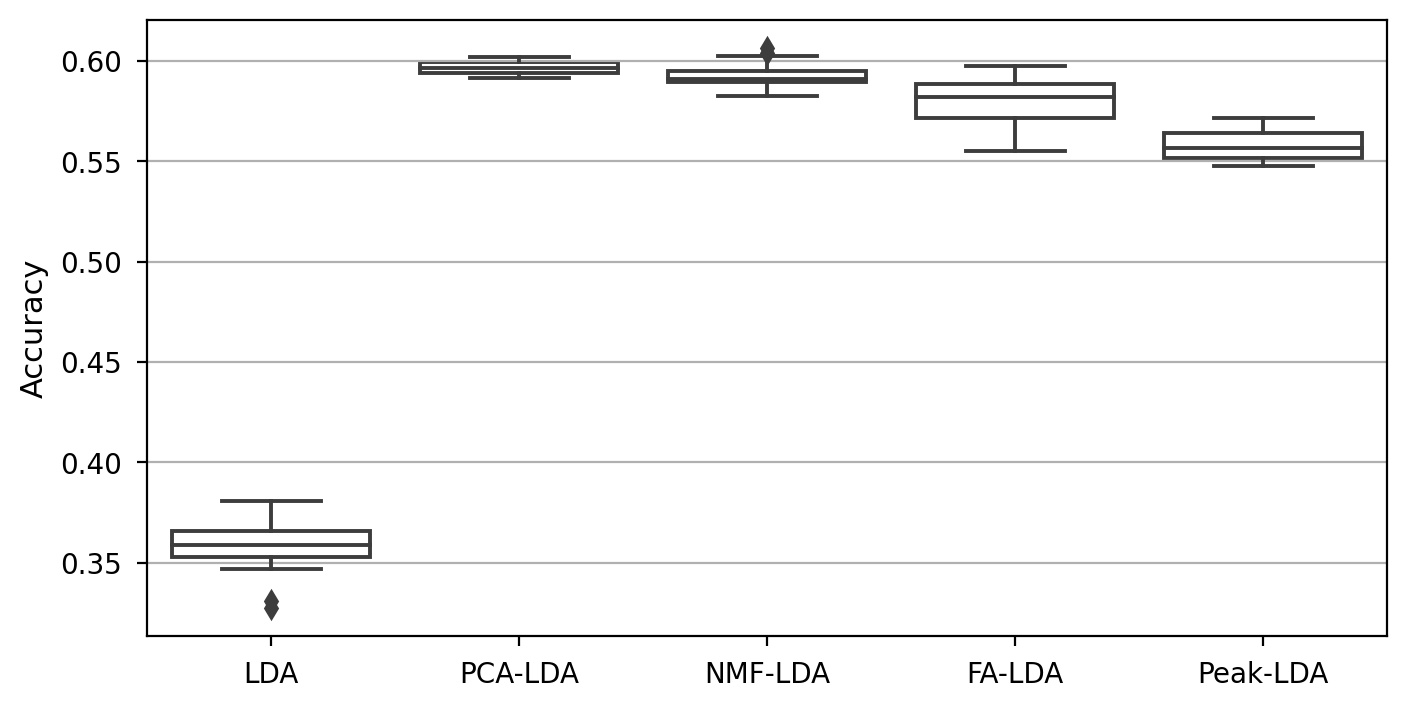

In [49]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(accs, regex="LDA")

ax.grid(axis="y")
ax.set_ylabel("Accuracy")

Text(0, 0.5, 'p-Value')

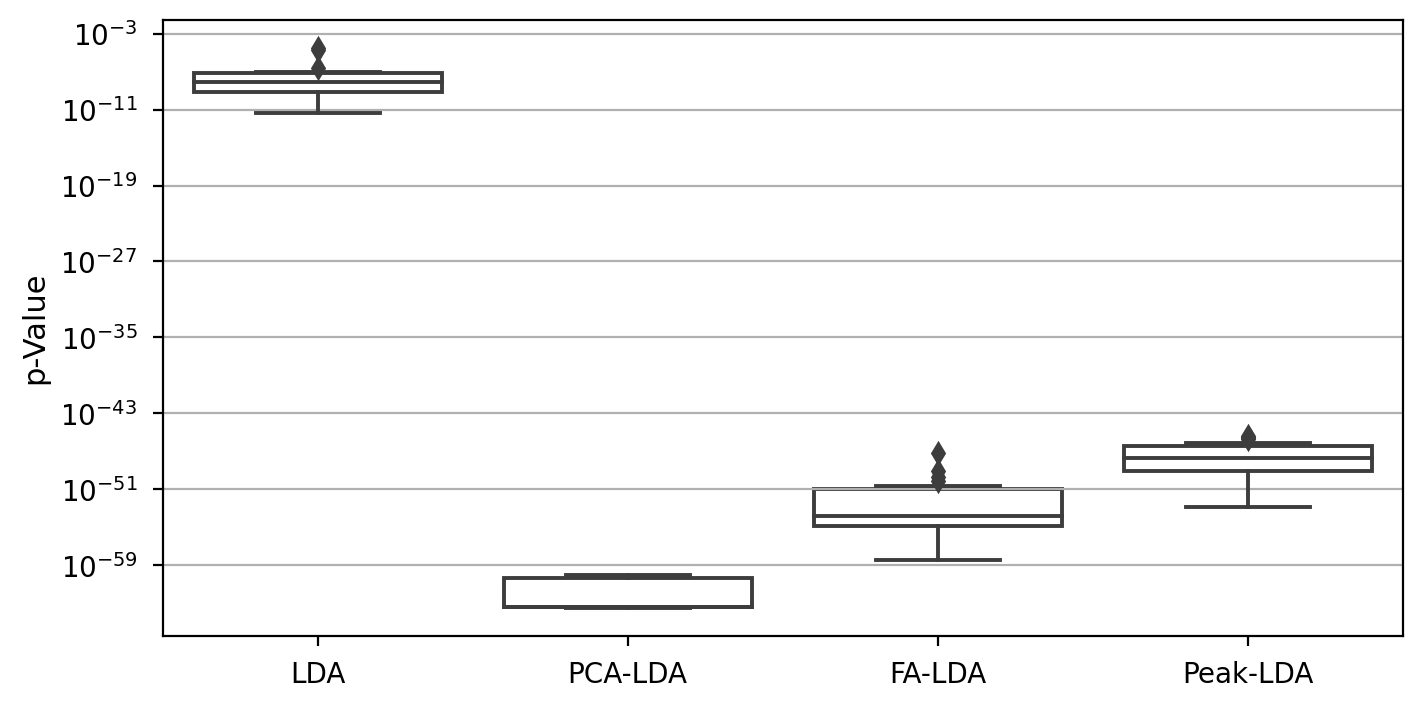

In [50]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(p_vals, regex="LDA")

ax.set_yscale("log")
ax.grid(axis="y")
ax.set_ylabel("p-Value")

Text(0, 0.5, 'Fit Time (s)')

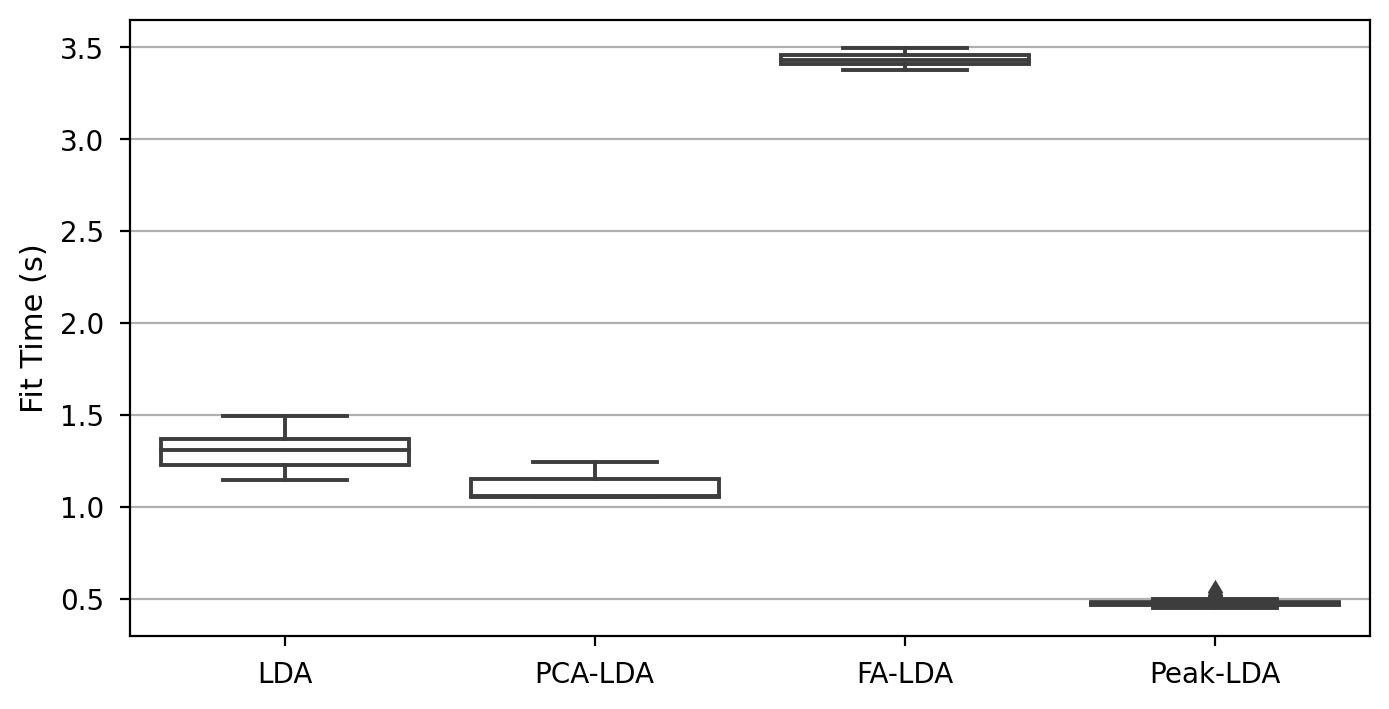

In [51]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(fit_times, regex="LDA")

ax.grid(axis="y")
ax.set_ylabel("Fit Time (s)")

Text(0, 0.5, 'Predict Time (s)')

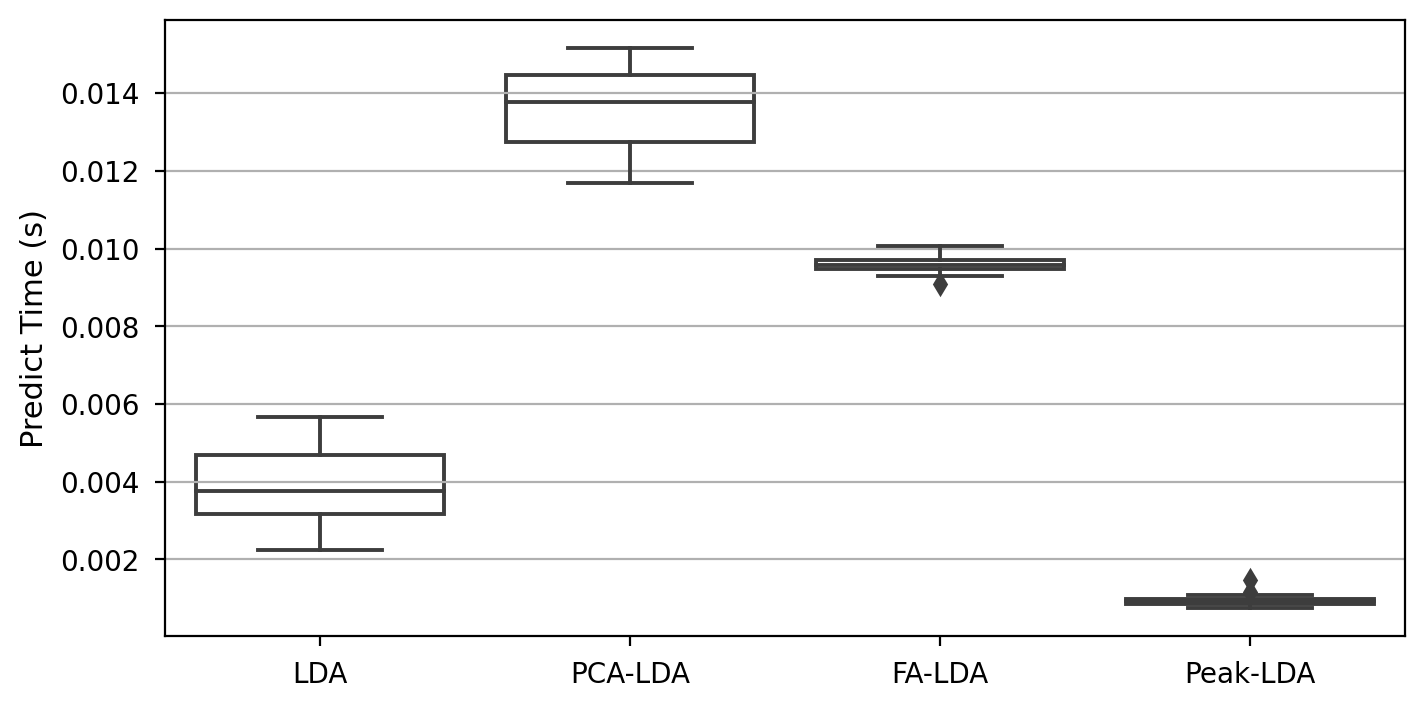

In [52]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(predict_times, regex="LDA")

ax.grid(axis="y")
ax.set_ylabel("Predict Time (s)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


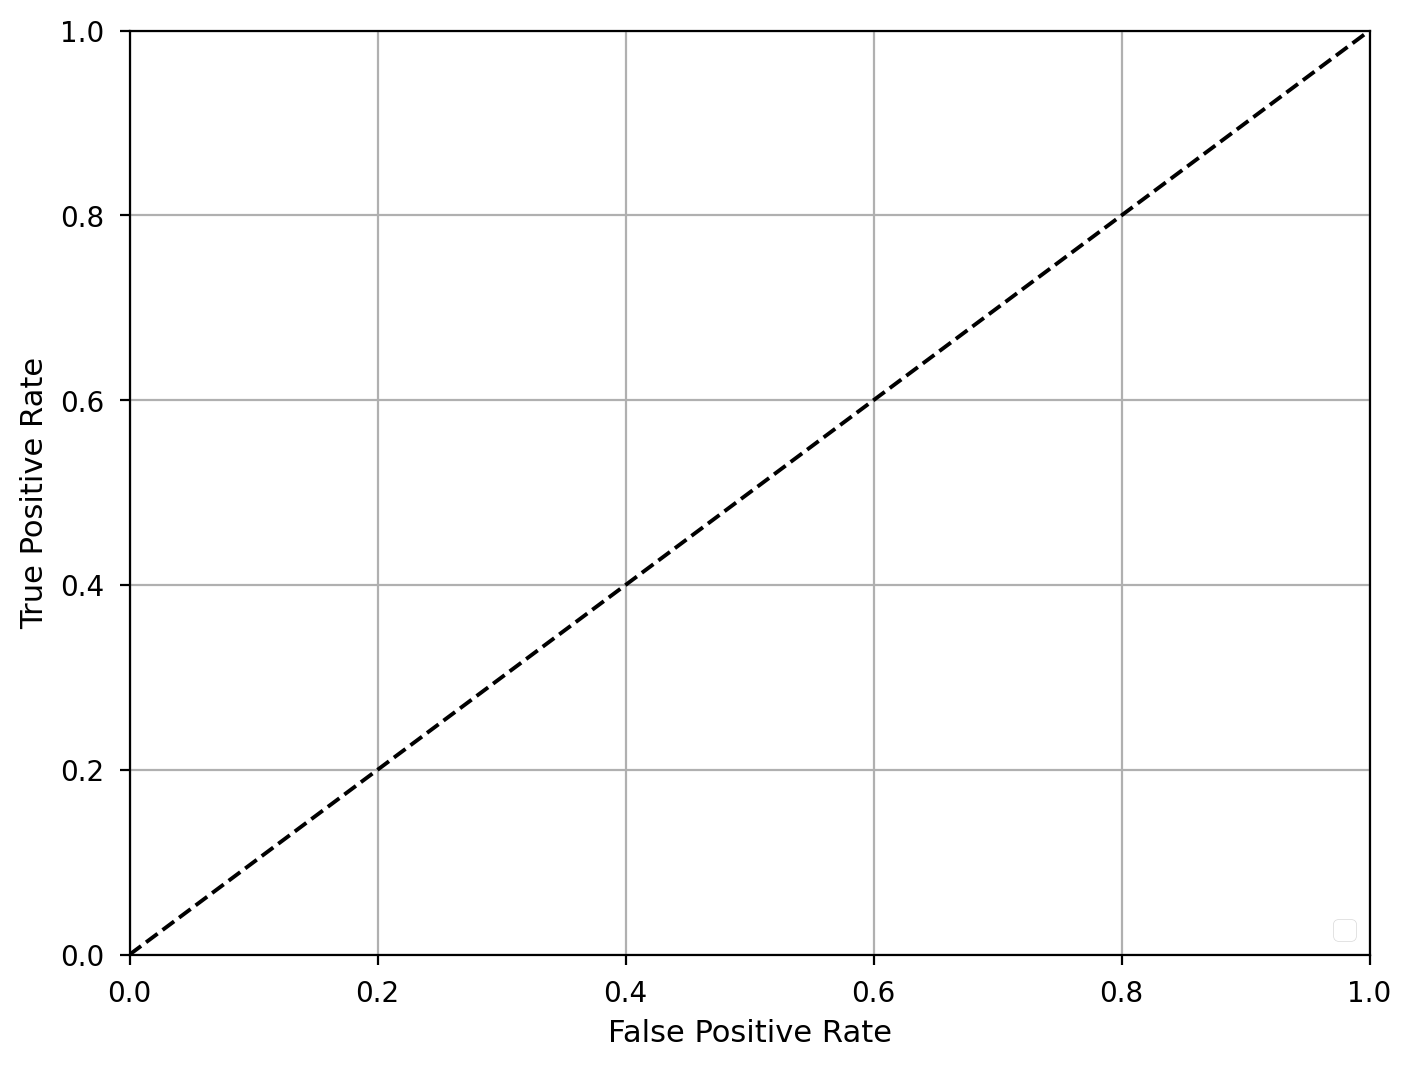

In [53]:
fig, ax = plt.subplots()
plot_roc_comparison(rocs, aucs, ax=ax, regex="LDA")

ax.grid()
ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

# Regularized Models
## Logistic Regression (l1)
### Overview

In [54]:
current_path = results_path / "regularized_models/logreg_l1/"
name = "Log. Reg. (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_accuracy  test_accuracy  fit_time  predict_time       p_value
count        5.000000       5.000000  5.000000      5.000000  5.000000e+00
mean         0.737500       0.520000  0.471903      0.011224  1.883108e-12
std          0.045586       0.017678  0.057234      0.003777  3.367589e-12
min          0.672500       0.505000  0.396400      0.004542  1.568573e-16
25%          0.707500       0.510000  0.432705      0.012481  2.585928e-13
50%          0.762500       0.515000  0.478773      0.012544  5.536747e-13
75%          0.765000       0.520000  0.524271      0.012705  7.159710e-13
max          0.780000       0.550000  0.527367      0.013849  7.887145e-12

### Validation Curve

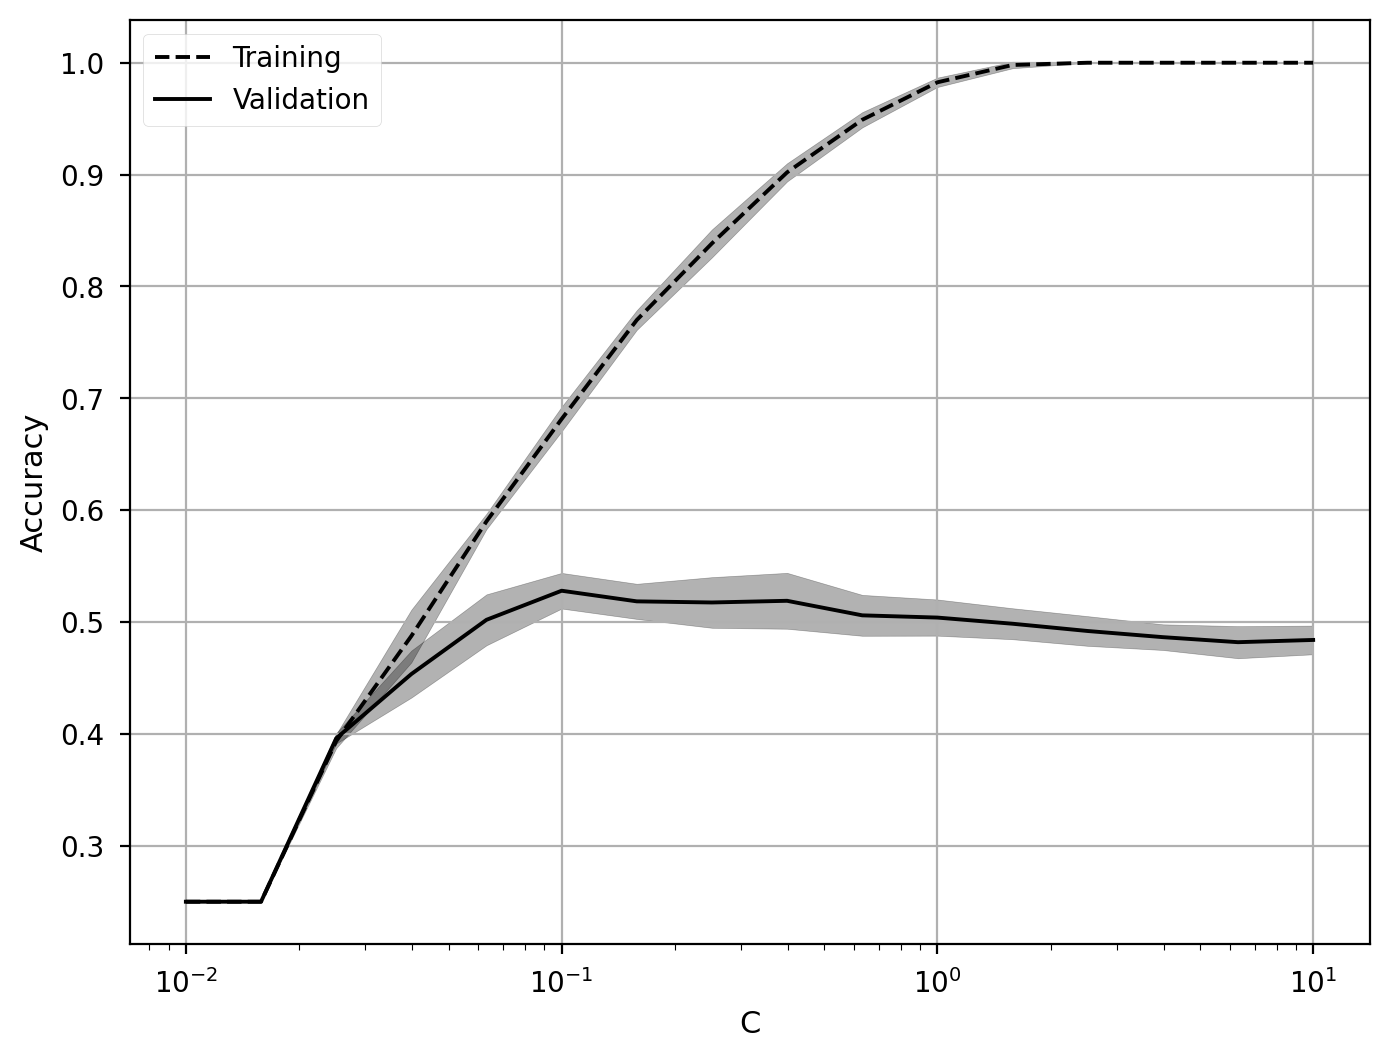

In [55]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

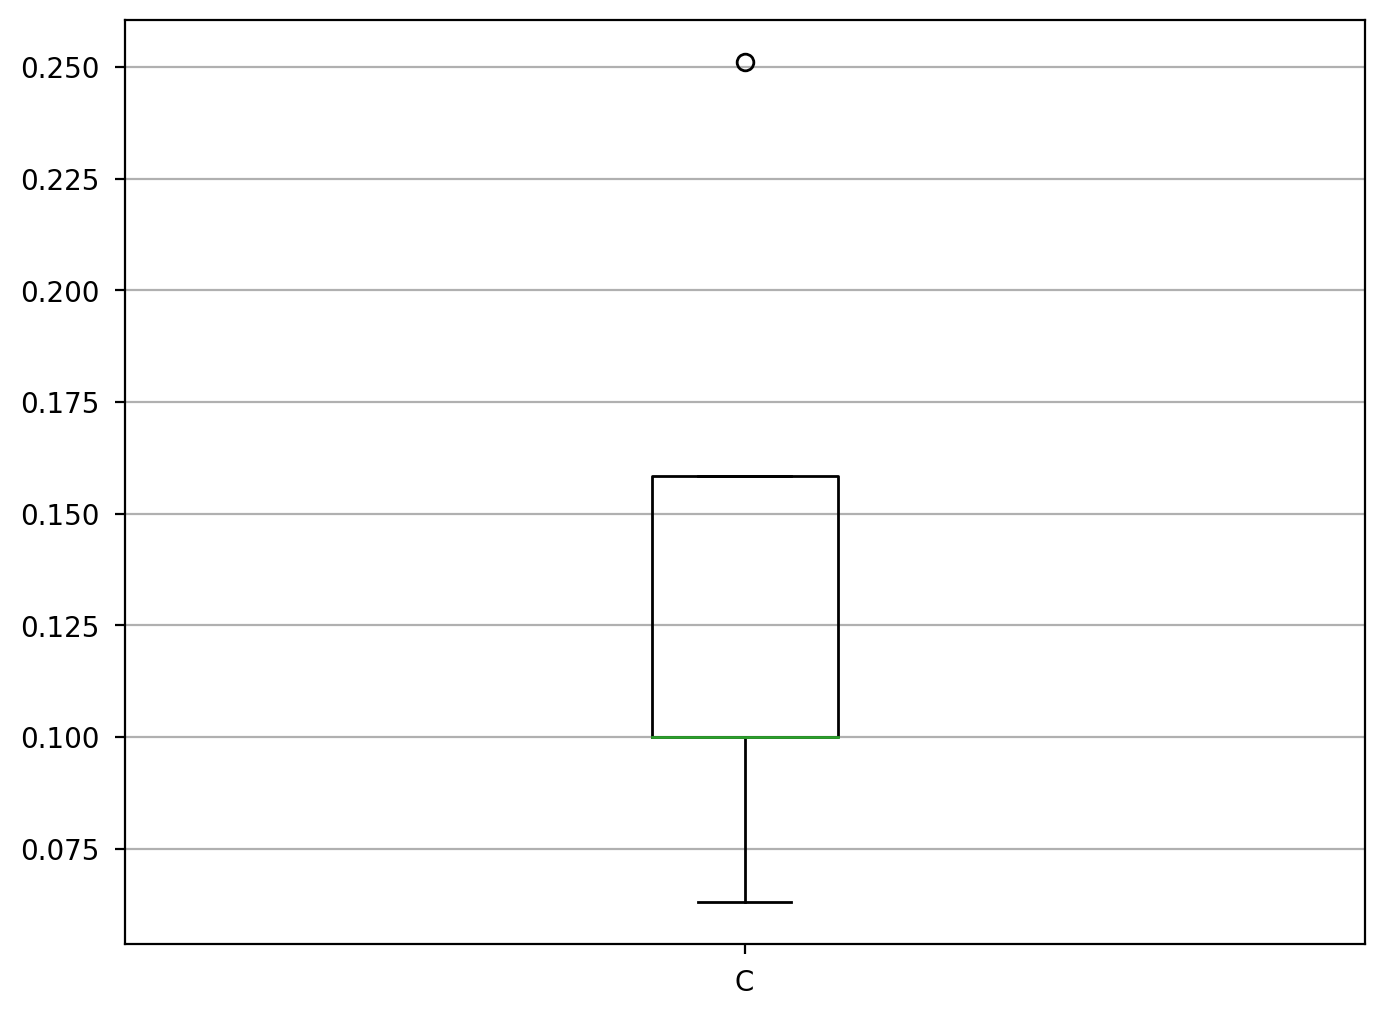

In [56]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["C"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

ValueError: Grouper and axis must be same length

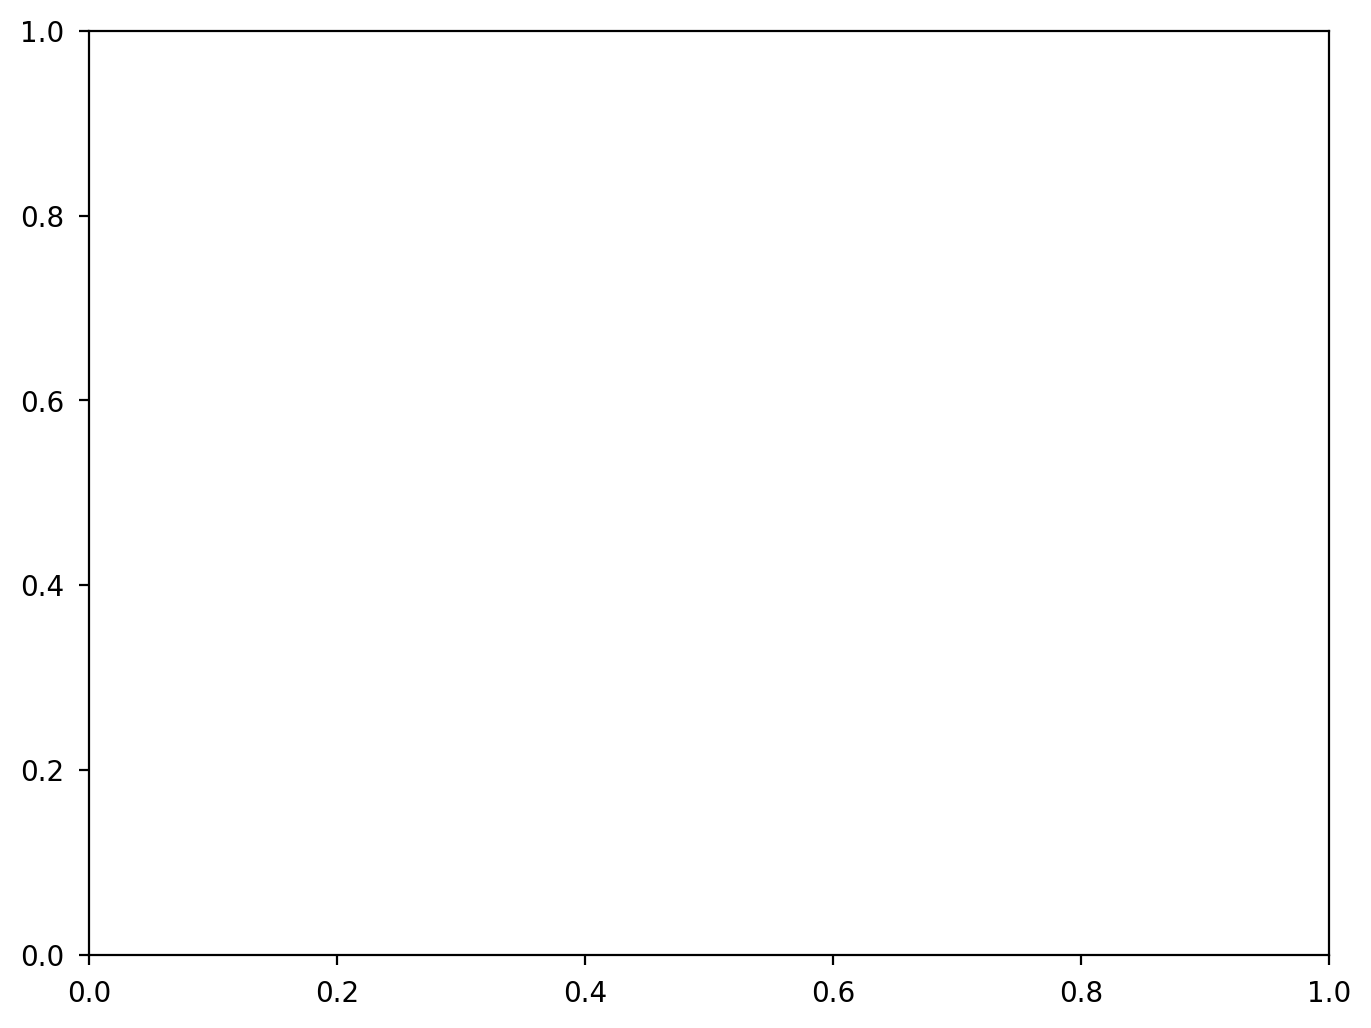

In [57]:
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(proba_df, y_key[y], y_key, ax=ax)
ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_yscale("logit")
ax.set_ylabel("Probability (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

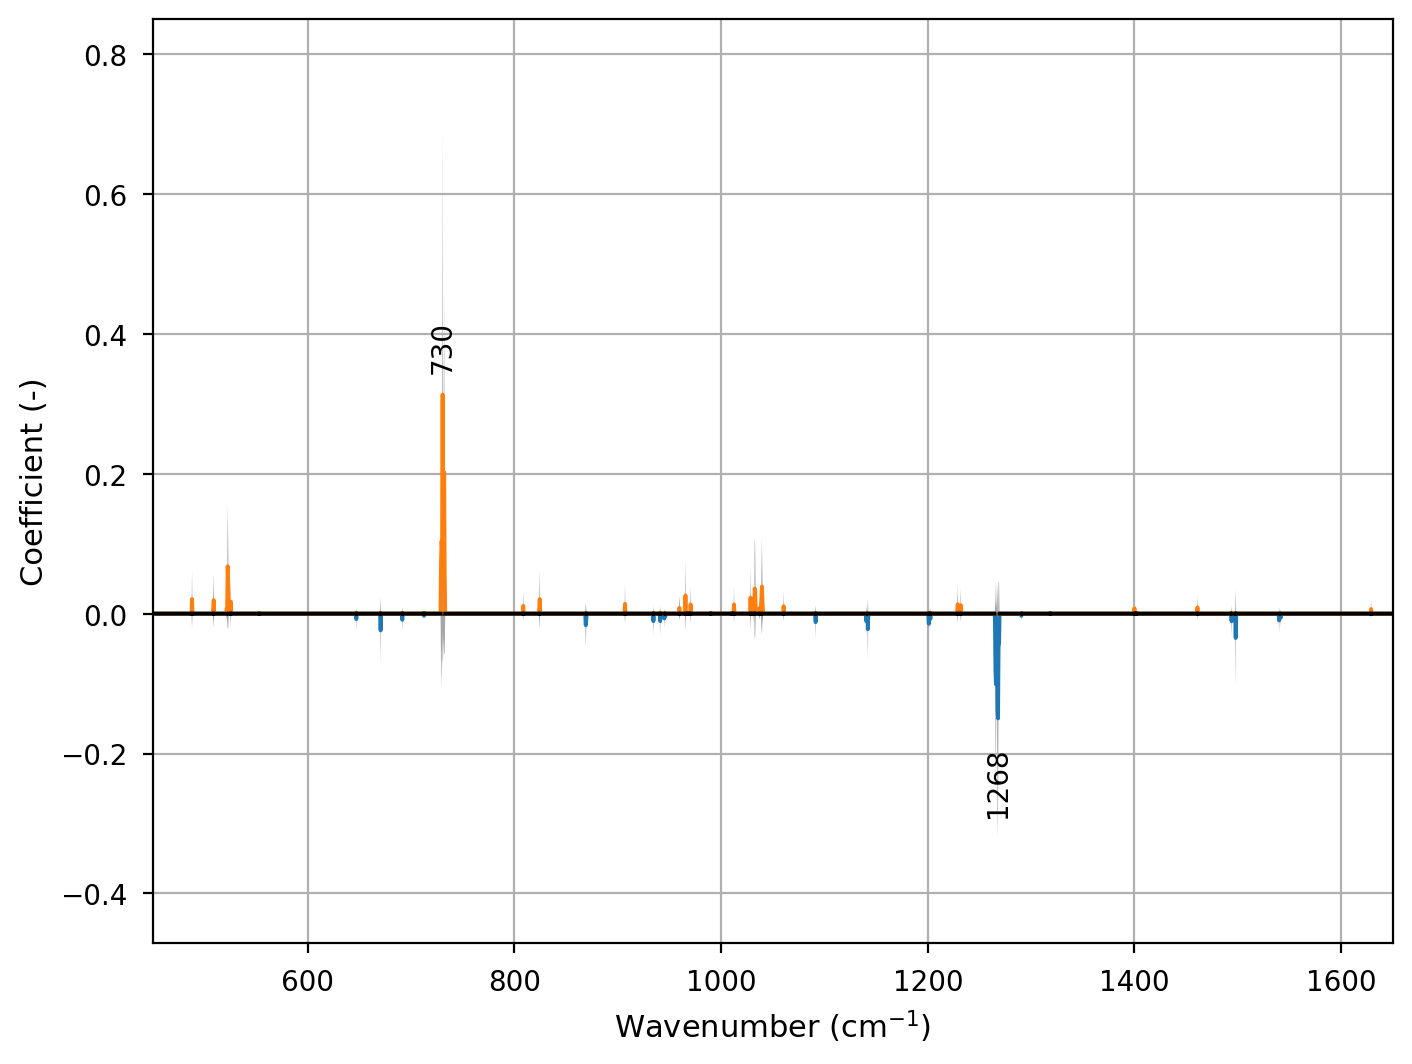

In [58]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.075, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

ValueError: Found input variables with inconsistent numbers of samples: [1200, 400]

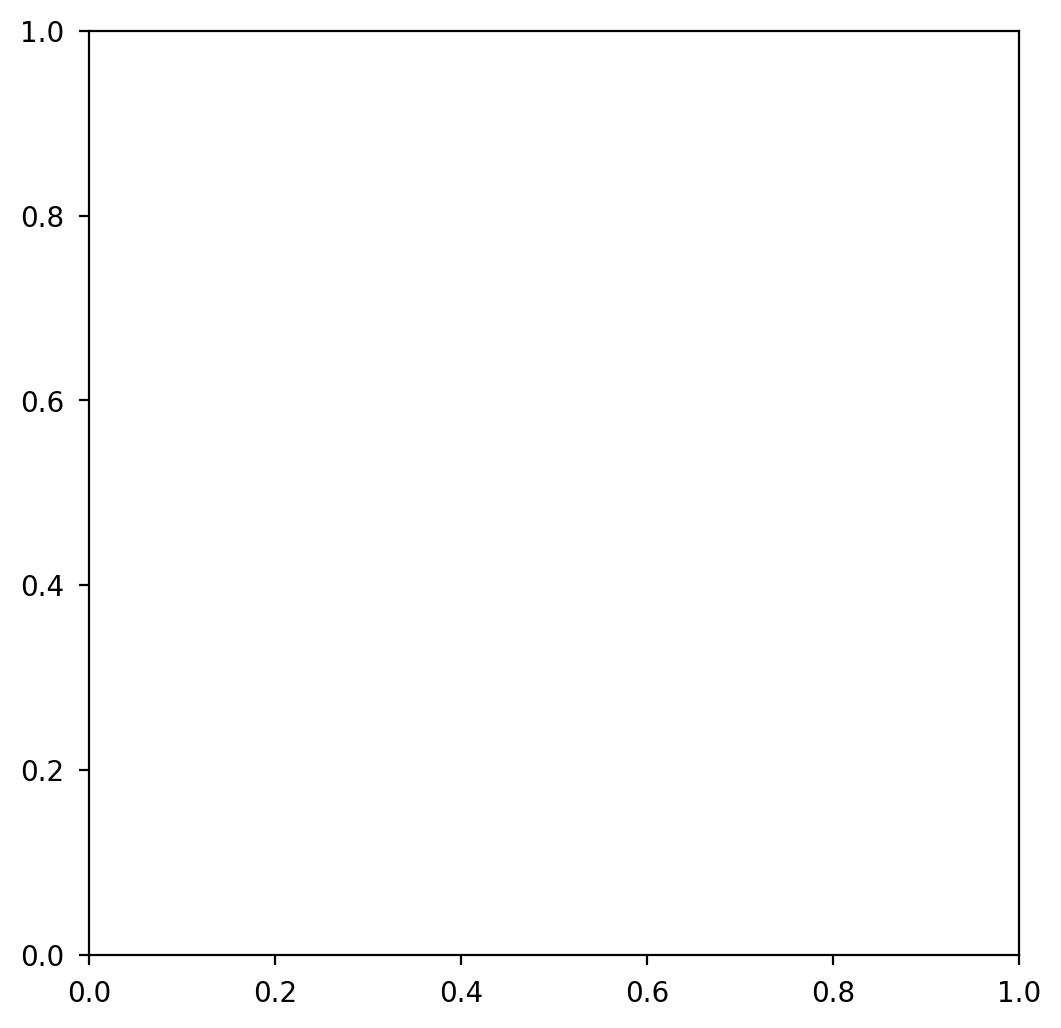

In [59]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

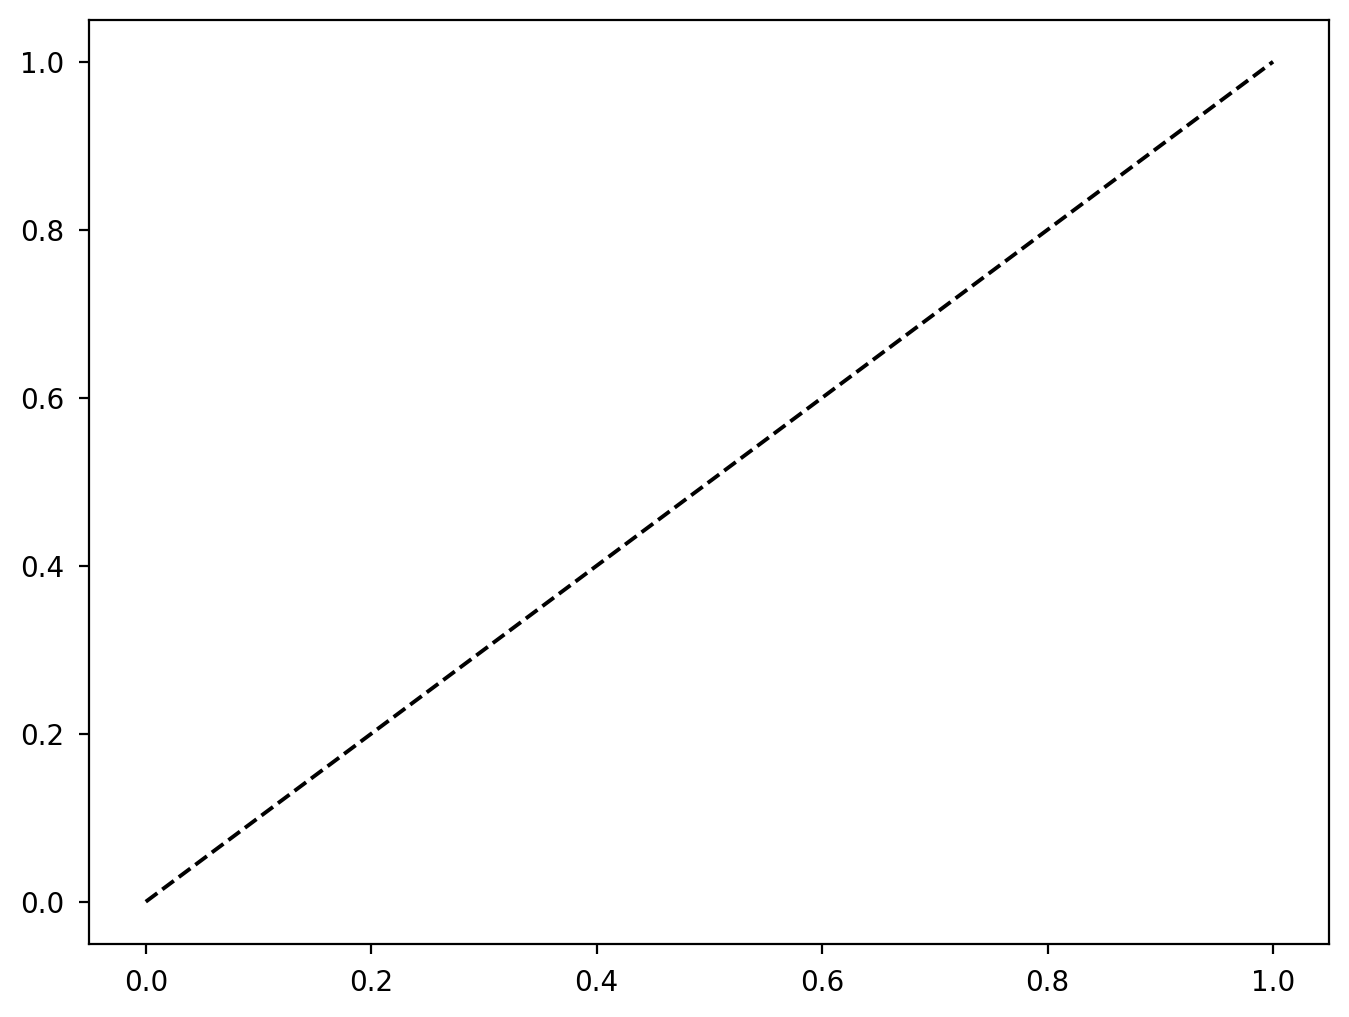

In [60]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(proba_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Logistic Regression (l2)
### Overview

In [61]:
current_path = results_path / "regularized_models/logreg_l2/"
name = "Log. Reg. (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_accuracy  test_accuracy  fit_time  predict_time       p_value
count          5.0000       5.000000  5.000000      5.000000  5.000000e+00
mean           0.7715       0.489500  0.994296      0.012459  1.870448e-10
std            0.0294       0.016336  0.075112      0.005238  1.818040e-10
min            0.7400       0.470000  0.917554      0.008486  4.883590e-13
25%            0.7525       0.480000  0.932122      0.008793  1.882606e-11
50%            0.7625       0.487500  0.975730      0.009293  1.874639e-10
75%            0.7900       0.497500  1.067227      0.015401  3.079838e-10
max            0.8125       0.512500  1.078847      0.020324  4.204618e-10

### Validation Curve

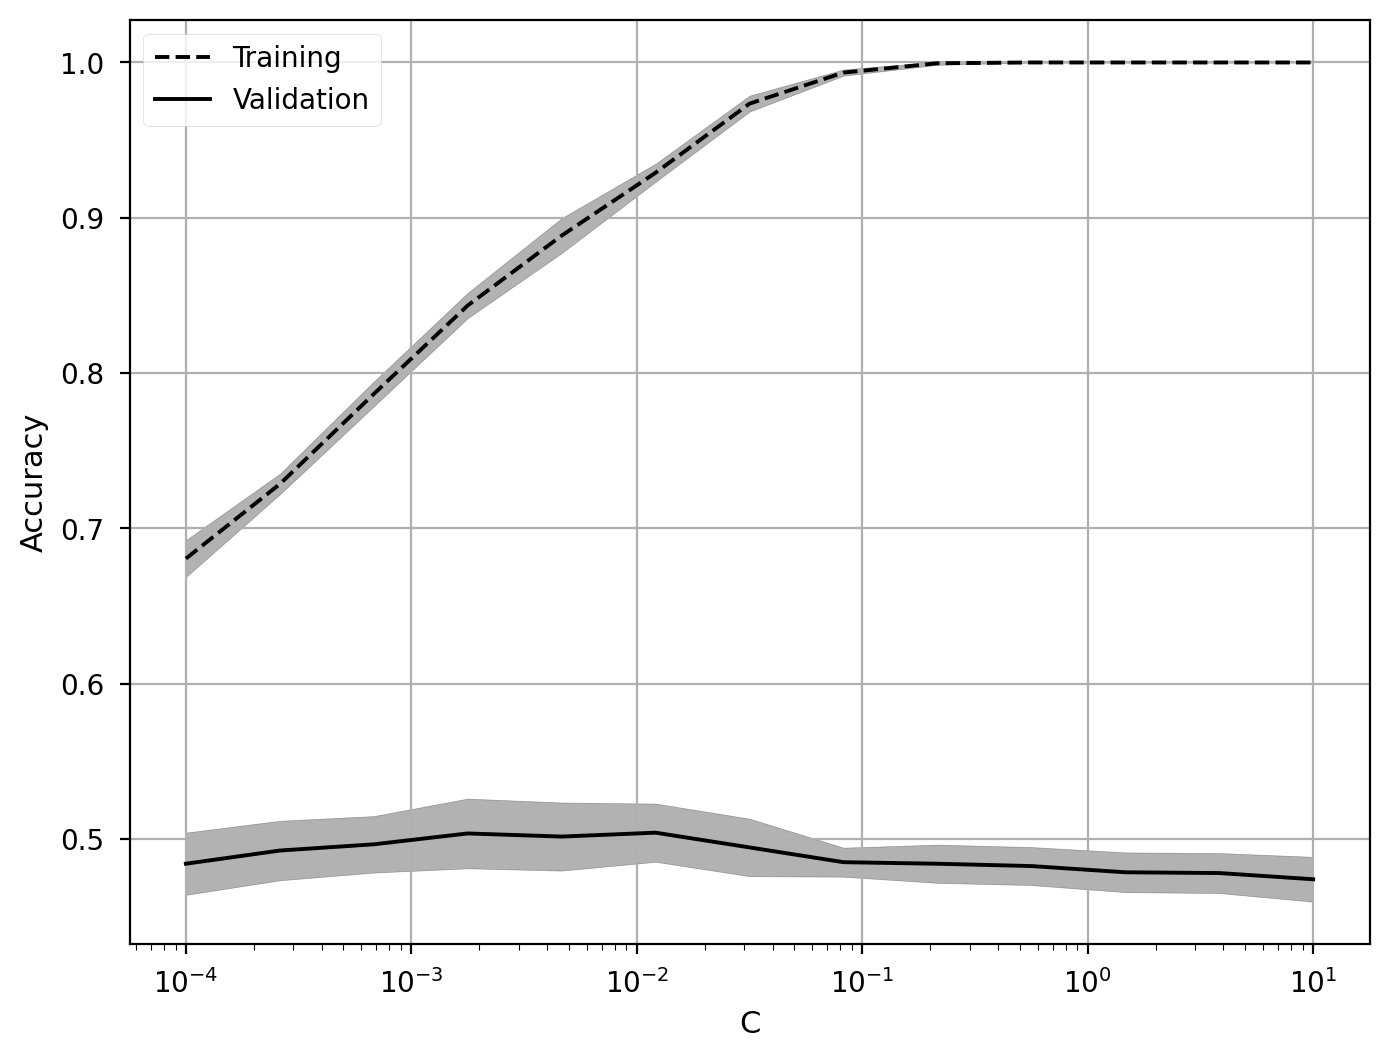

In [62]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

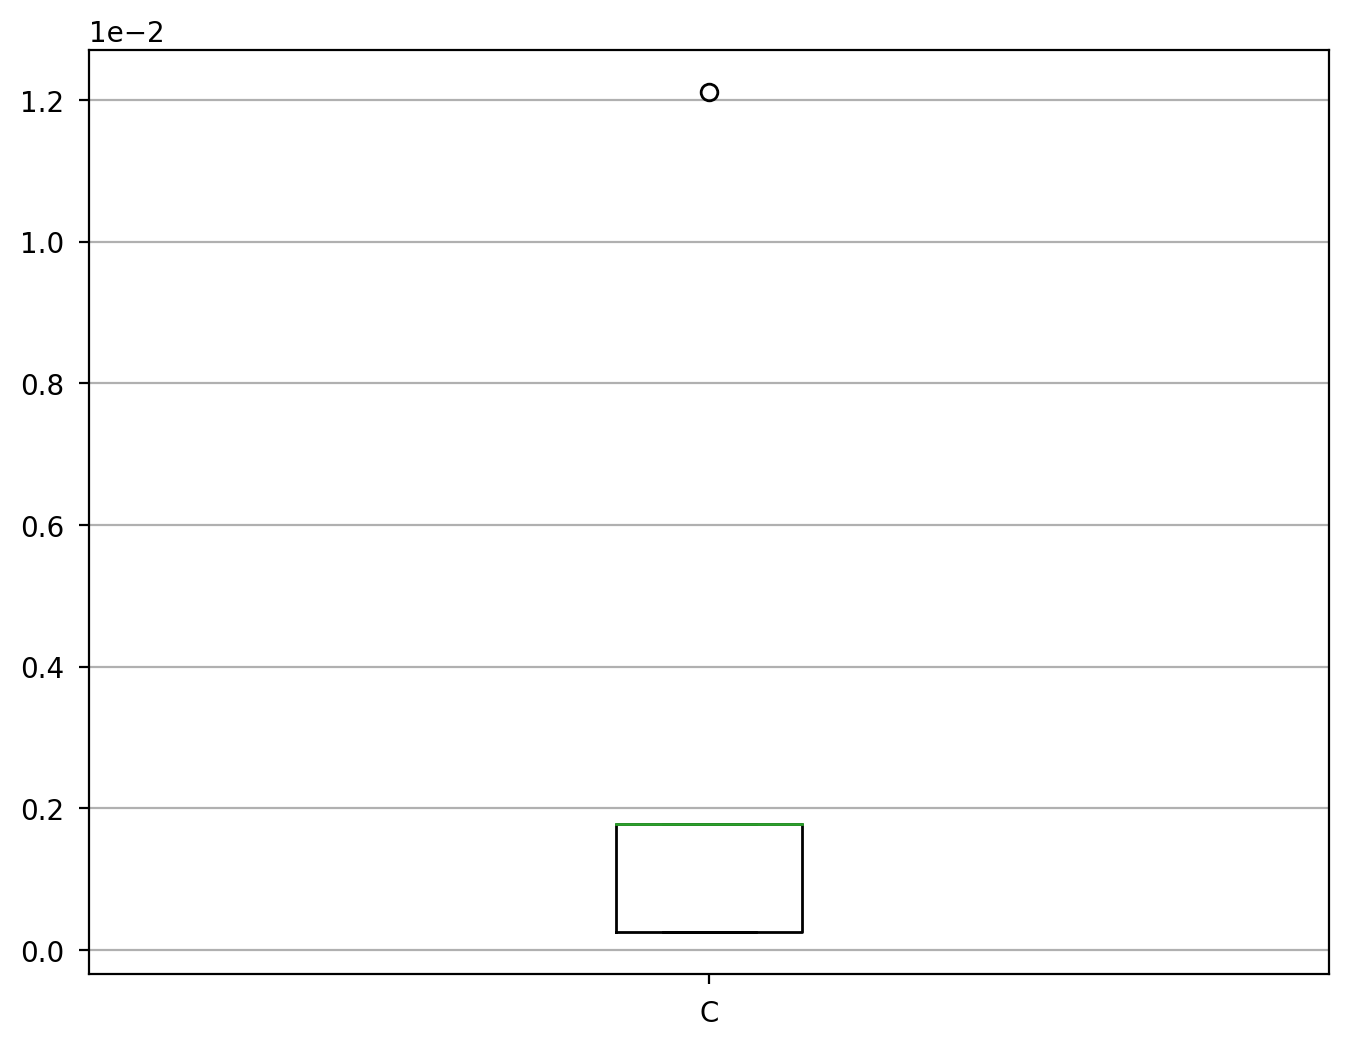

In [63]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["C"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

ValueError: Grouper and axis must be same length

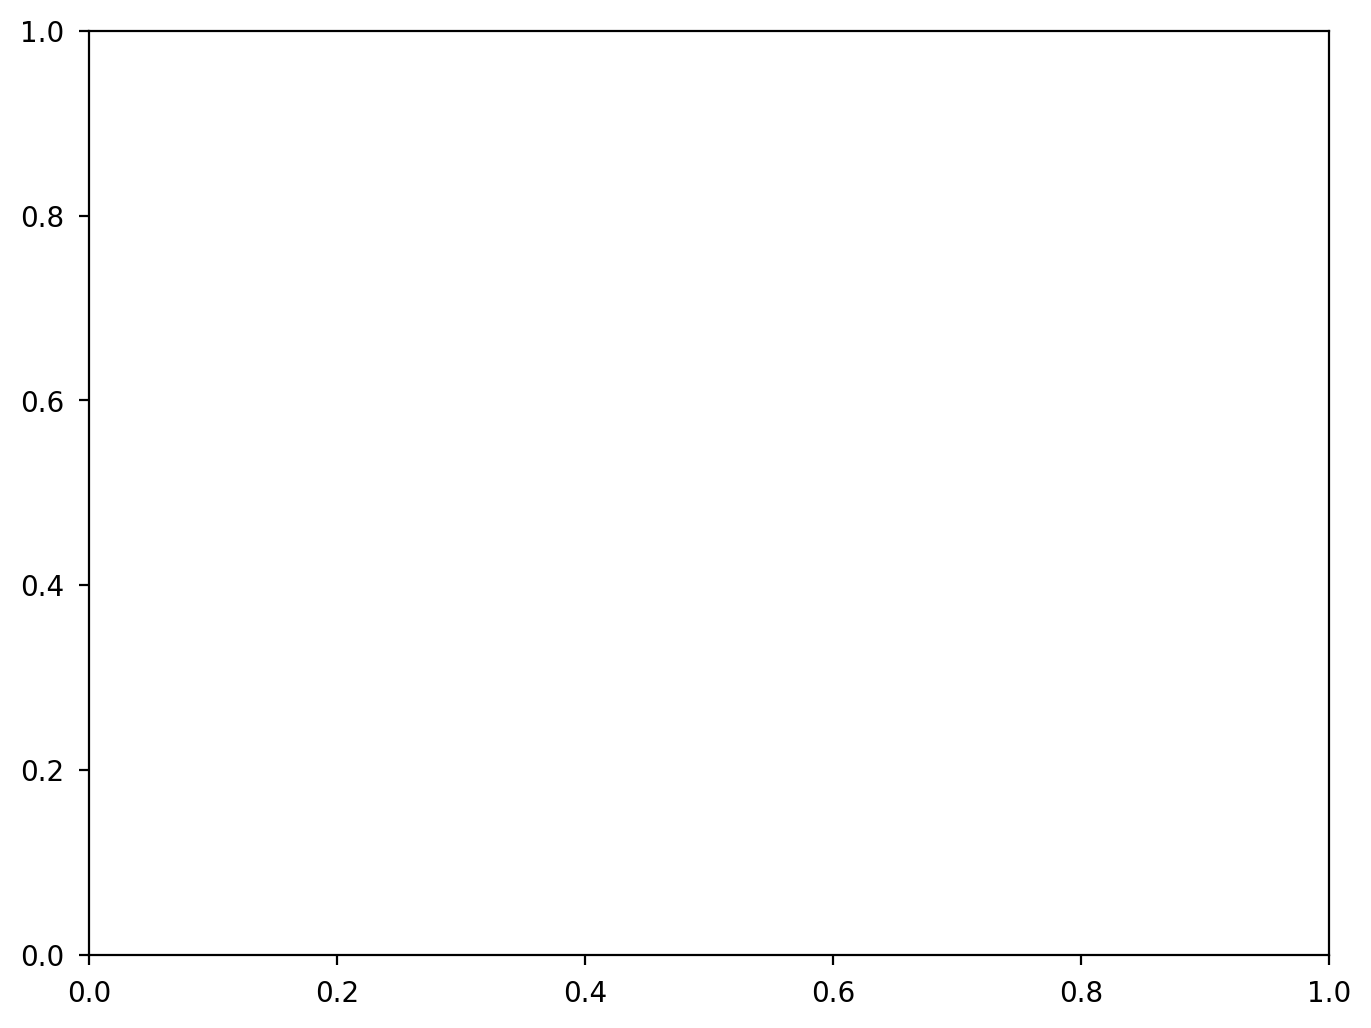

In [64]:
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(proba_df, y_key[y], y_key, ax=ax)
ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_yscale("logit")
ax.set_ylabel("Probability (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

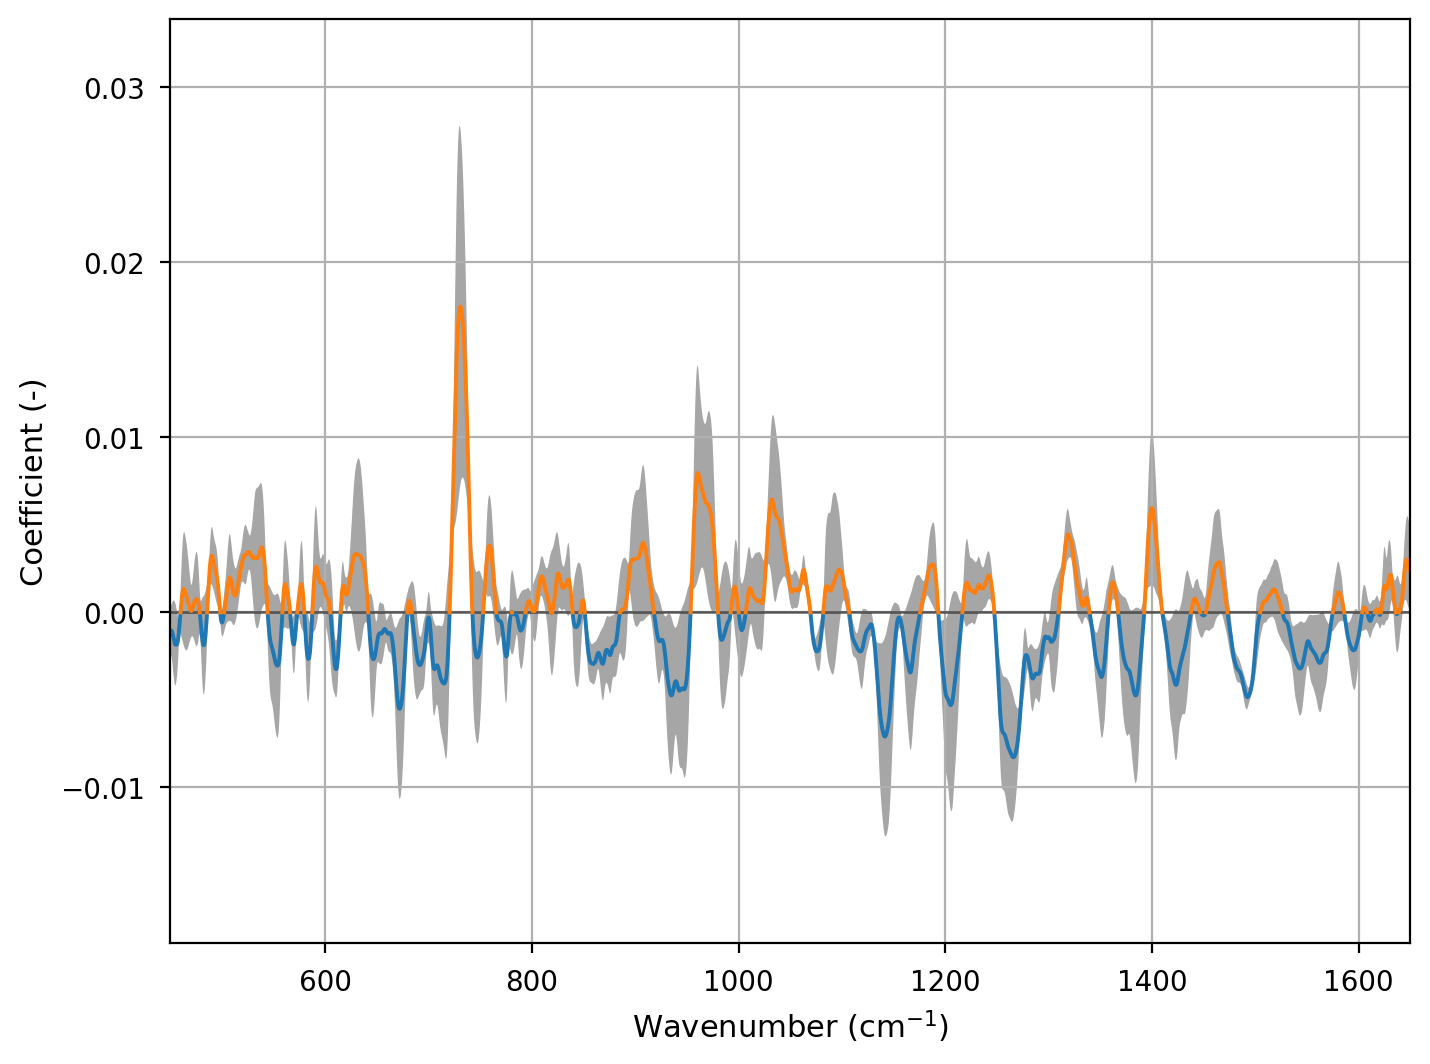

In [65]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True)

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

ValueError: Found input variables with inconsistent numbers of samples: [1200, 400]

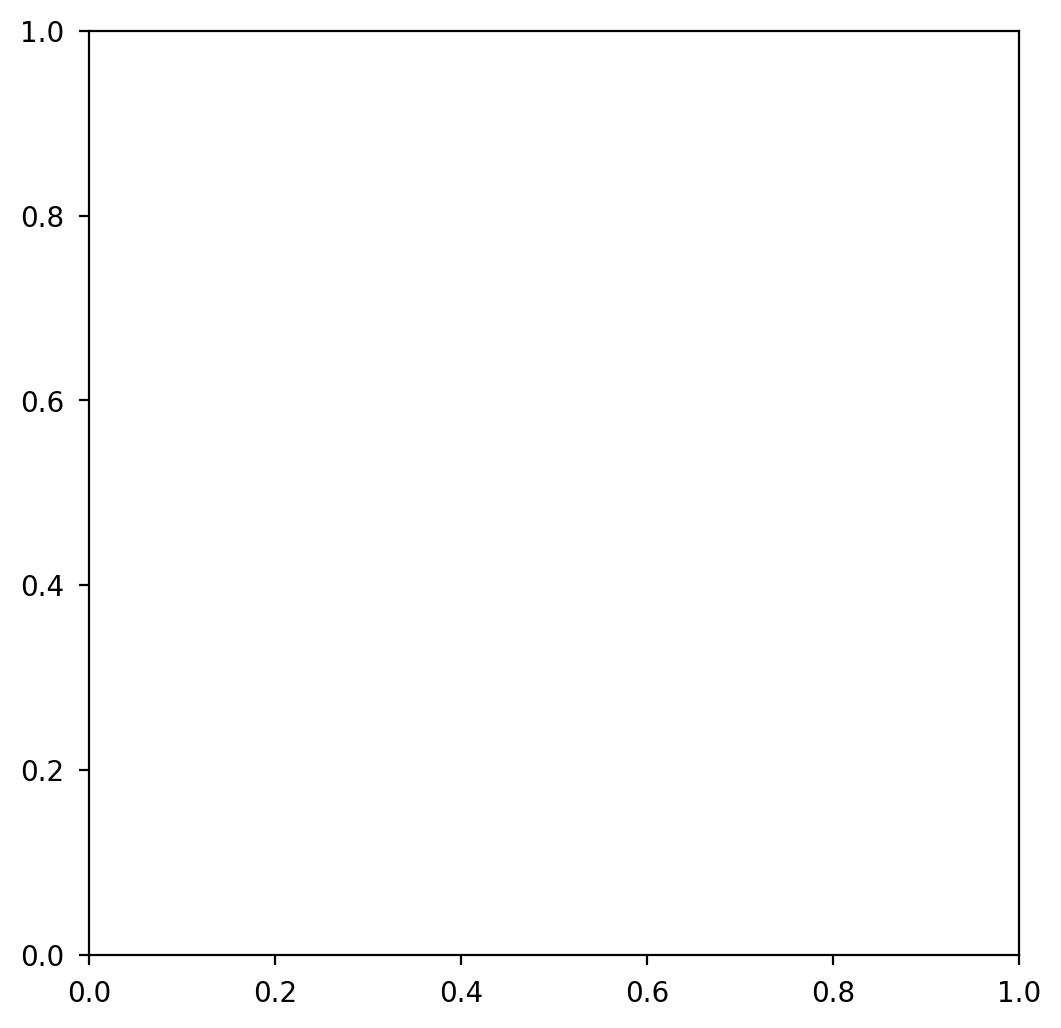

In [66]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

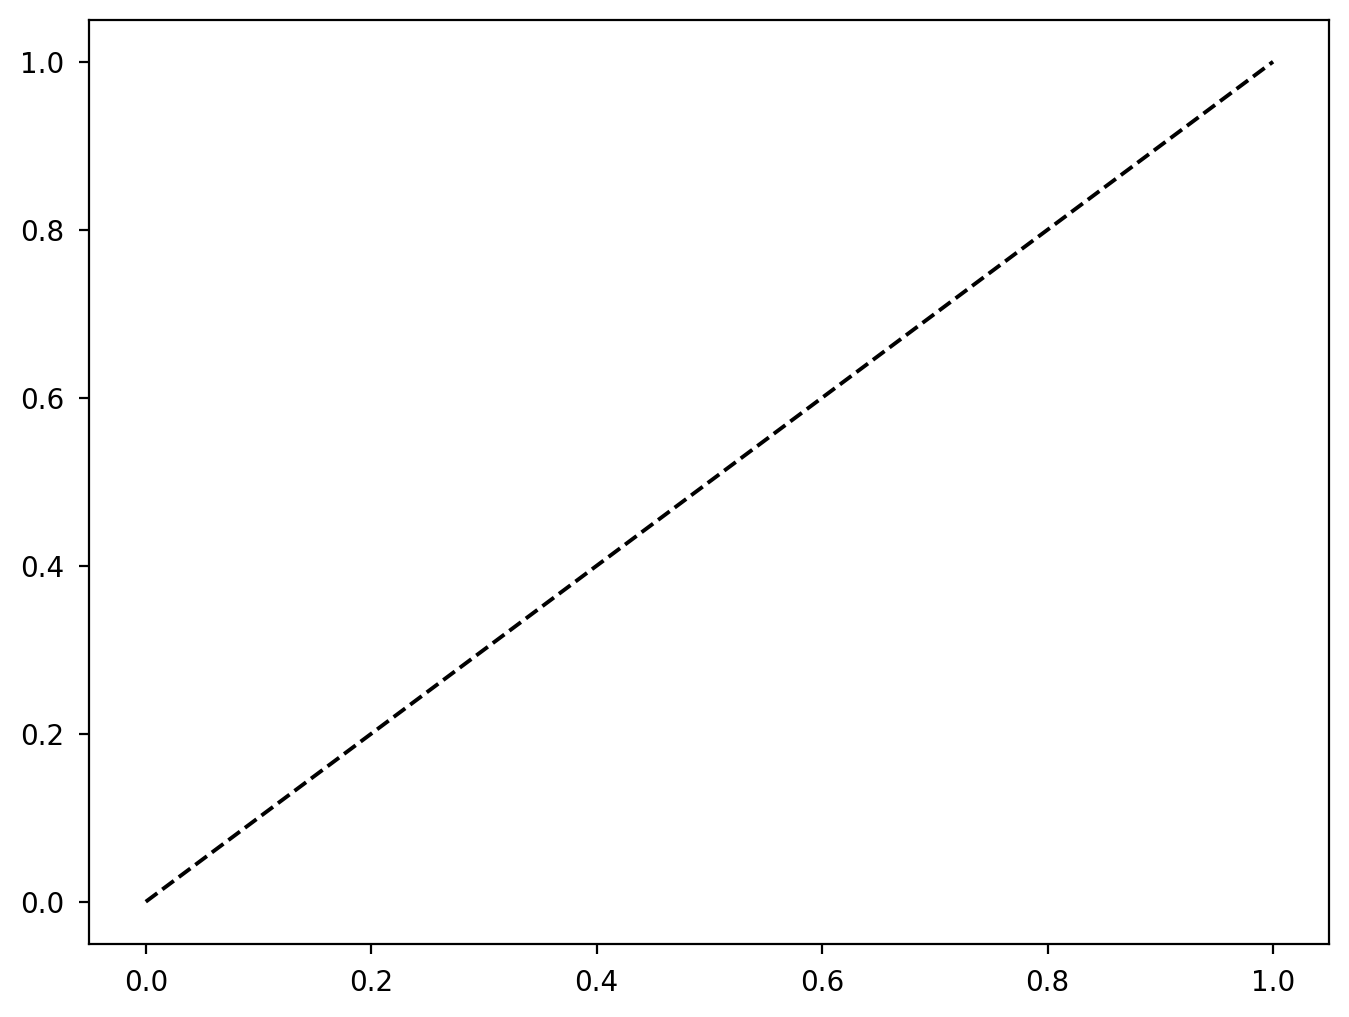

In [67]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(proba_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Support Vector Machine (l1)
### Overview

In [68]:
current_path = results_path / "regularized_models/svm_l1/"
name = "SVM (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_accuracy  test_accuracy  fit_time  predict_time       p_value
count        5.000000       5.000000  5.000000      5.000000  5.000000e+00
mean         0.764000       0.514500  2.819147      0.011114  1.152348e-11
std          0.059885       0.021462  0.372155      0.004054  1.933752e-11
min          0.680000       0.490000  2.489364      0.005178  3.460068e-15
25%          0.737500       0.497500  2.566460      0.008712  5.666794e-15
50%          0.762500       0.512500  2.700934      0.013282  6.299843e-13
75%          0.807500       0.535000  2.922570      0.013496  1.211767e-11
max          0.832500       0.537500  3.416405      0.014902  4.486064e-11

### Validation Curve

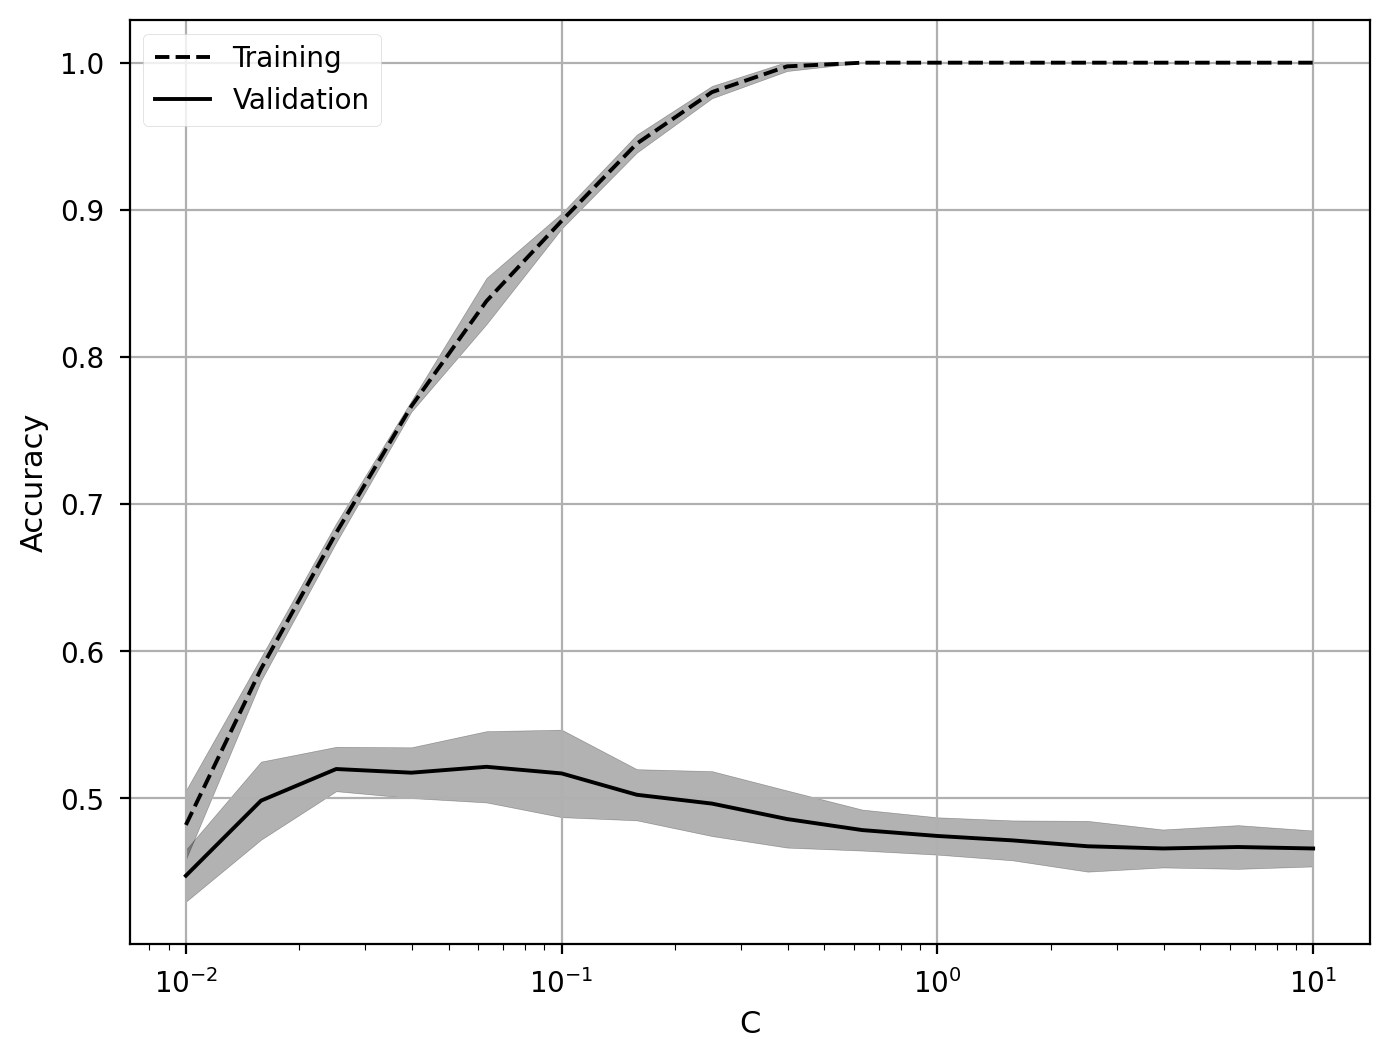

In [69]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

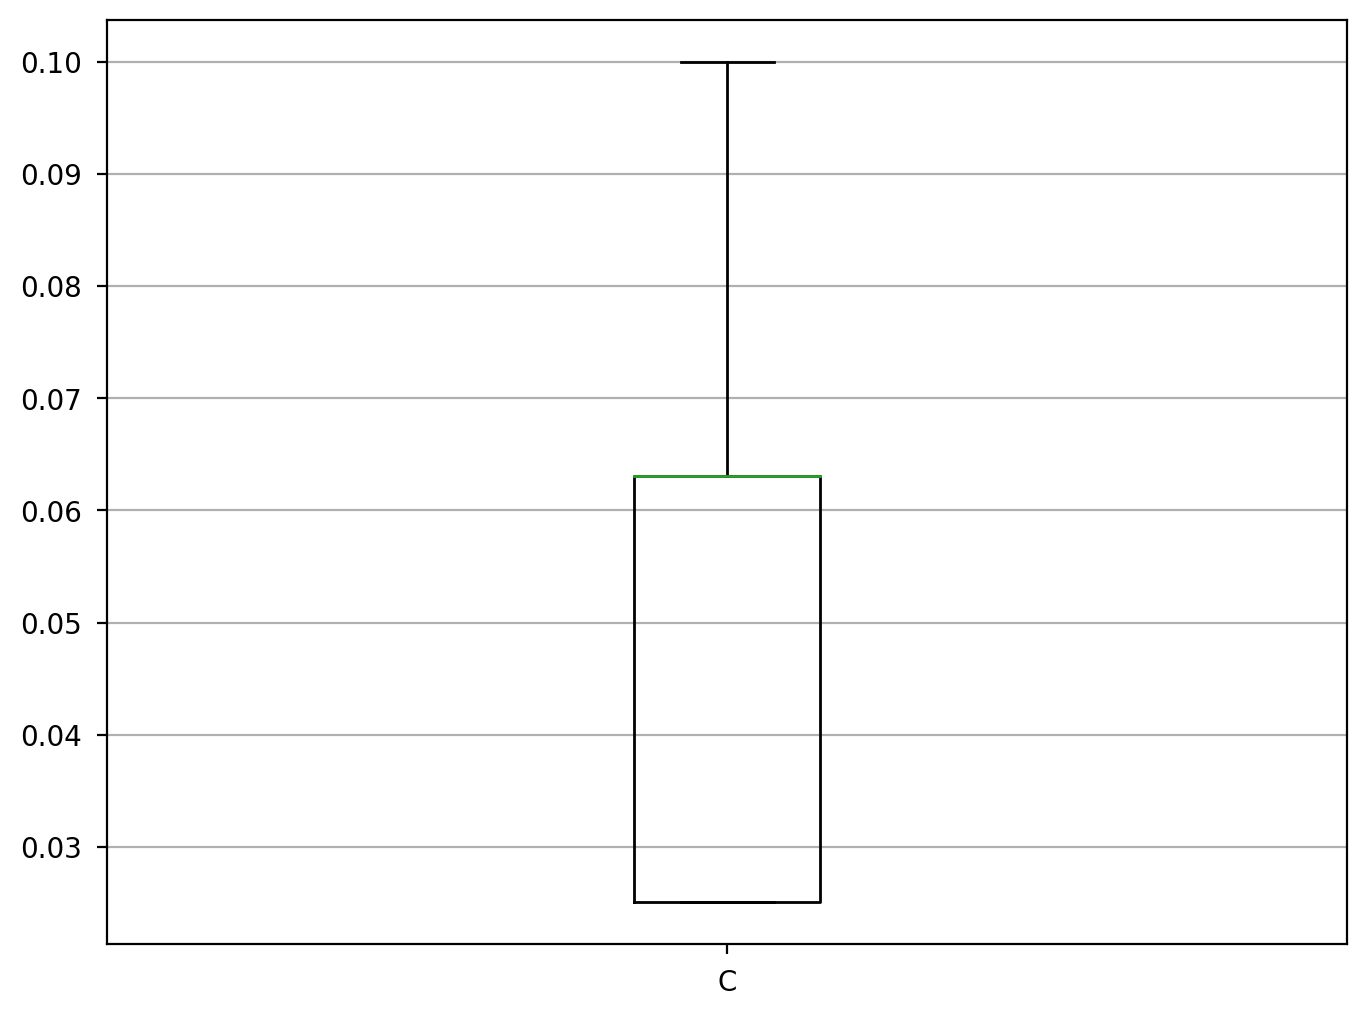

In [70]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["C"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

ValueError: Grouper and axis must be same length

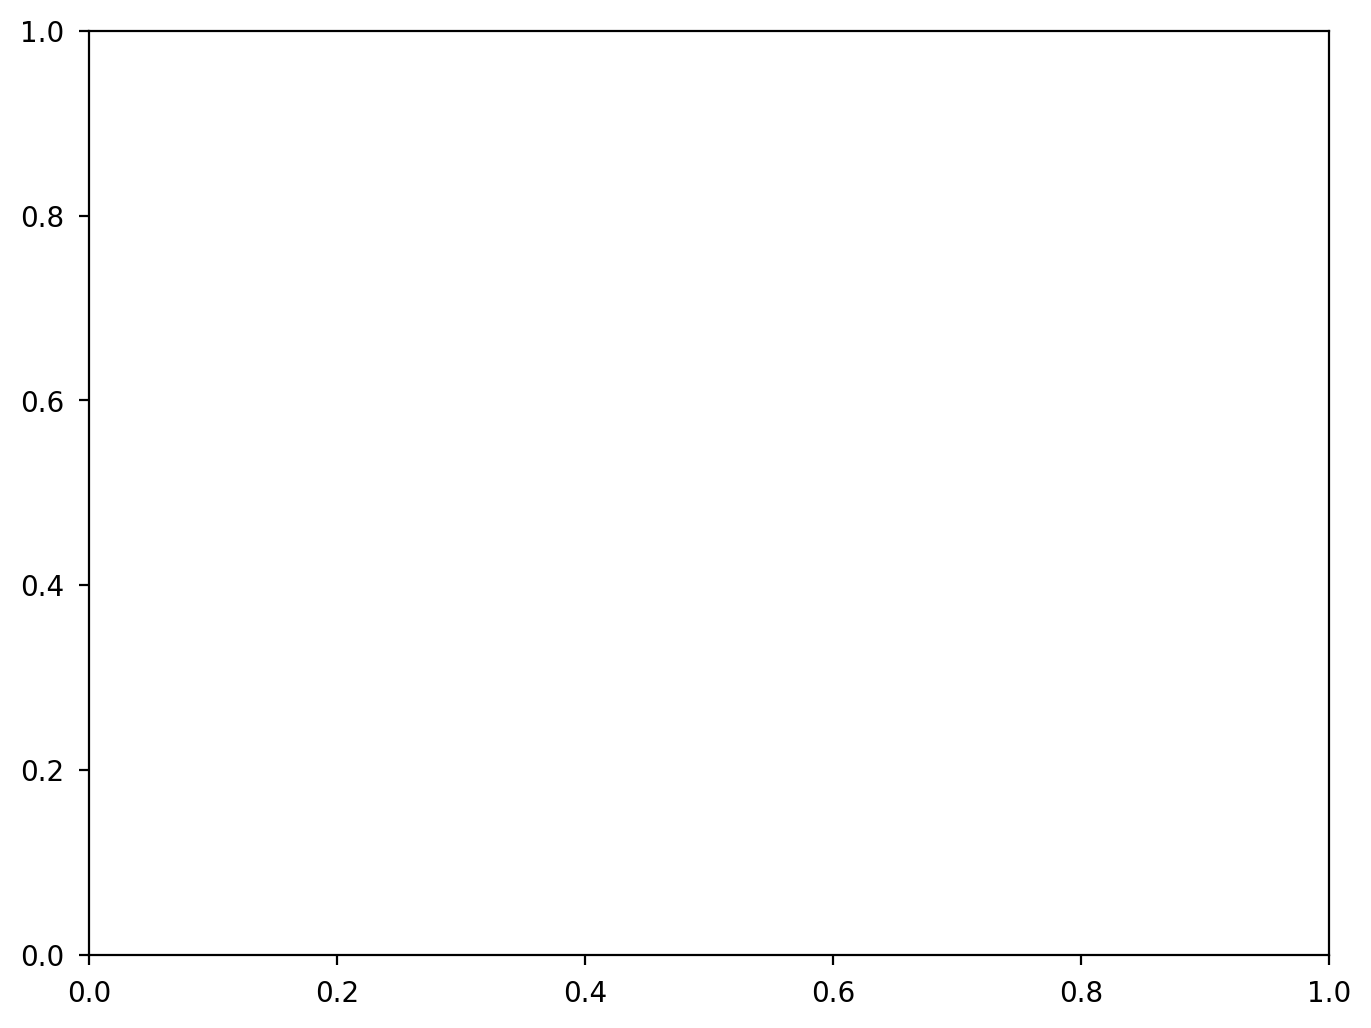

In [71]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

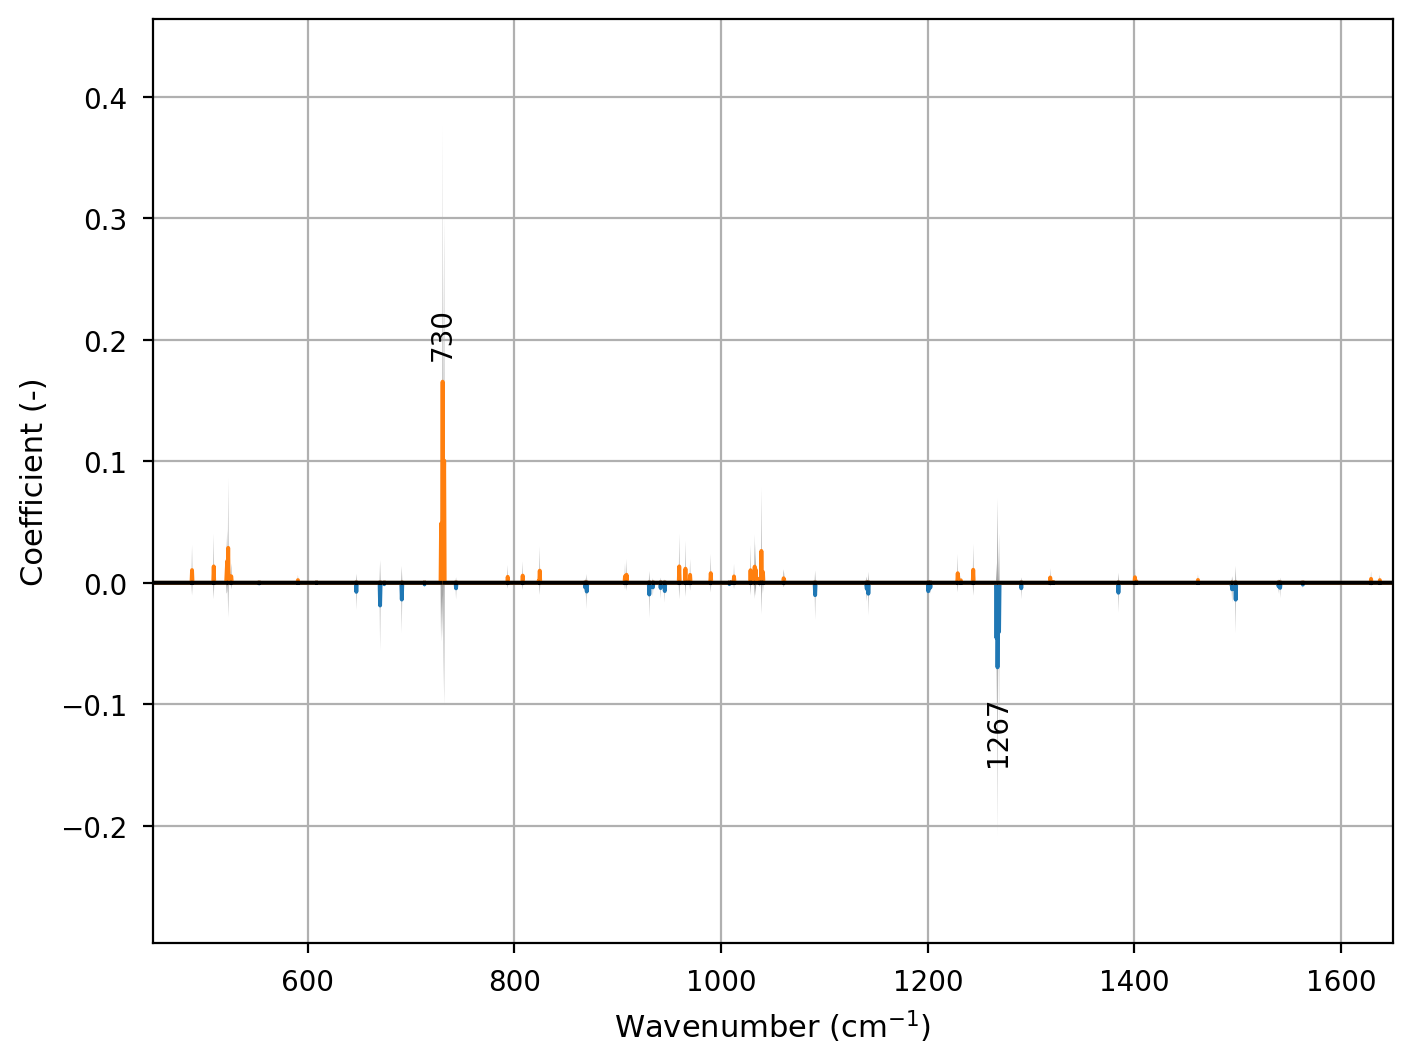

In [72]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.03, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

ValueError: Found input variables with inconsistent numbers of samples: [1200, 400]

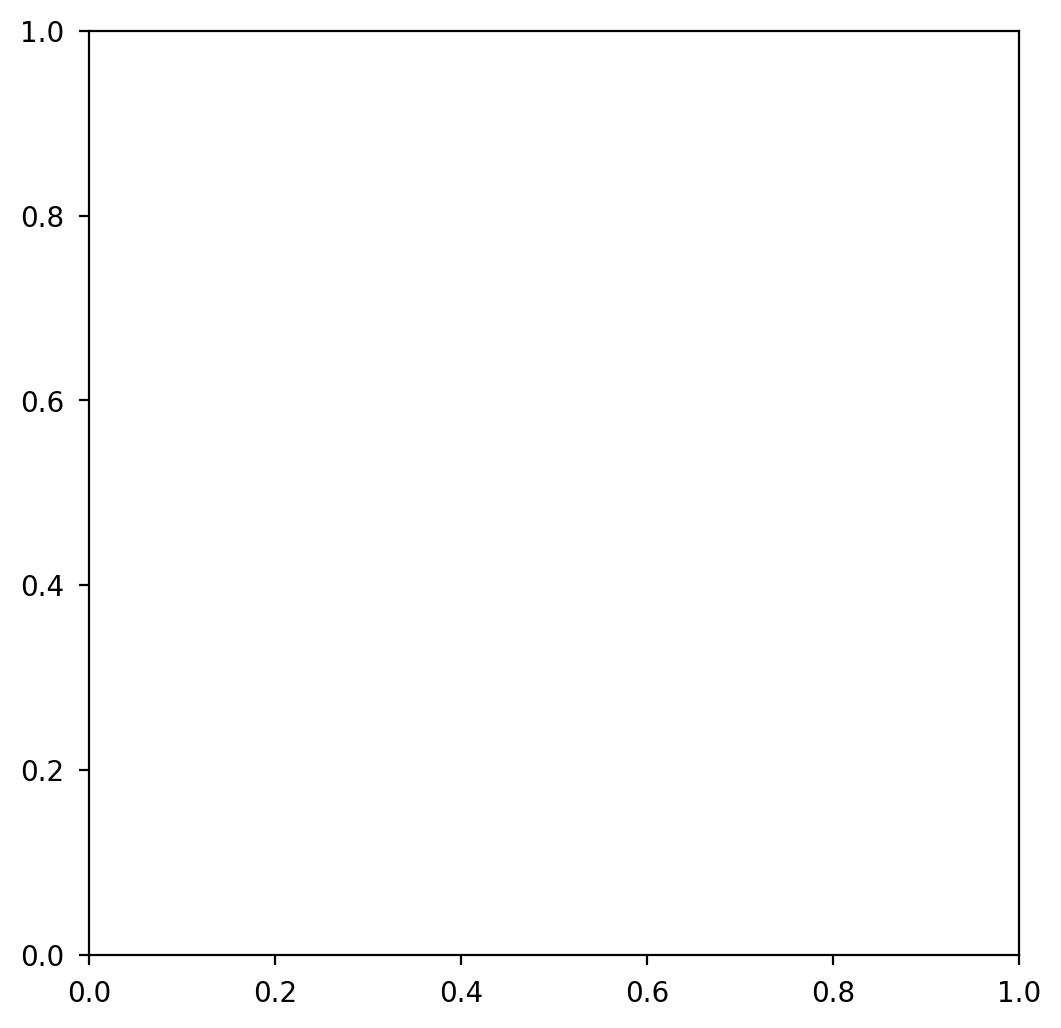

In [73]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

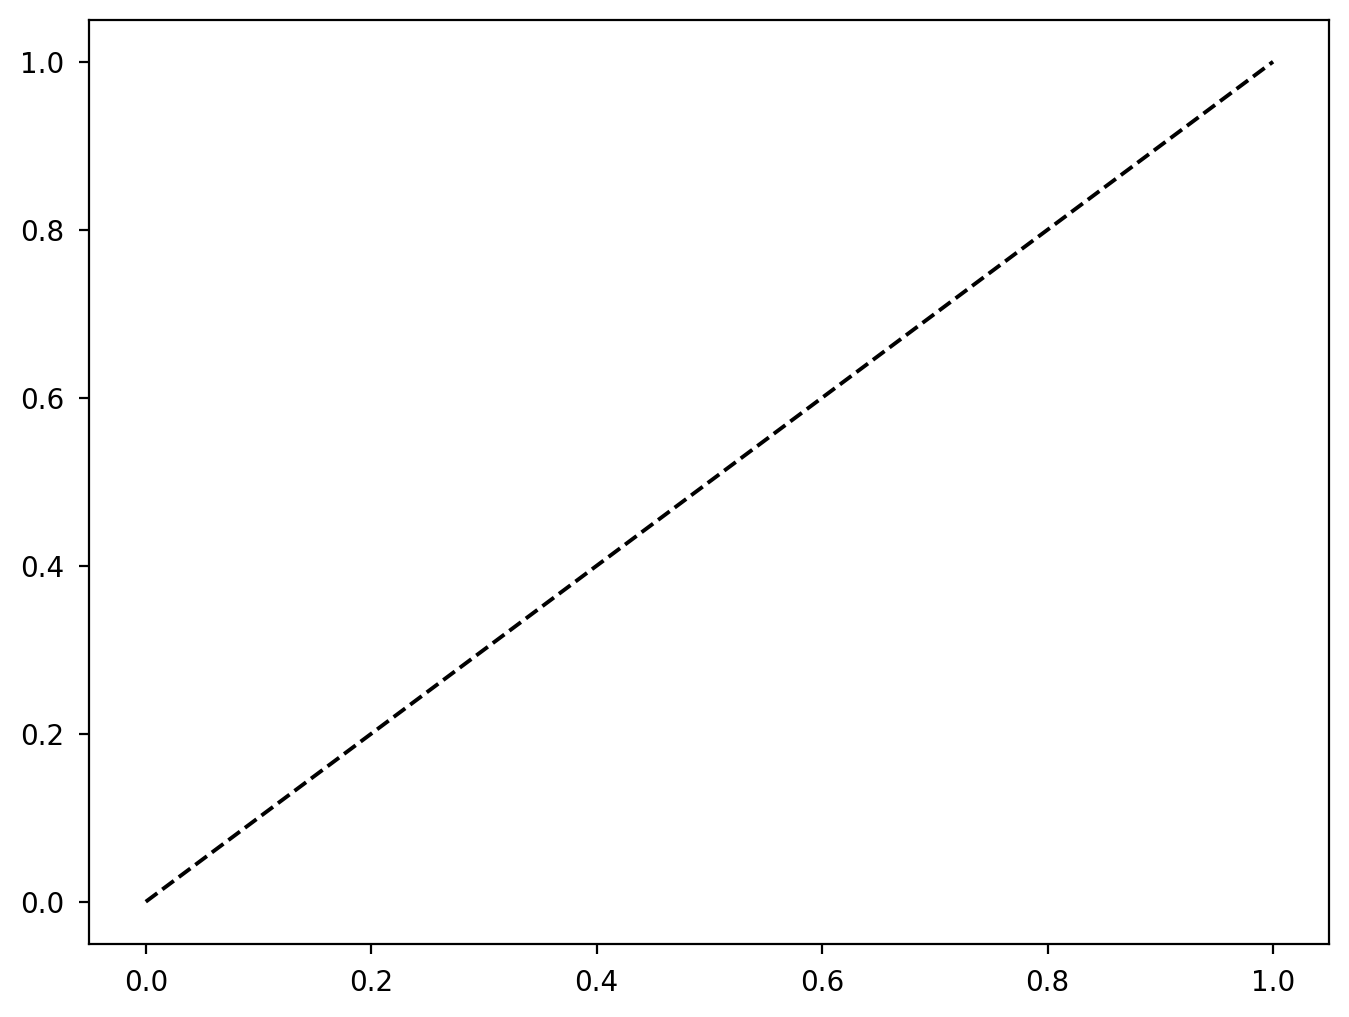

In [74]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Support Vector Machine (l2)
### Overview

In [76]:
current_path = results_path / "regularized_models/svm_l2/"
name = "SVM (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_accuracy  test_accuracy  fit_time  predict_time       p_value
count        5.000000       5.000000  5.000000      5.000000  5.000000e+00
mean         0.834500       0.489500  0.944379      0.008893  2.522996e-10
std          0.046684       0.017889  0.111156      0.004154  4.025873e-10
min          0.797500       0.472500  0.778748      0.004442  3.327330e-13
25%          0.802500       0.475000  0.909916      0.004520  6.676431e-12
50%          0.802500       0.485000  0.940605      0.010430  9.195572e-11
75%          0.875000       0.500000  1.044516      0.011762  2.055408e-10
max          0.895000       0.515000  1.048110      0.013309  9.569921e-10

### Validation Curve

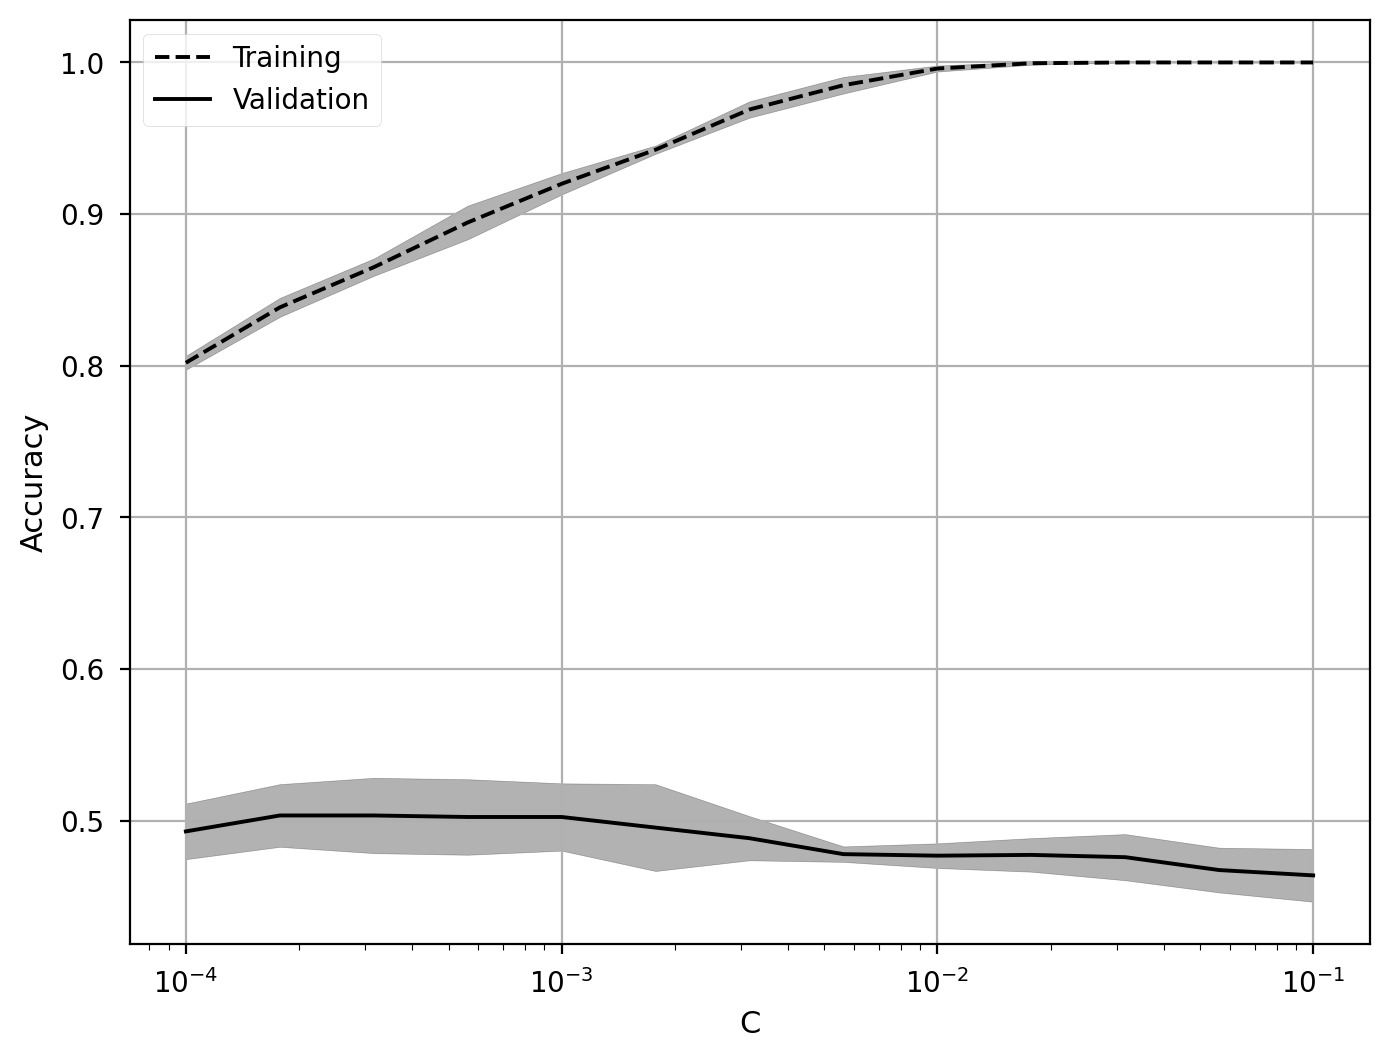

In [77]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

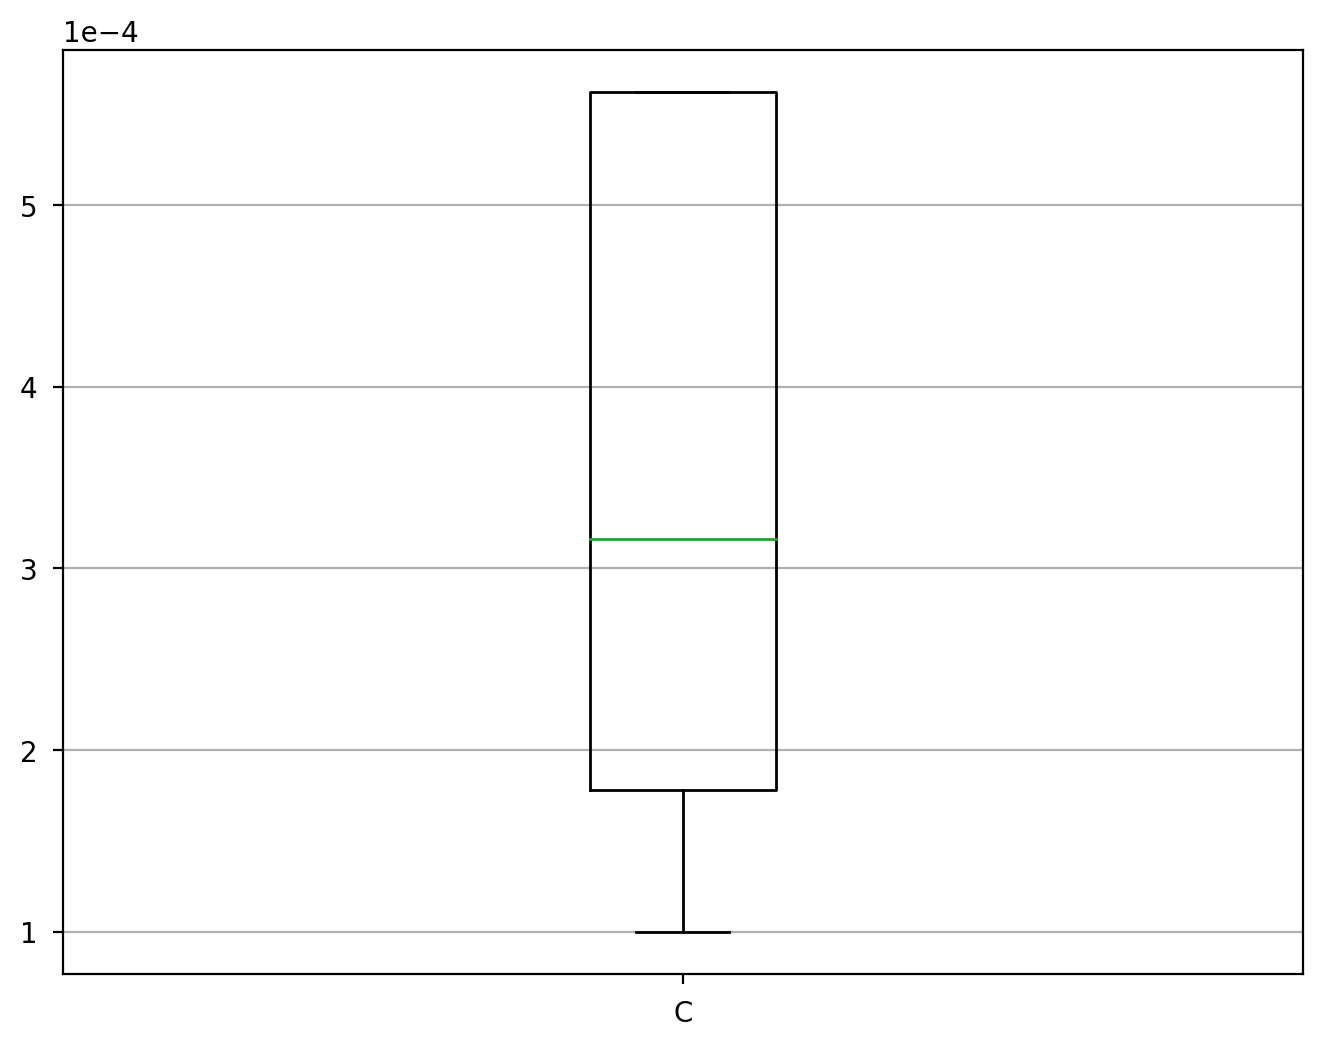

In [78]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["C"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

ValueError: Grouper and axis must be same length

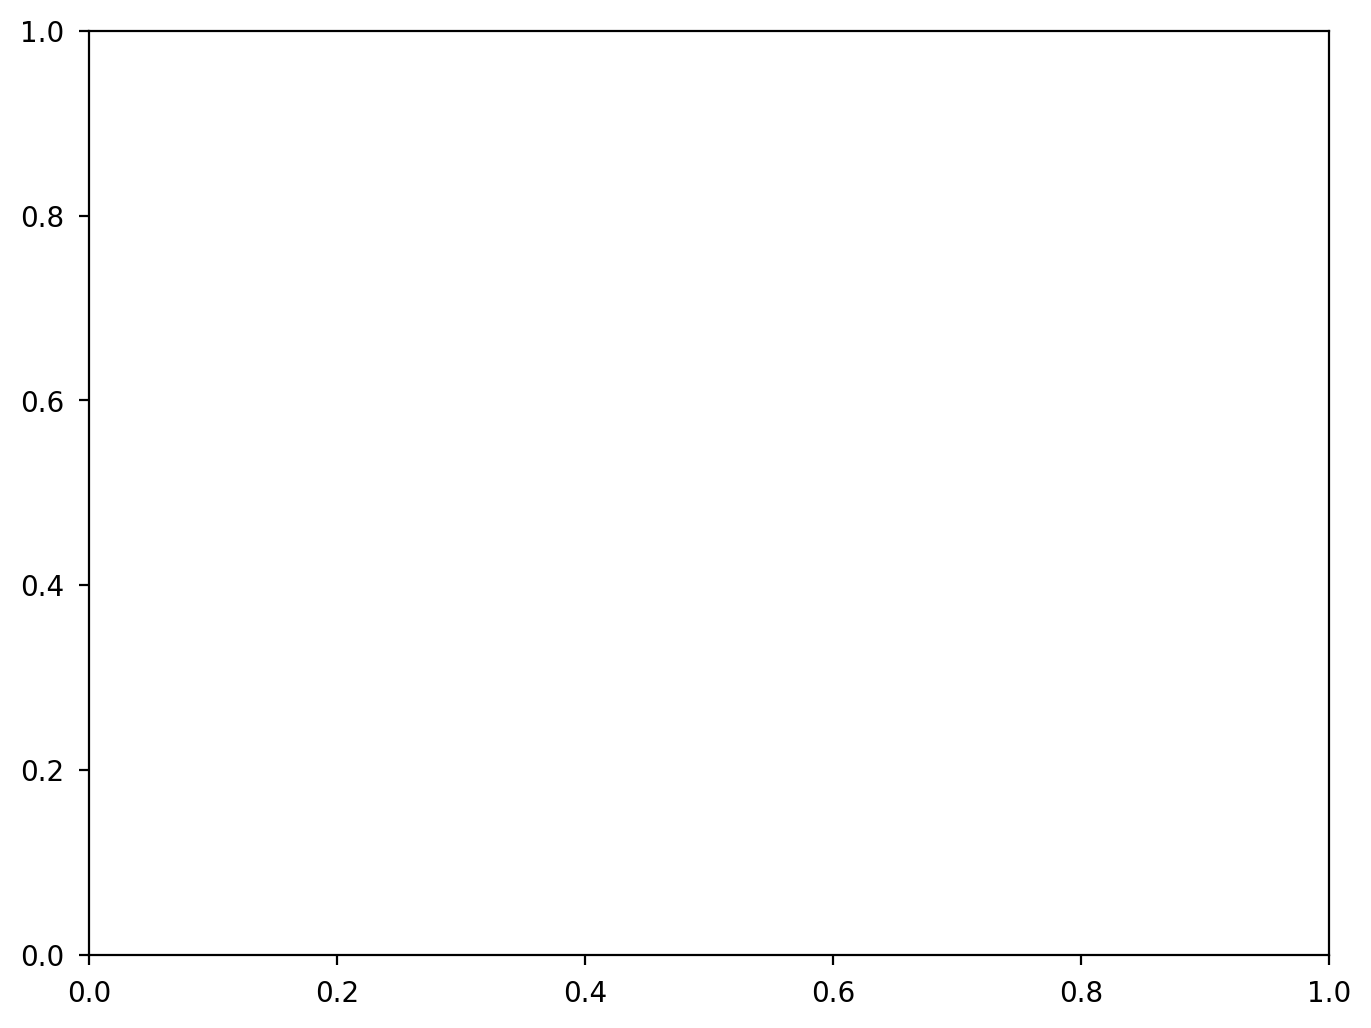

In [79]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence Score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

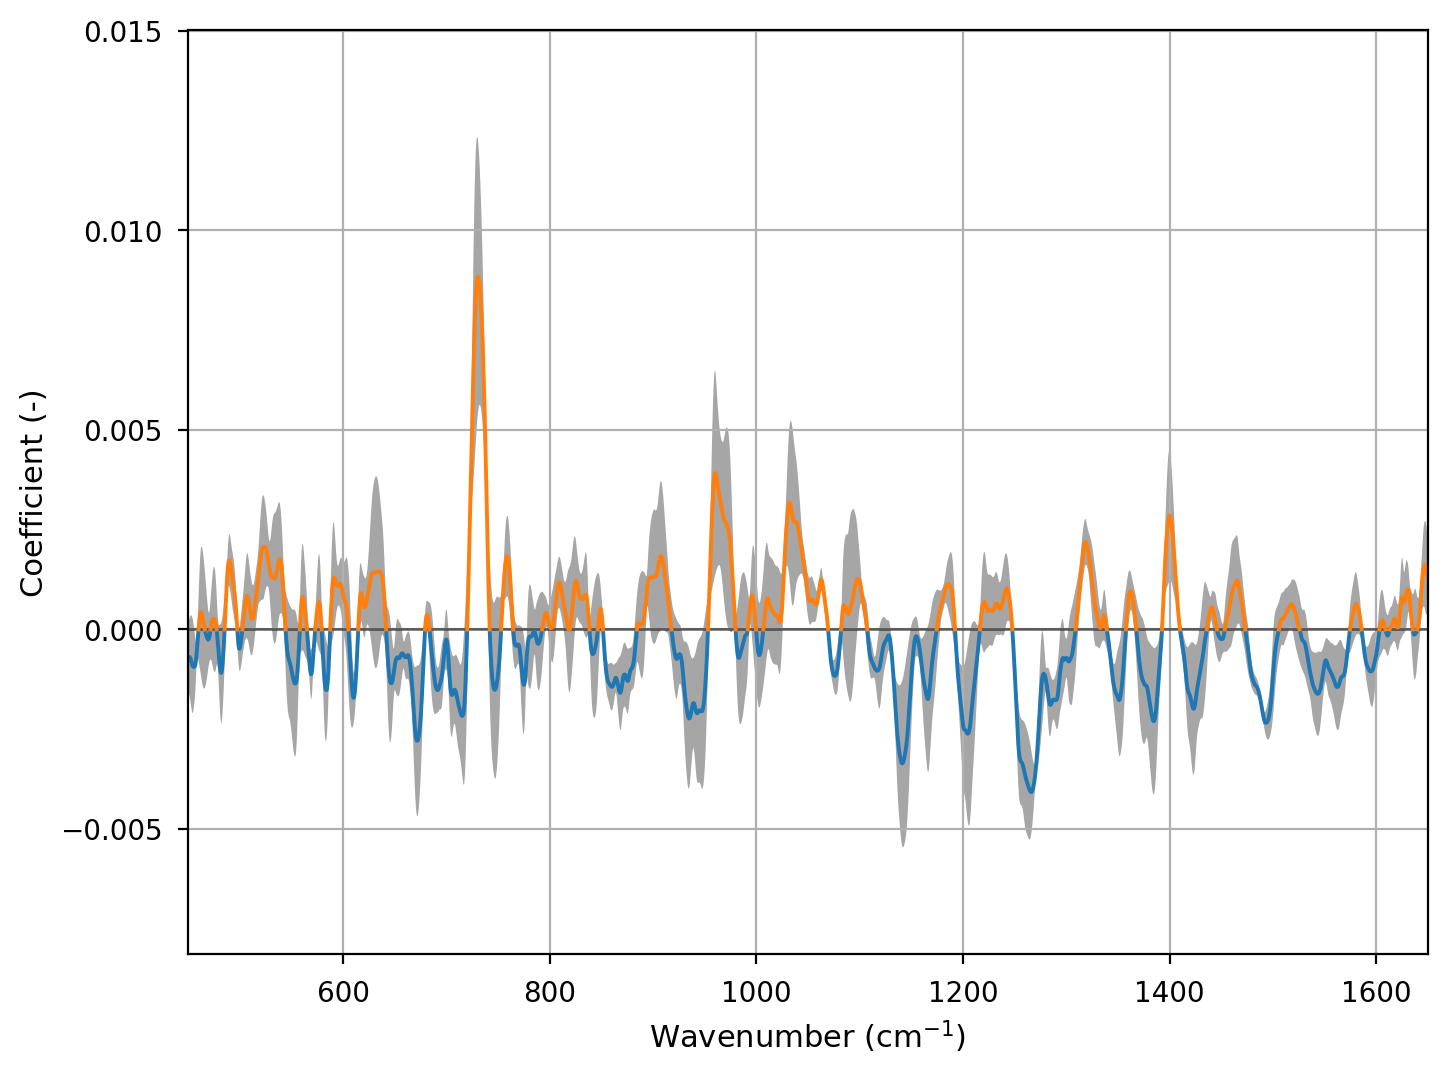

In [80]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True)

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

ValueError: Found input variables with inconsistent numbers of samples: [1200, 400]

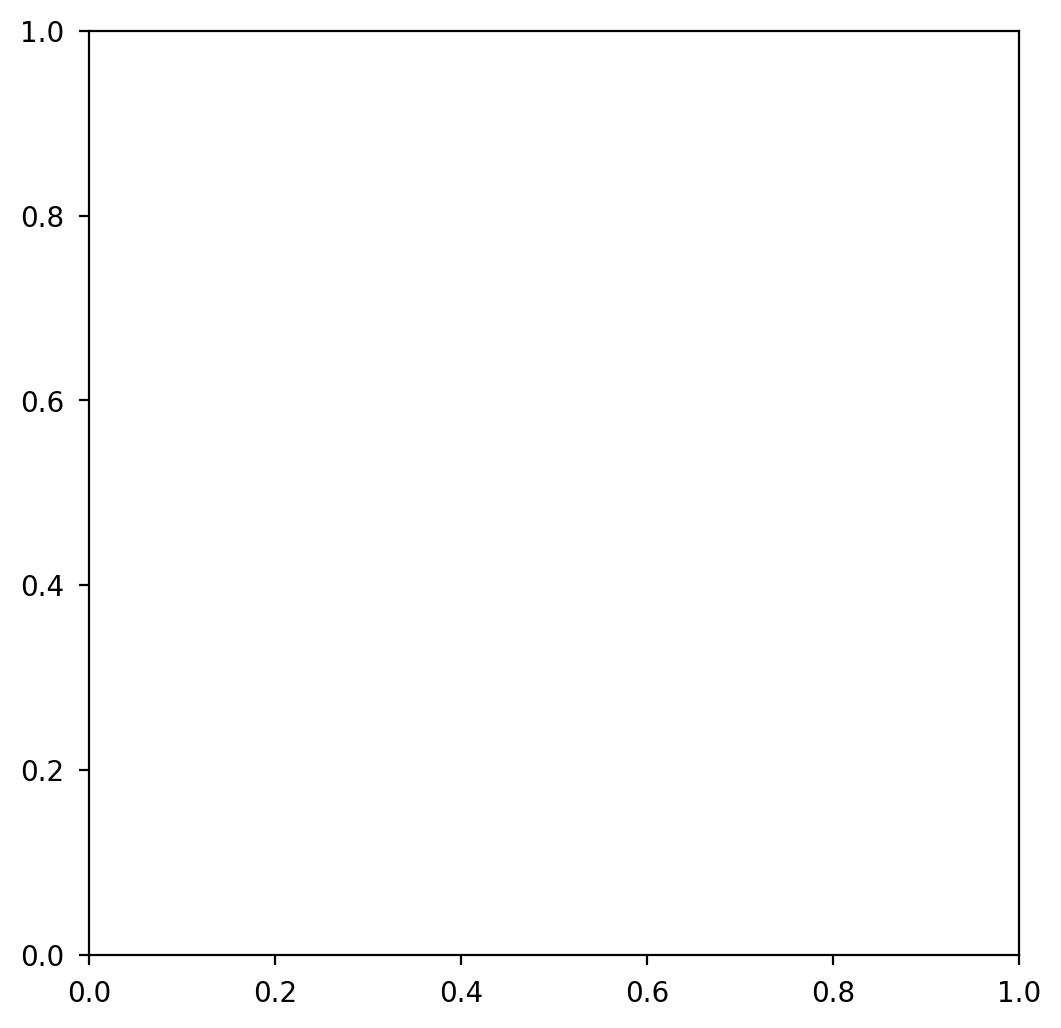

In [81]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

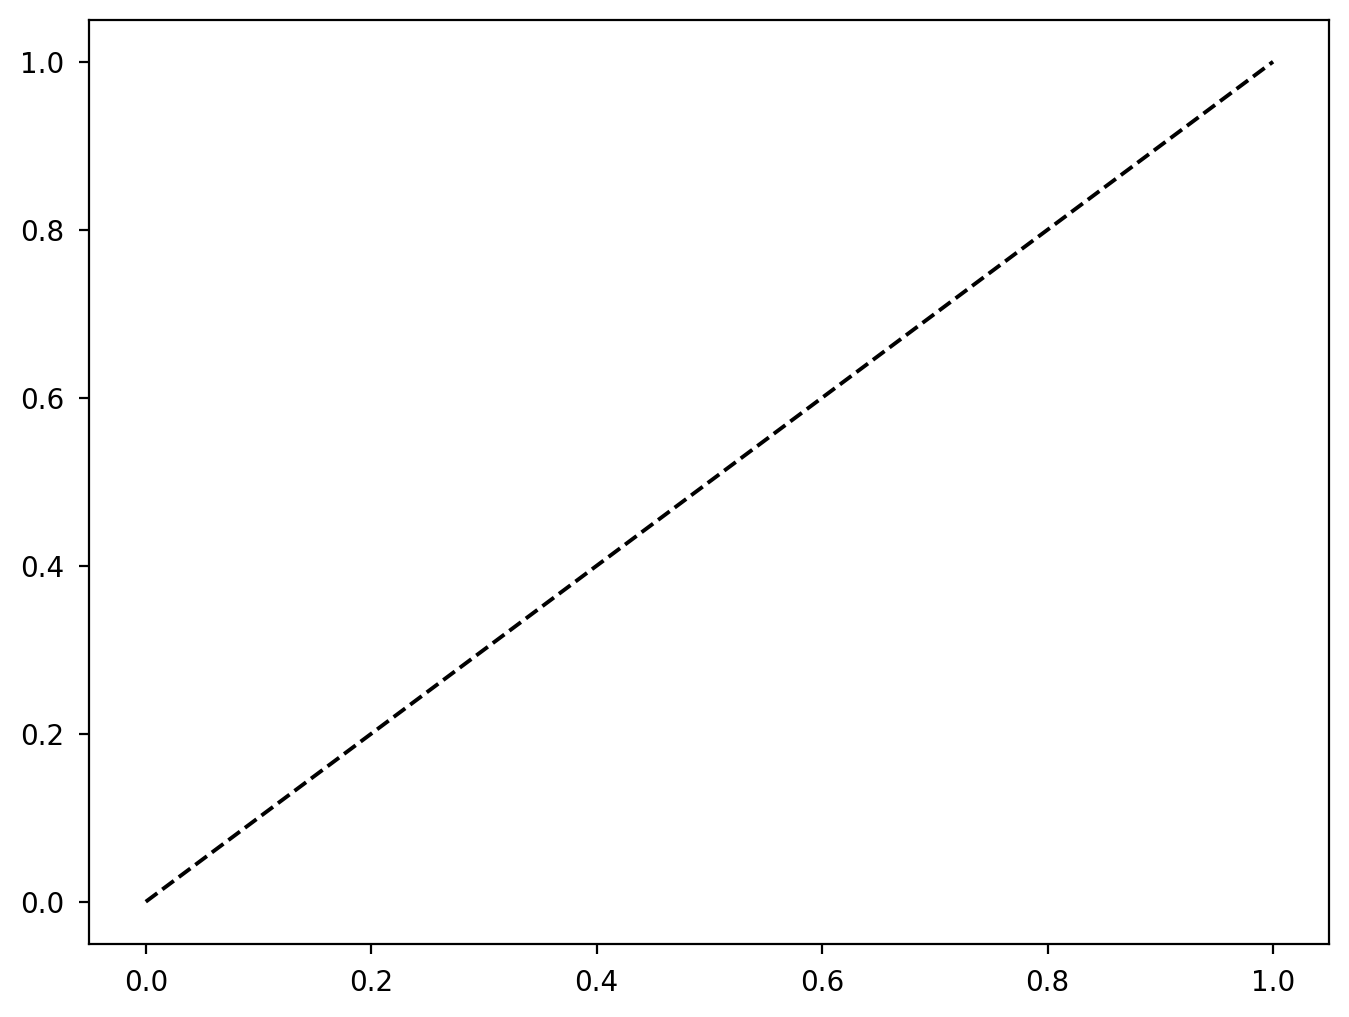

In [82]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Comparison of Regularized Models (Logistic Regression and Linear SVM)

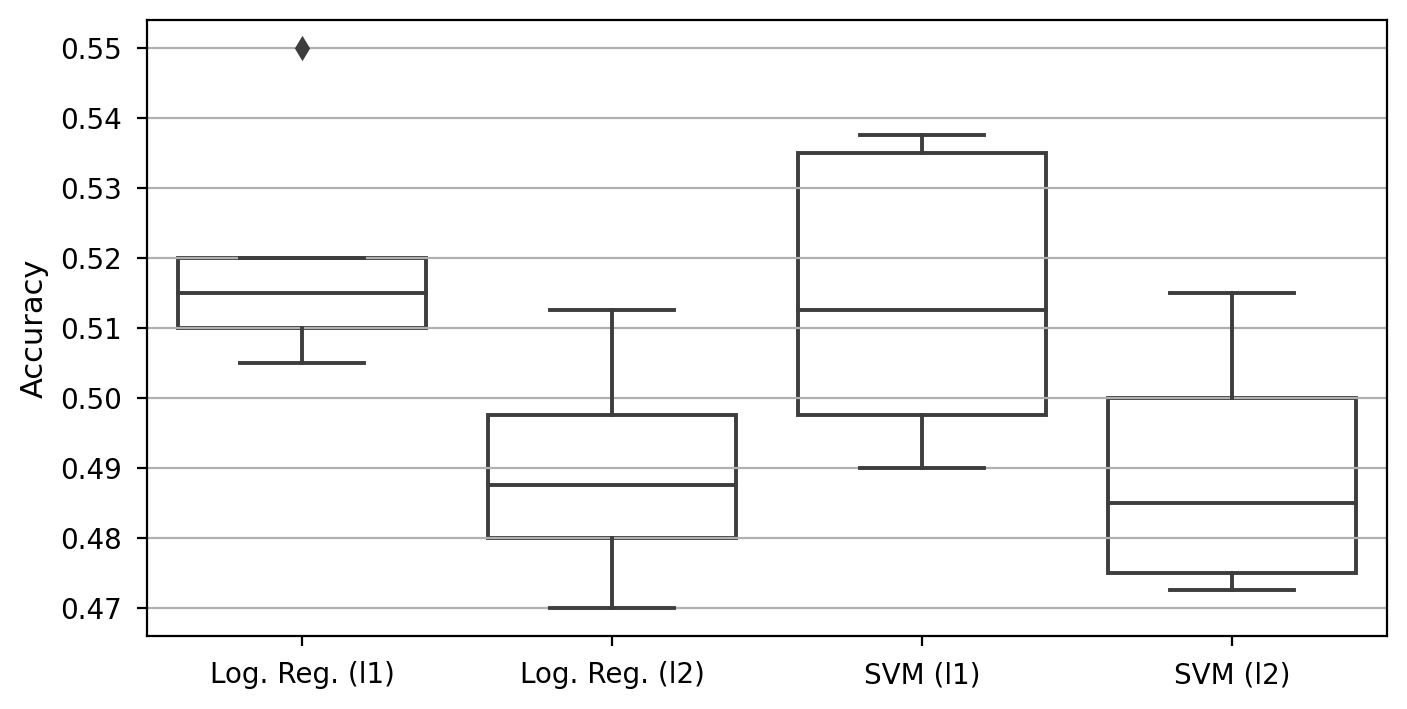

In [83]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(accs, regex="Log. Reg.|SVM")

ax.grid(axis="y")
ax.set_ylabel("Accuracy")

fig.savefig(img_path / "linear_accuracy.png", format="png", bbox_inches="tight")

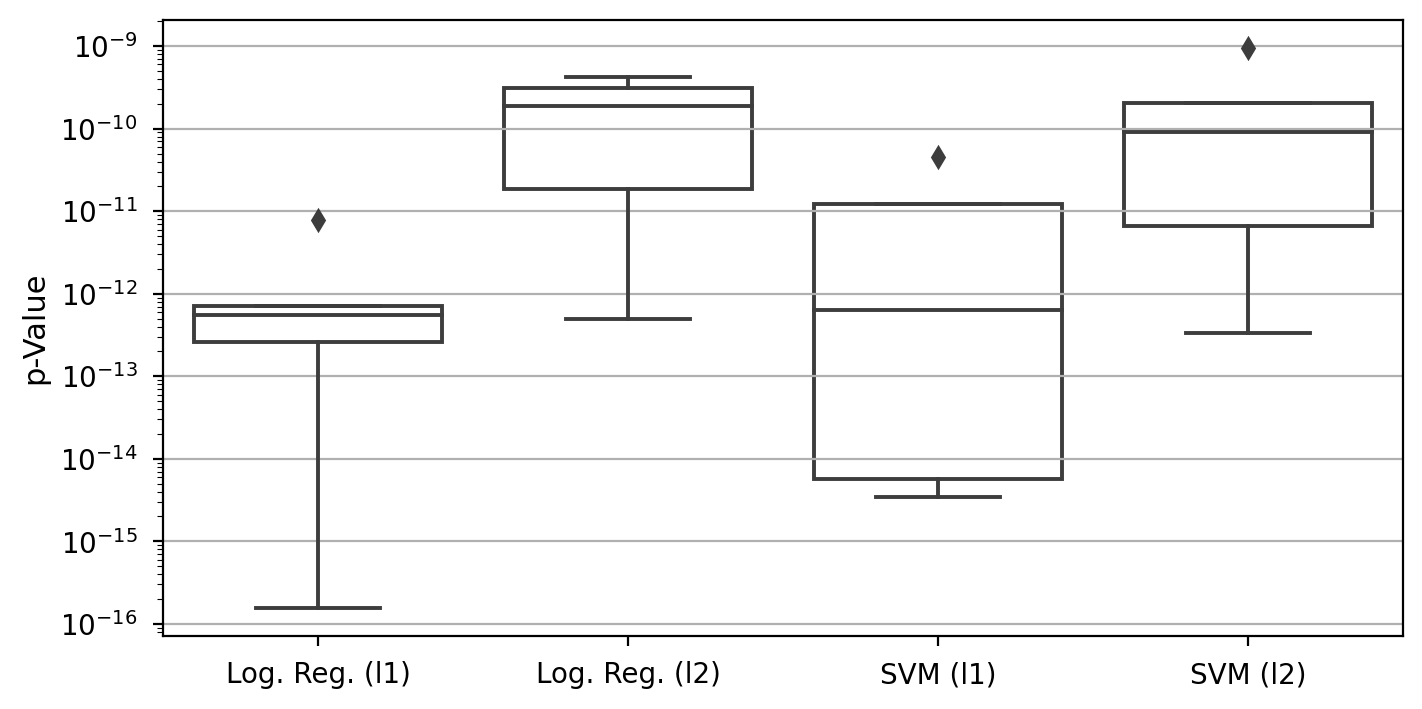

In [84]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(p_vals, regex="Log. Reg.|SVM")

ax.set_yscale("log")
ax.grid(axis="y")
ax.set_ylabel("p-Value")

fig.savefig(img_path / "linear_pval.png", format="png", bbox_inches="tight")

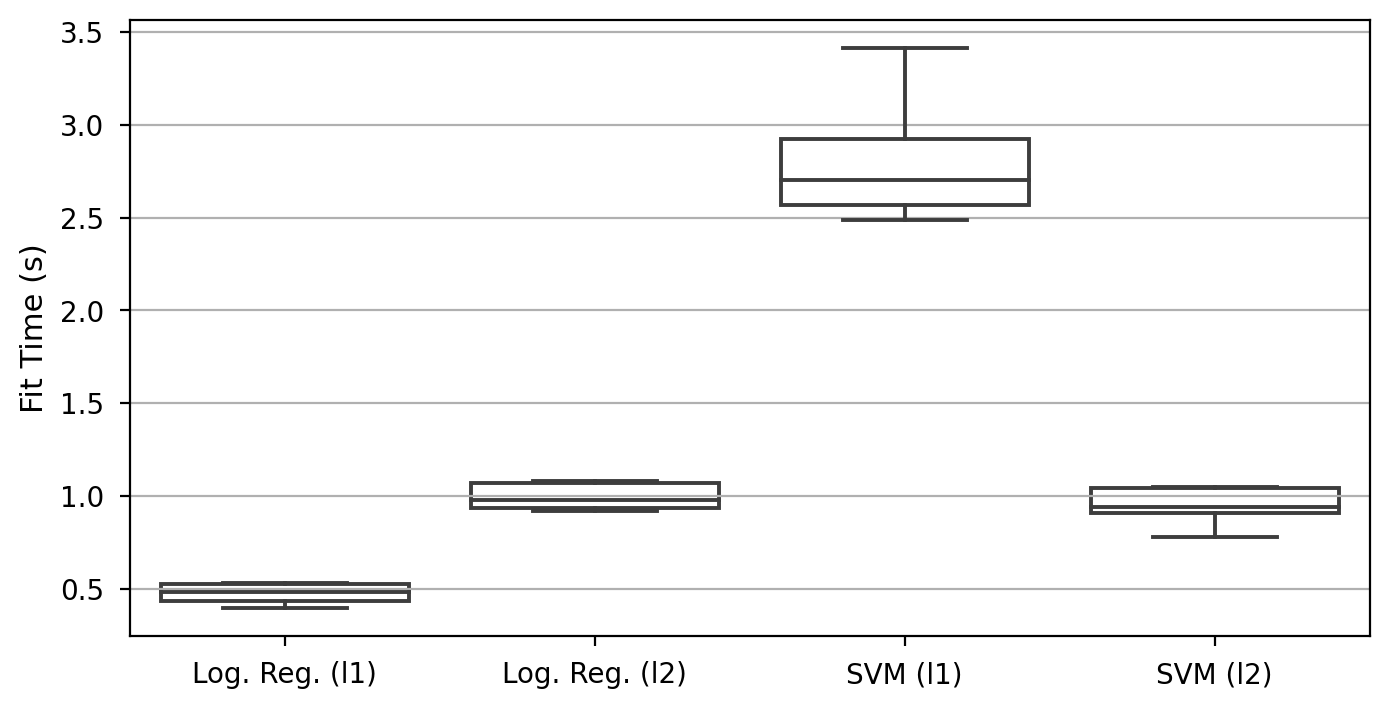

In [85]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(fit_times, regex="Log. Reg.|SVM")

ax.grid(axis="y")
ax.set_ylabel("Fit Time (s)")

fig.savefig(img_path / "linear_fittime.png", format="png", bbox_inches="tight")

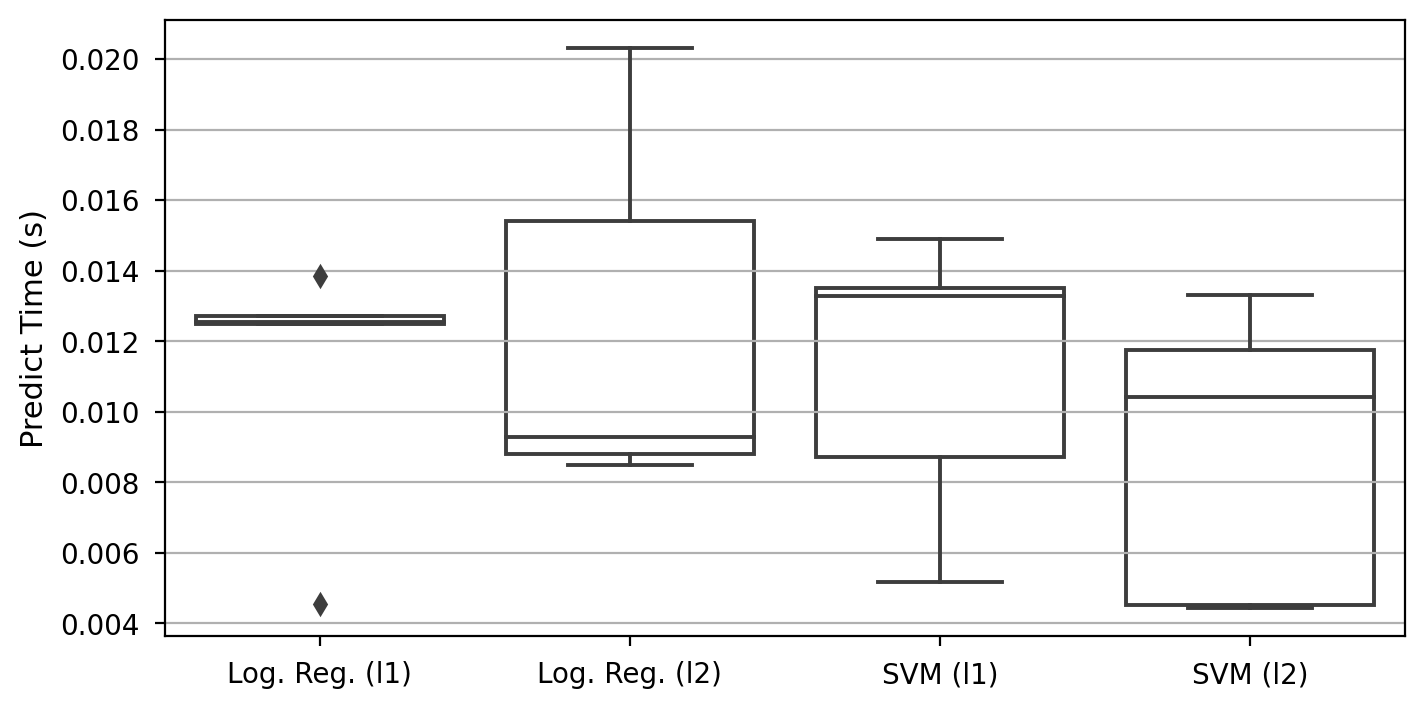

In [86]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(predict_times, regex="Log. Reg.|SVM")

ax.grid(axis="y")
ax.set_ylabel("Predict Time (s)")

fig.savefig(img_path / "linear_predicttime.png", format="png", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


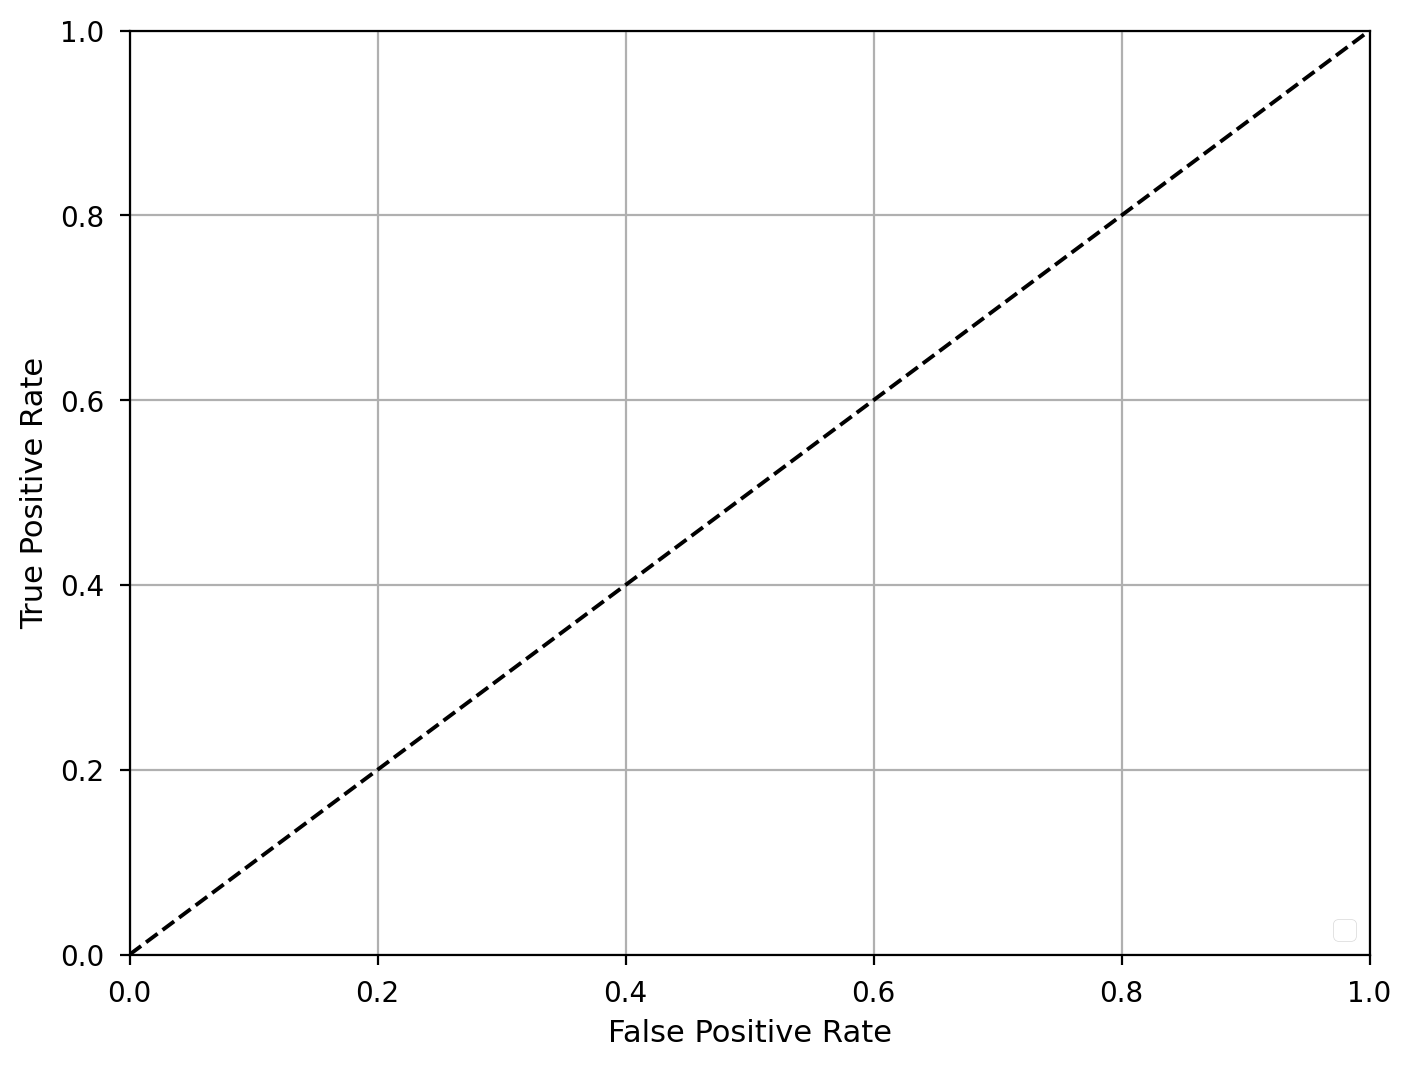

In [87]:
fig, ax = plt.subplots()
plot_roc_comparison(rocs, aucs, ax=ax, regex="Log. Reg.|SVM")

ax.grid()
ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

fig.savefig(img_path / "linear_roc.png", format="png", bbox_inches="tight")

## Decision Tree
### Overview

In [88]:
current_path = results_path / "tree_based_models/decision_tree/"
name = "Decision Tree"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_accuracy  test_accuracy   fit_time  predict_time       p_value
count       20.000000      20.000000  20.000000     20.000000  2.000000e+01
mean         0.709139       0.641556   6.764060      0.002416  4.093880e-36
std          0.018190       0.014199   0.166079      0.000628  1.830339e-35
min          0.680000       0.605556   6.536998      0.001661  7.700049e-50
25%          0.696389       0.630833   6.658787      0.002114  4.969878e-47
50%          0.708194       0.643889   6.728916      0.002224  4.593666e-45
75%          0.718194       0.652222   6.820899      0.002491  1.008052e-40
max          0.755833       0.660000   7.162109      0.004061  8.185636e-35

### Validation Curve

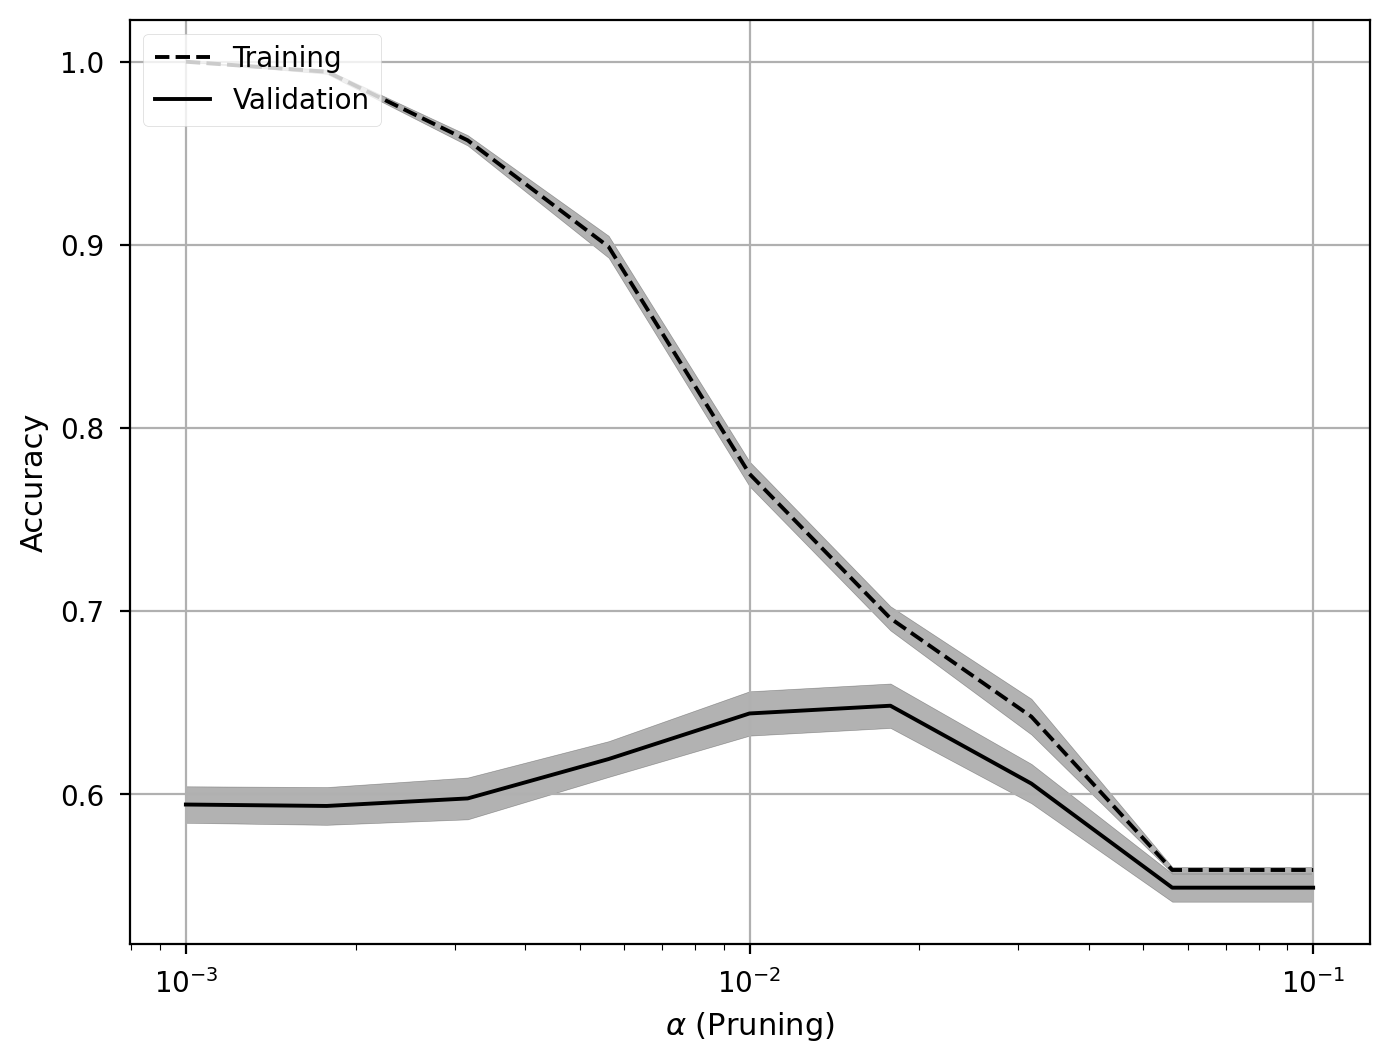

In [89]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xscale("log")
ax.set_xlabel(r"$\alpha$ (Pruning)")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

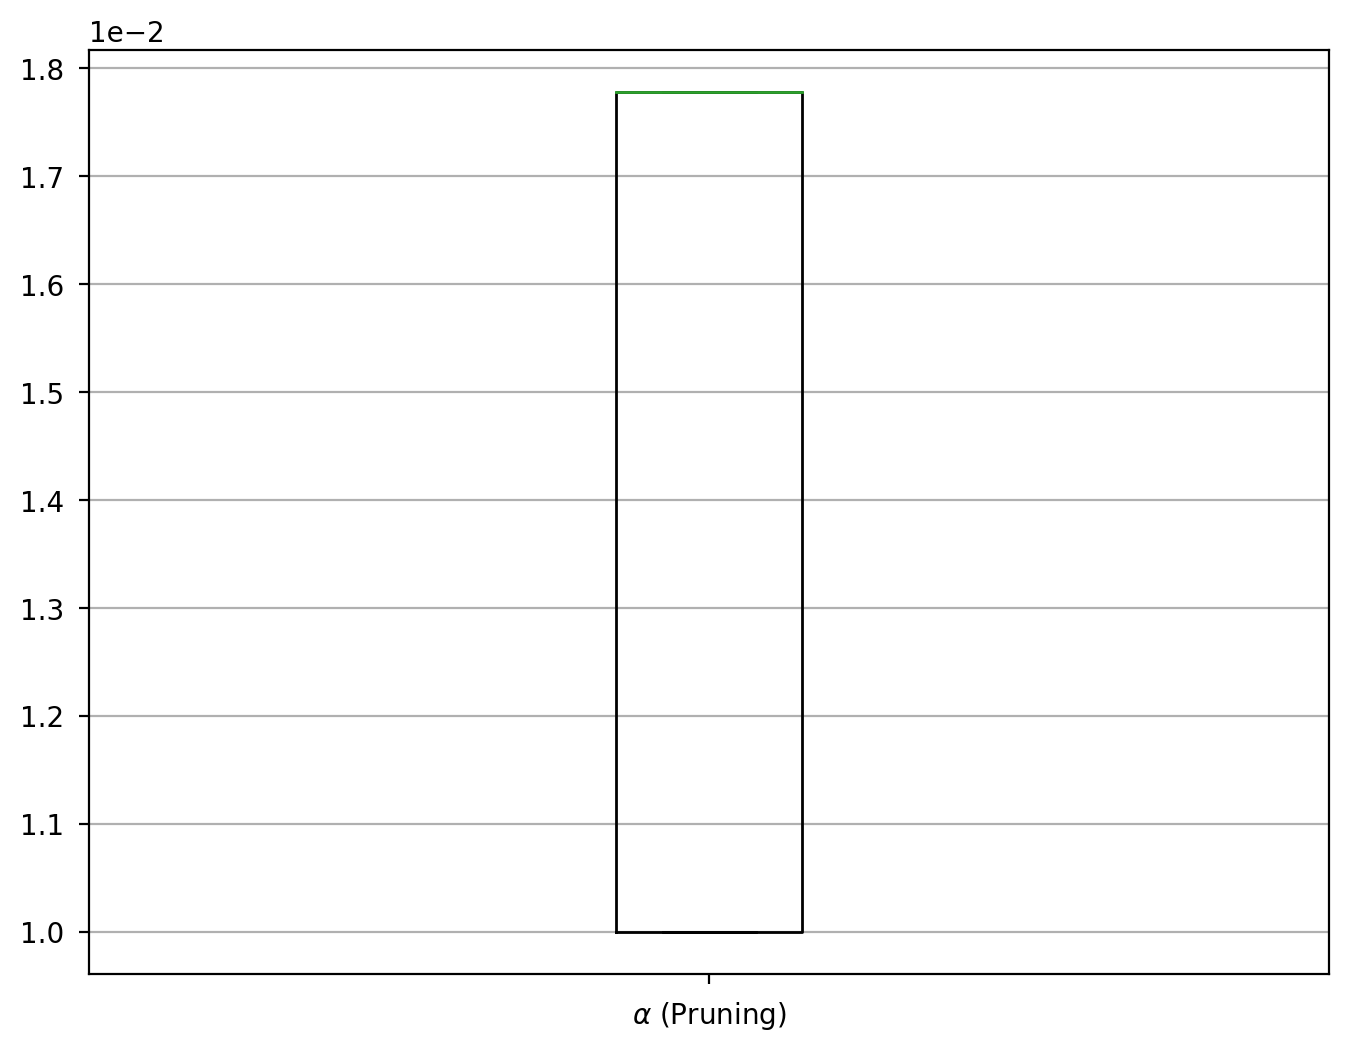

In [90]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels([r"$\alpha$ (Pruning)"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

ValueError: Grouper and axis must be same length

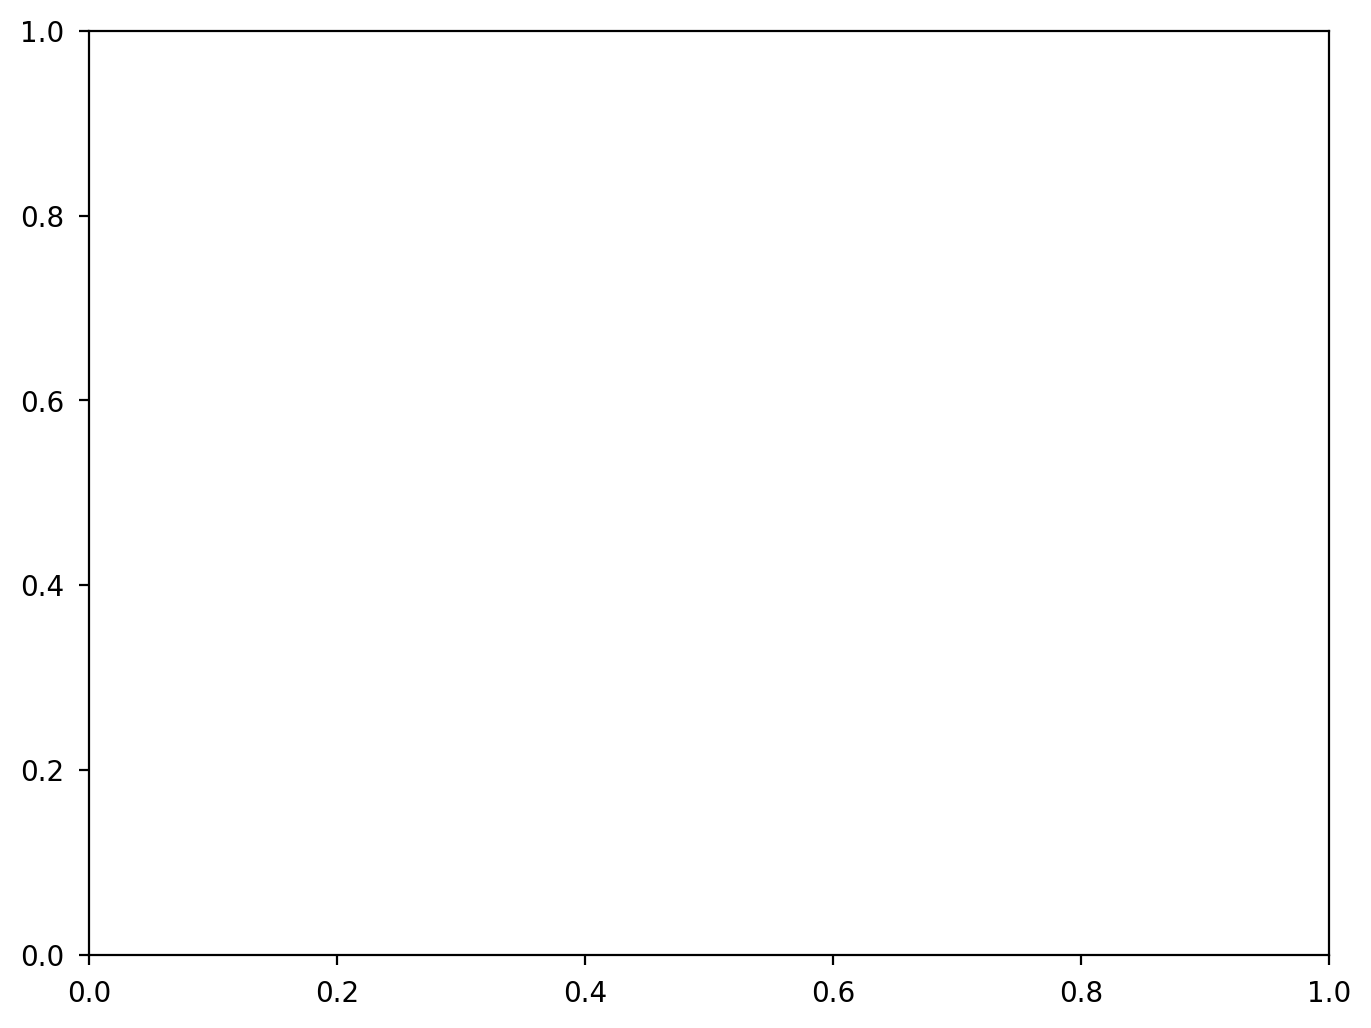

In [91]:
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(proba_df, y_key[y], y_key, ax=ax)
ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_yscale("logit")
ax.set_ylabel("Probability (-)")
ax.grid(axis="y")


### Tree

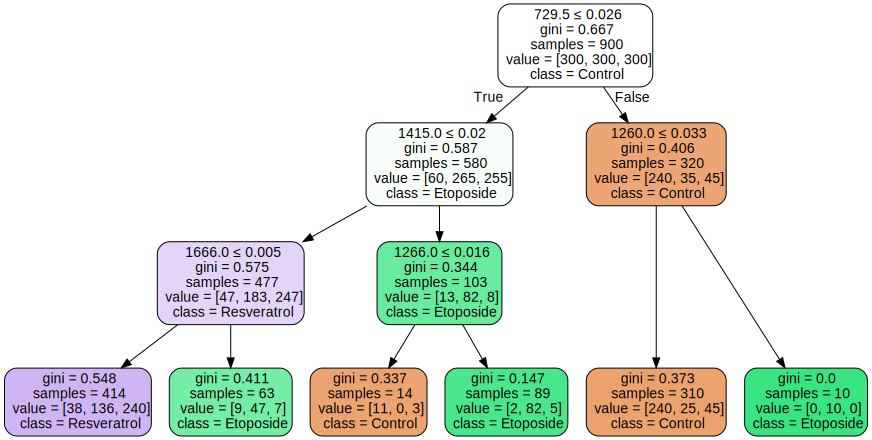

In [92]:
tree = graphviz.Source.from_file(current_path / "tree.dot")
tree.render(img_path / "tree", format="png")
tree

### Confusion Matrix

ValueError: Found input variables with inconsistent numbers of samples: [1200, 900]

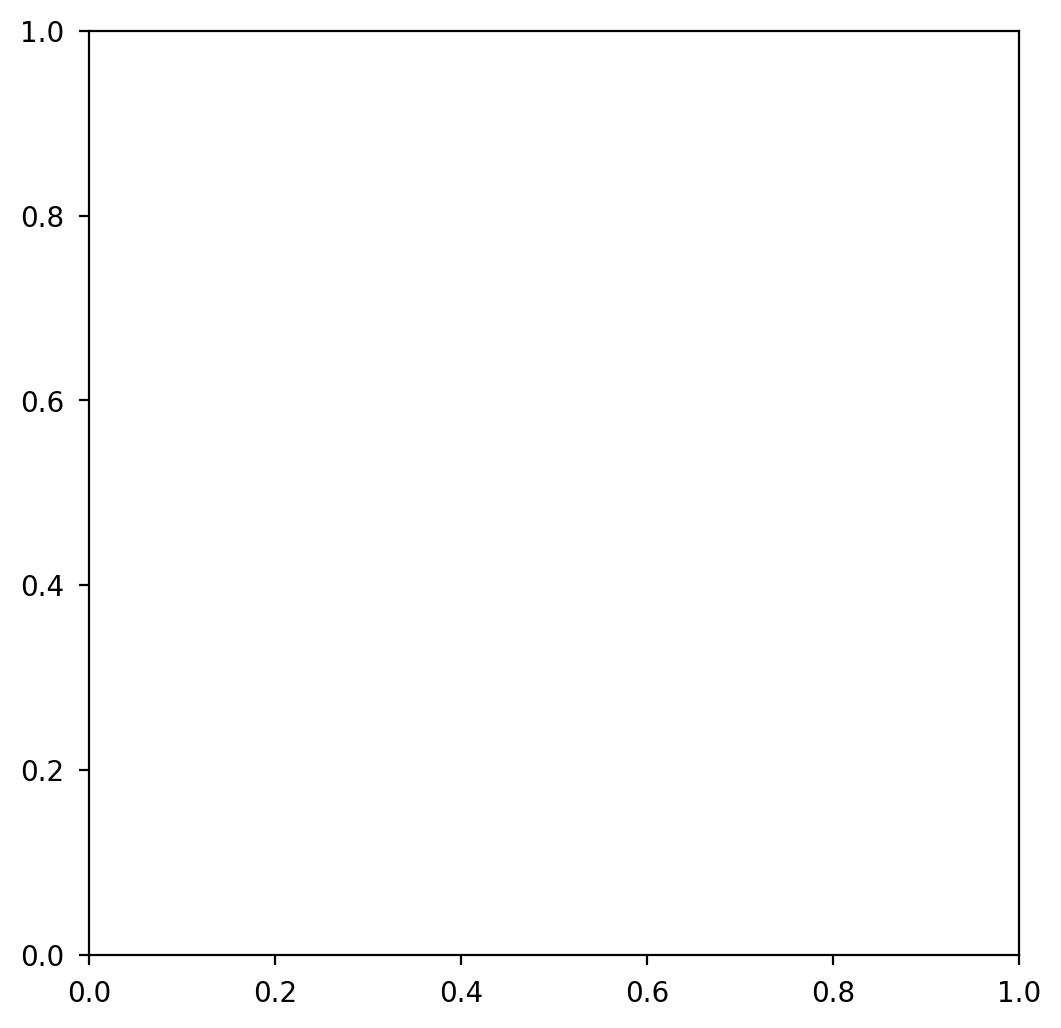

In [93]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

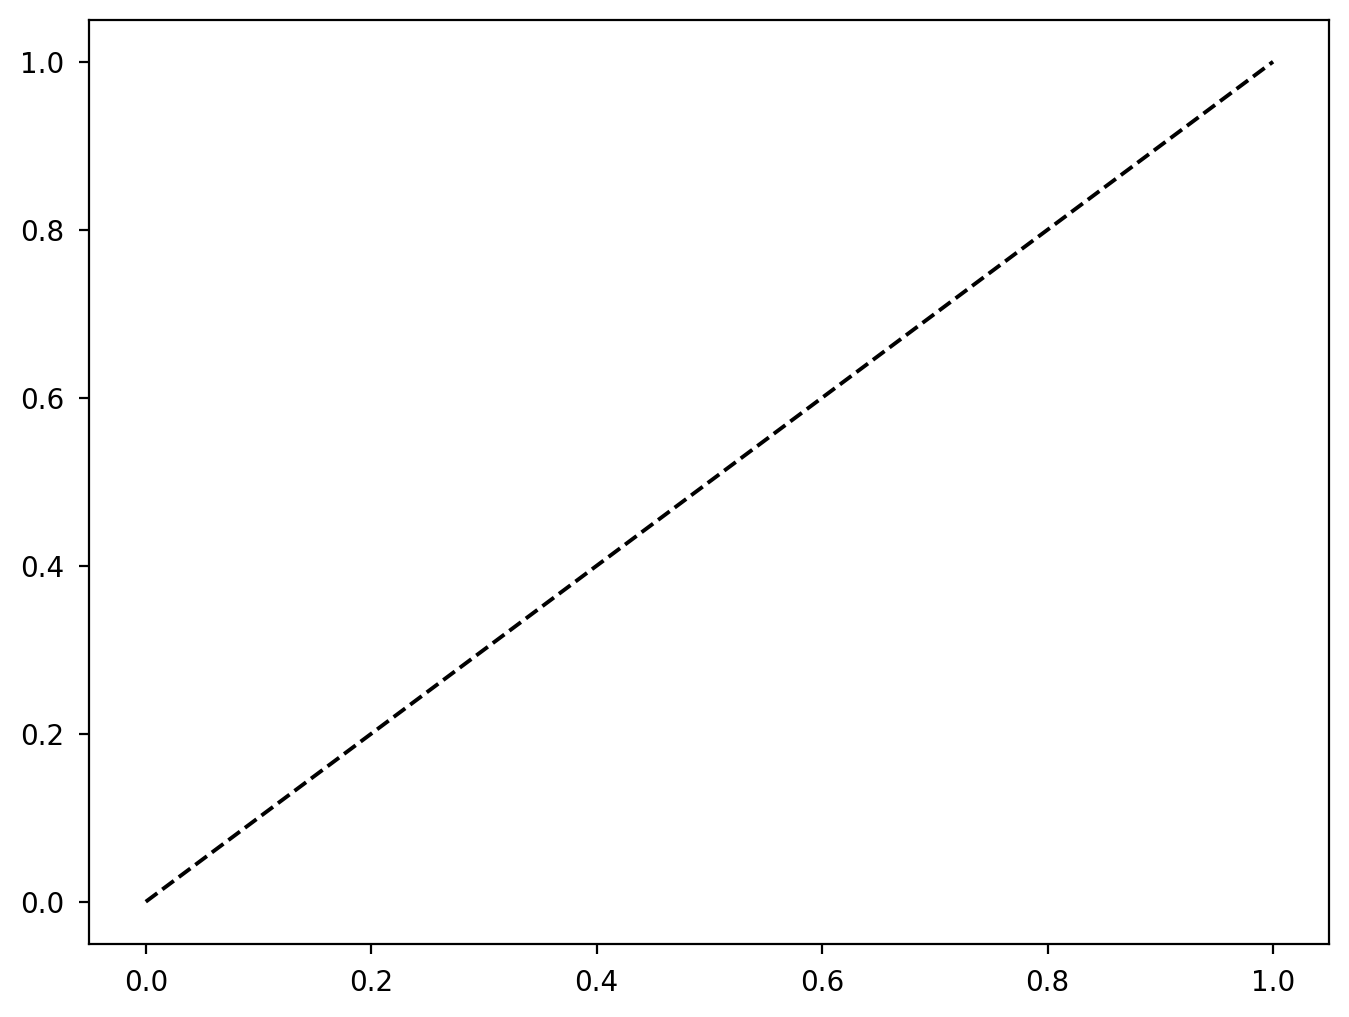

In [94]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(proba_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Random Forest
### Overview

In [96]:
current_path = results_path / "tree_based_models/random_forest/"
name = "Random Forest"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_accuracy  test_accuracy   fit_time  predict_time       p_value
count       20.000000      20.000000  20.000000     20.000000  2.000000e+01
mean         0.890764       0.700500   5.784890      0.002566  1.364014e-55
std          0.002877       0.009251   0.241174      0.000906  4.068233e-55
min          0.885000       0.681111   5.541598      0.001693  1.755003e-61
25%          0.888333       0.693056   5.622671      0.001824  2.265181e-60
50%          0.891250       0.703333   5.730958      0.002053  5.680517e-59
75%          0.893194       0.706667   5.868375      0.003477  3.242093e-56
max          0.894722       0.714444   6.593011      0.004309  1.807559e-54

### Validation Curve

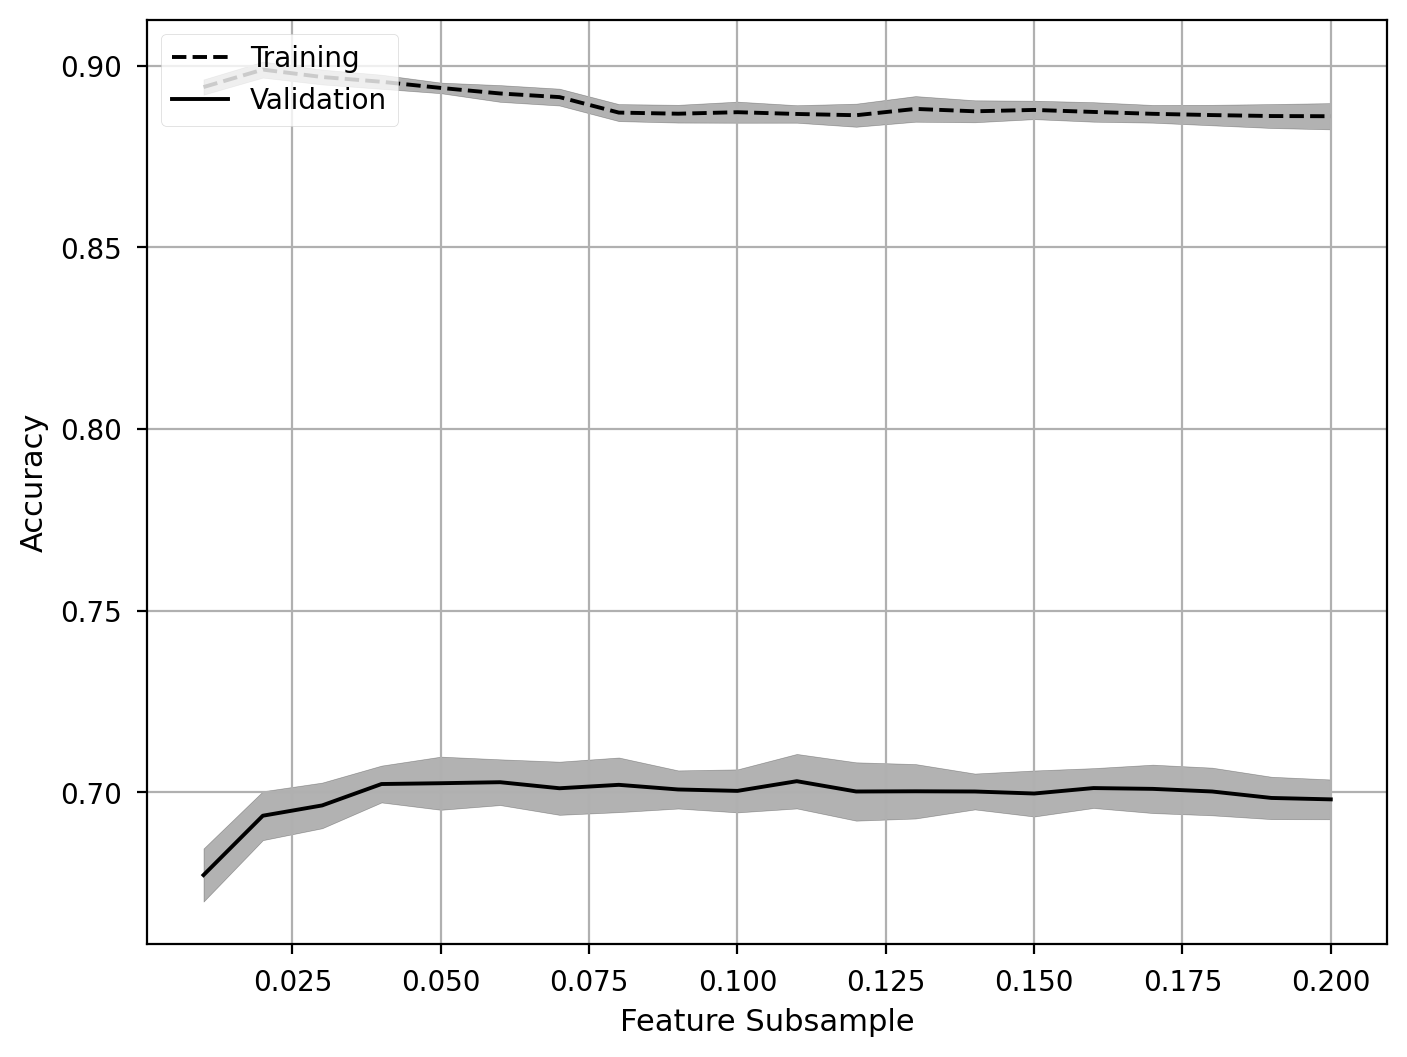

In [97]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Feature Subsample")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

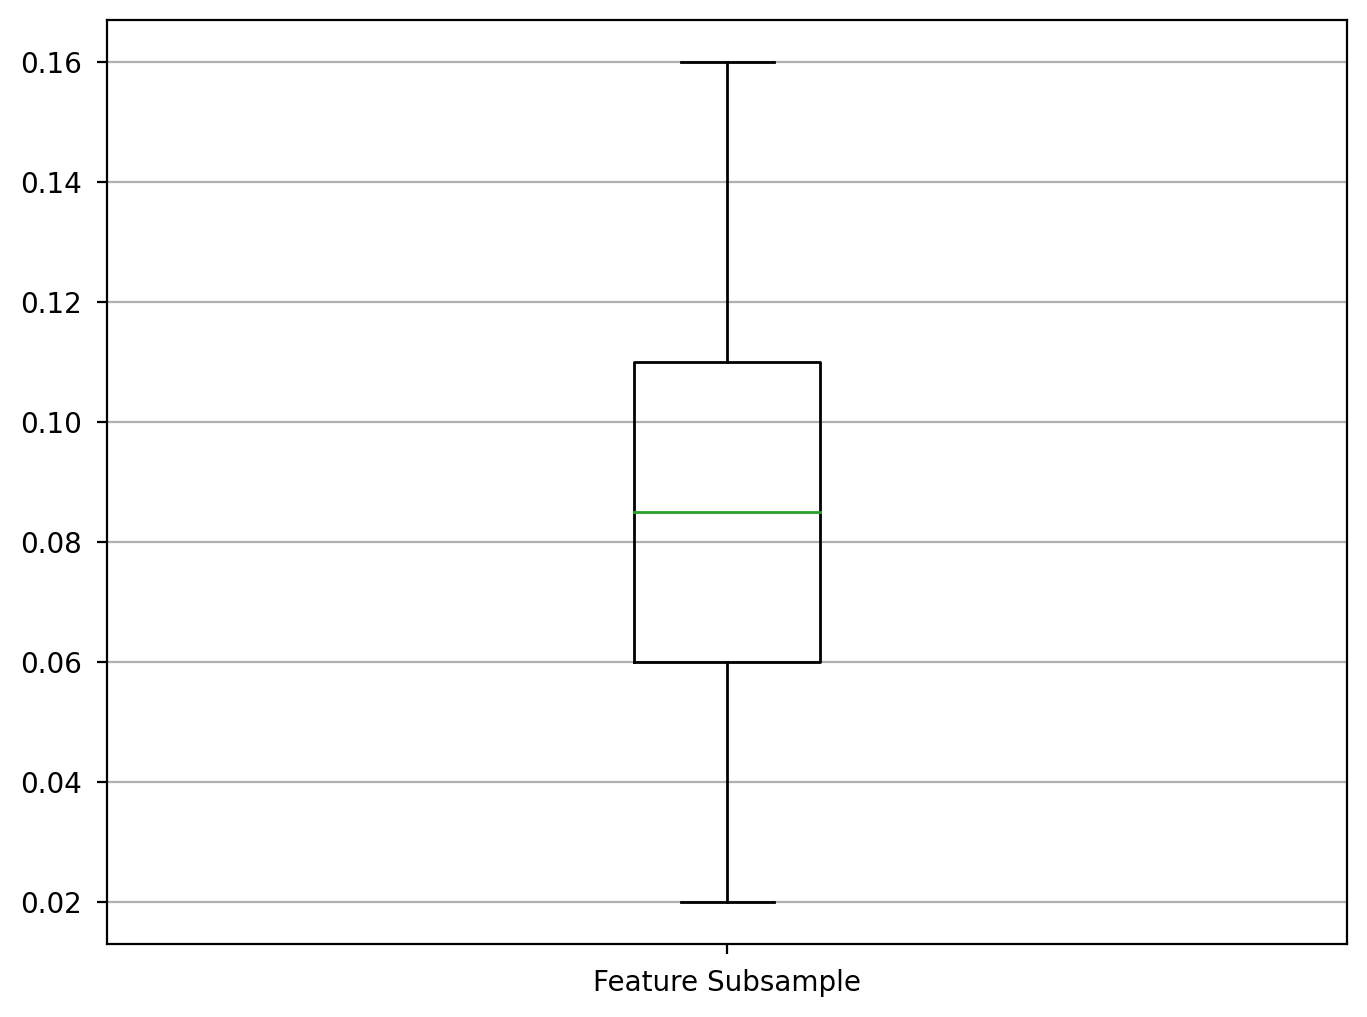

In [98]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Feature Subsample"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

ValueError: Grouper and axis must be same length

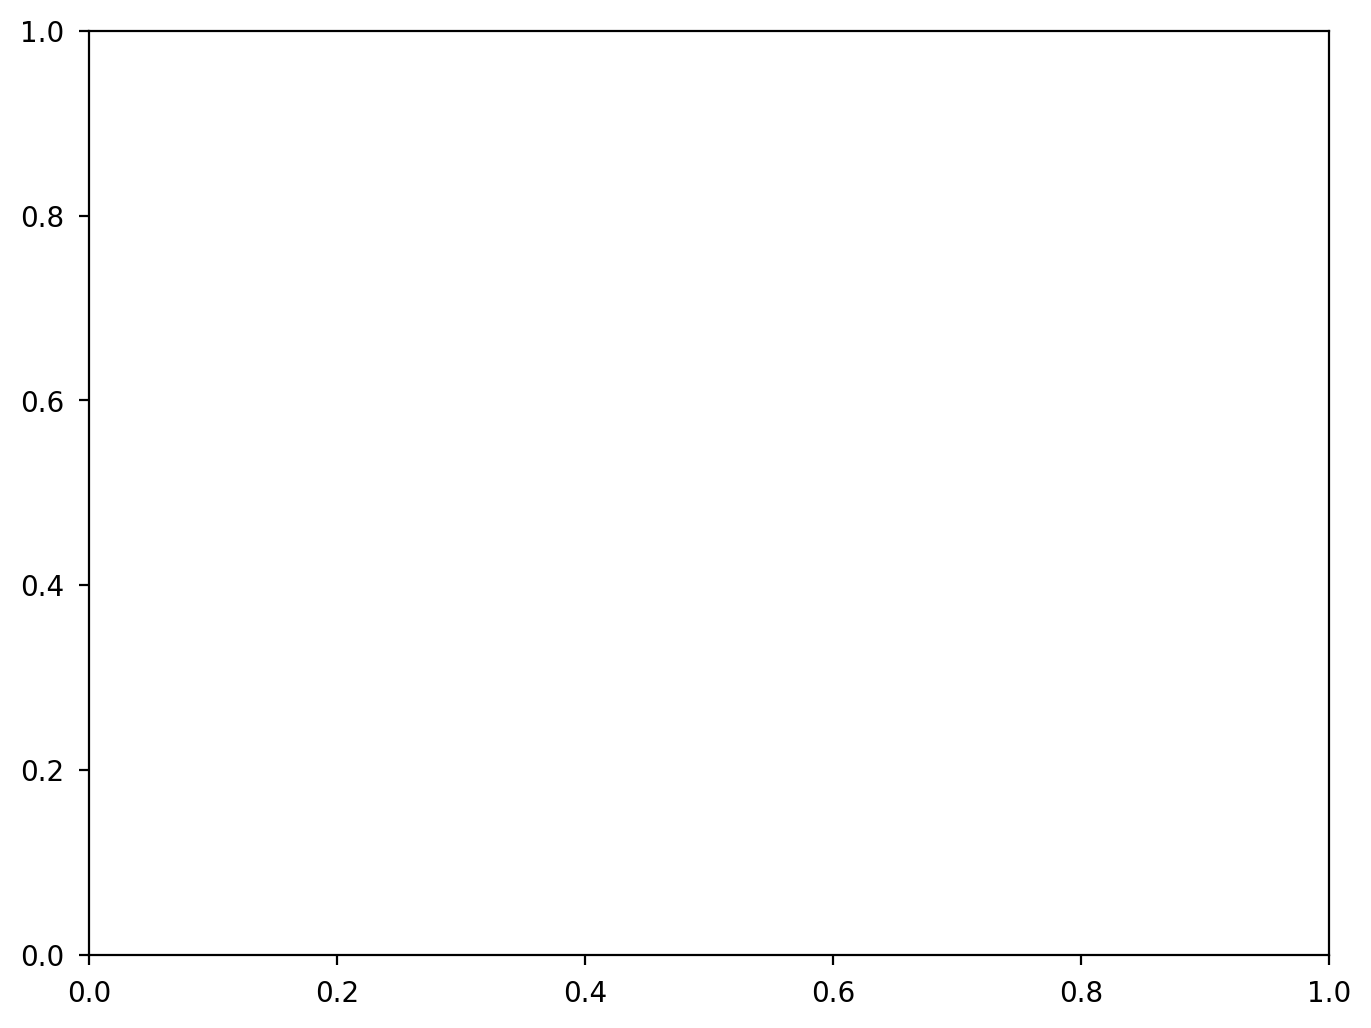

In [99]:
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(proba_df, y_key[y], y_key, ax=ax)
ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_yscale("logit")
ax.set_ylabel("Probability (-)")
ax.grid(axis="y")

### Confusion Matrix

ValueError: Found input variables with inconsistent numbers of samples: [1200, 900]

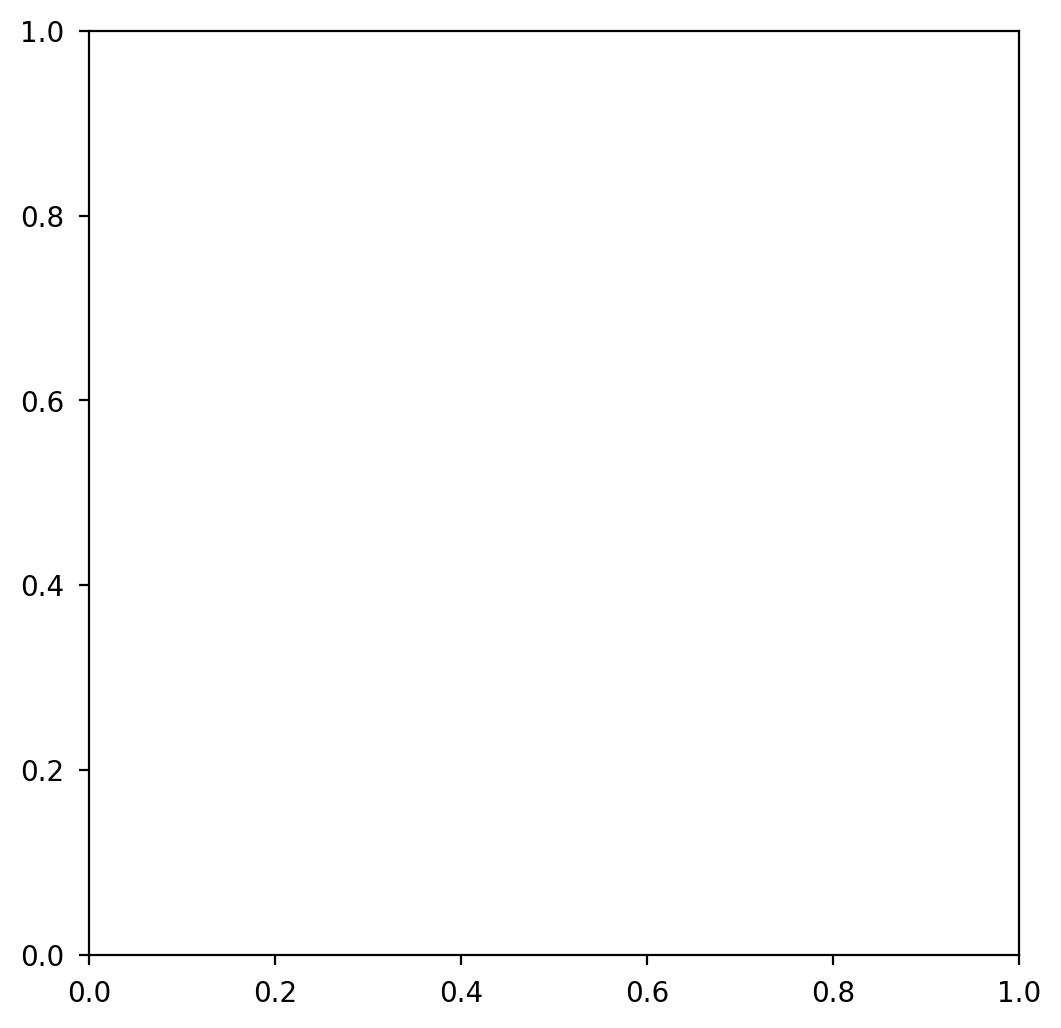

In [100]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

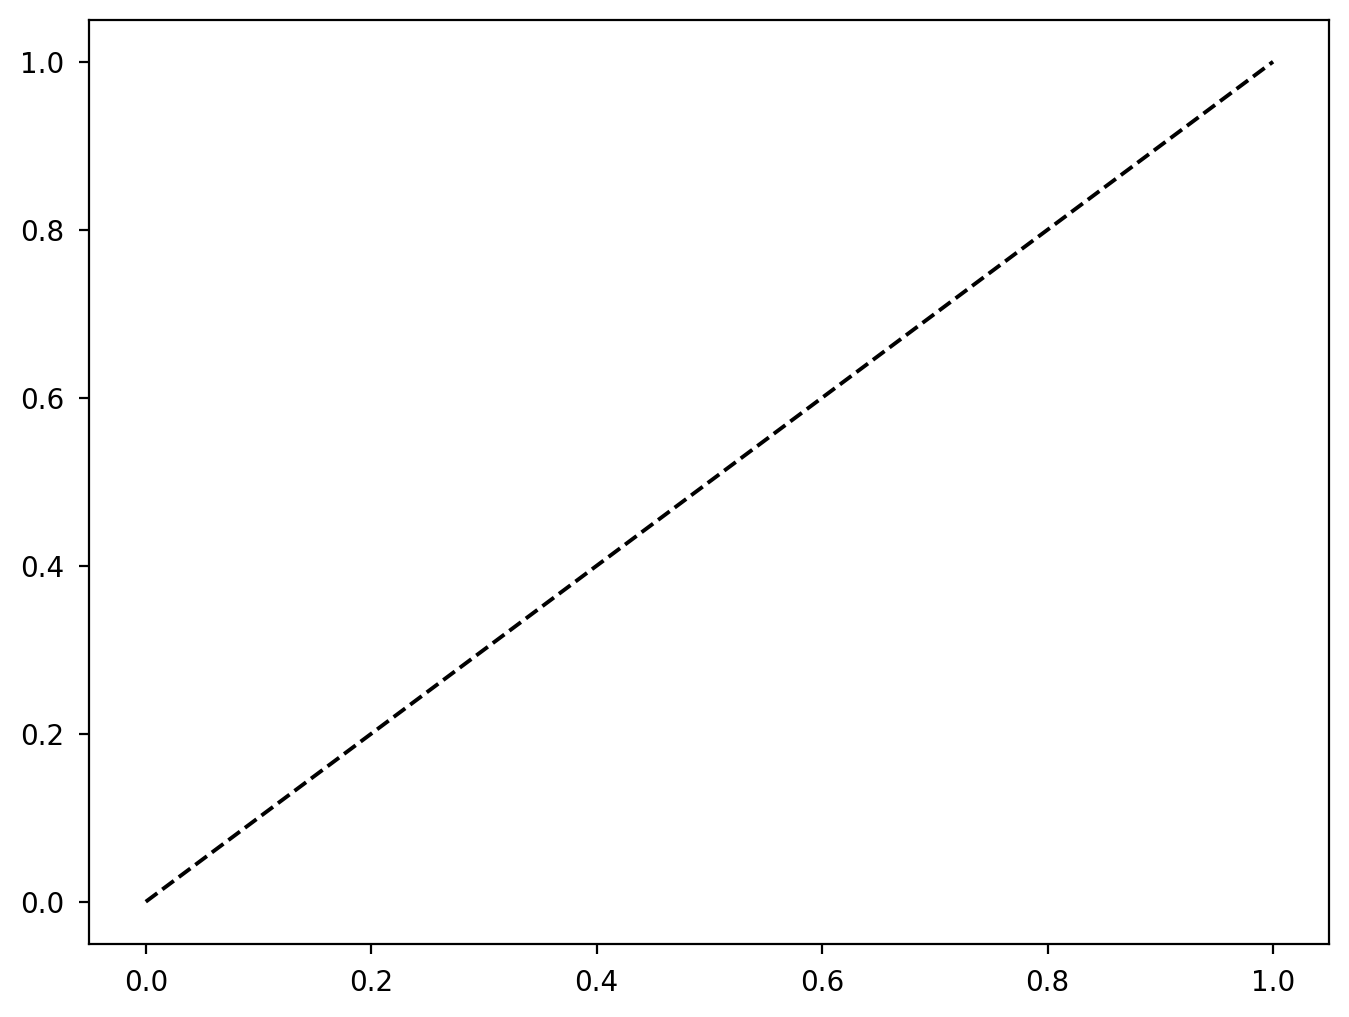

In [101]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(proba_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

### Explainable AI - SHAP

In [102]:
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)

In [103]:
fig, ax = plt.subplots()
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

fig.savefig(img_path / "randomforest_shap_waterfall.png", format="png", bbox_inches="tight")

ValueError: Image size of 1389027x1199 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1600x1300 with 3 Axes>

ValueError: Image size of 1389027x1199 pixels is too large. It must be less than 2^16 in each direction.

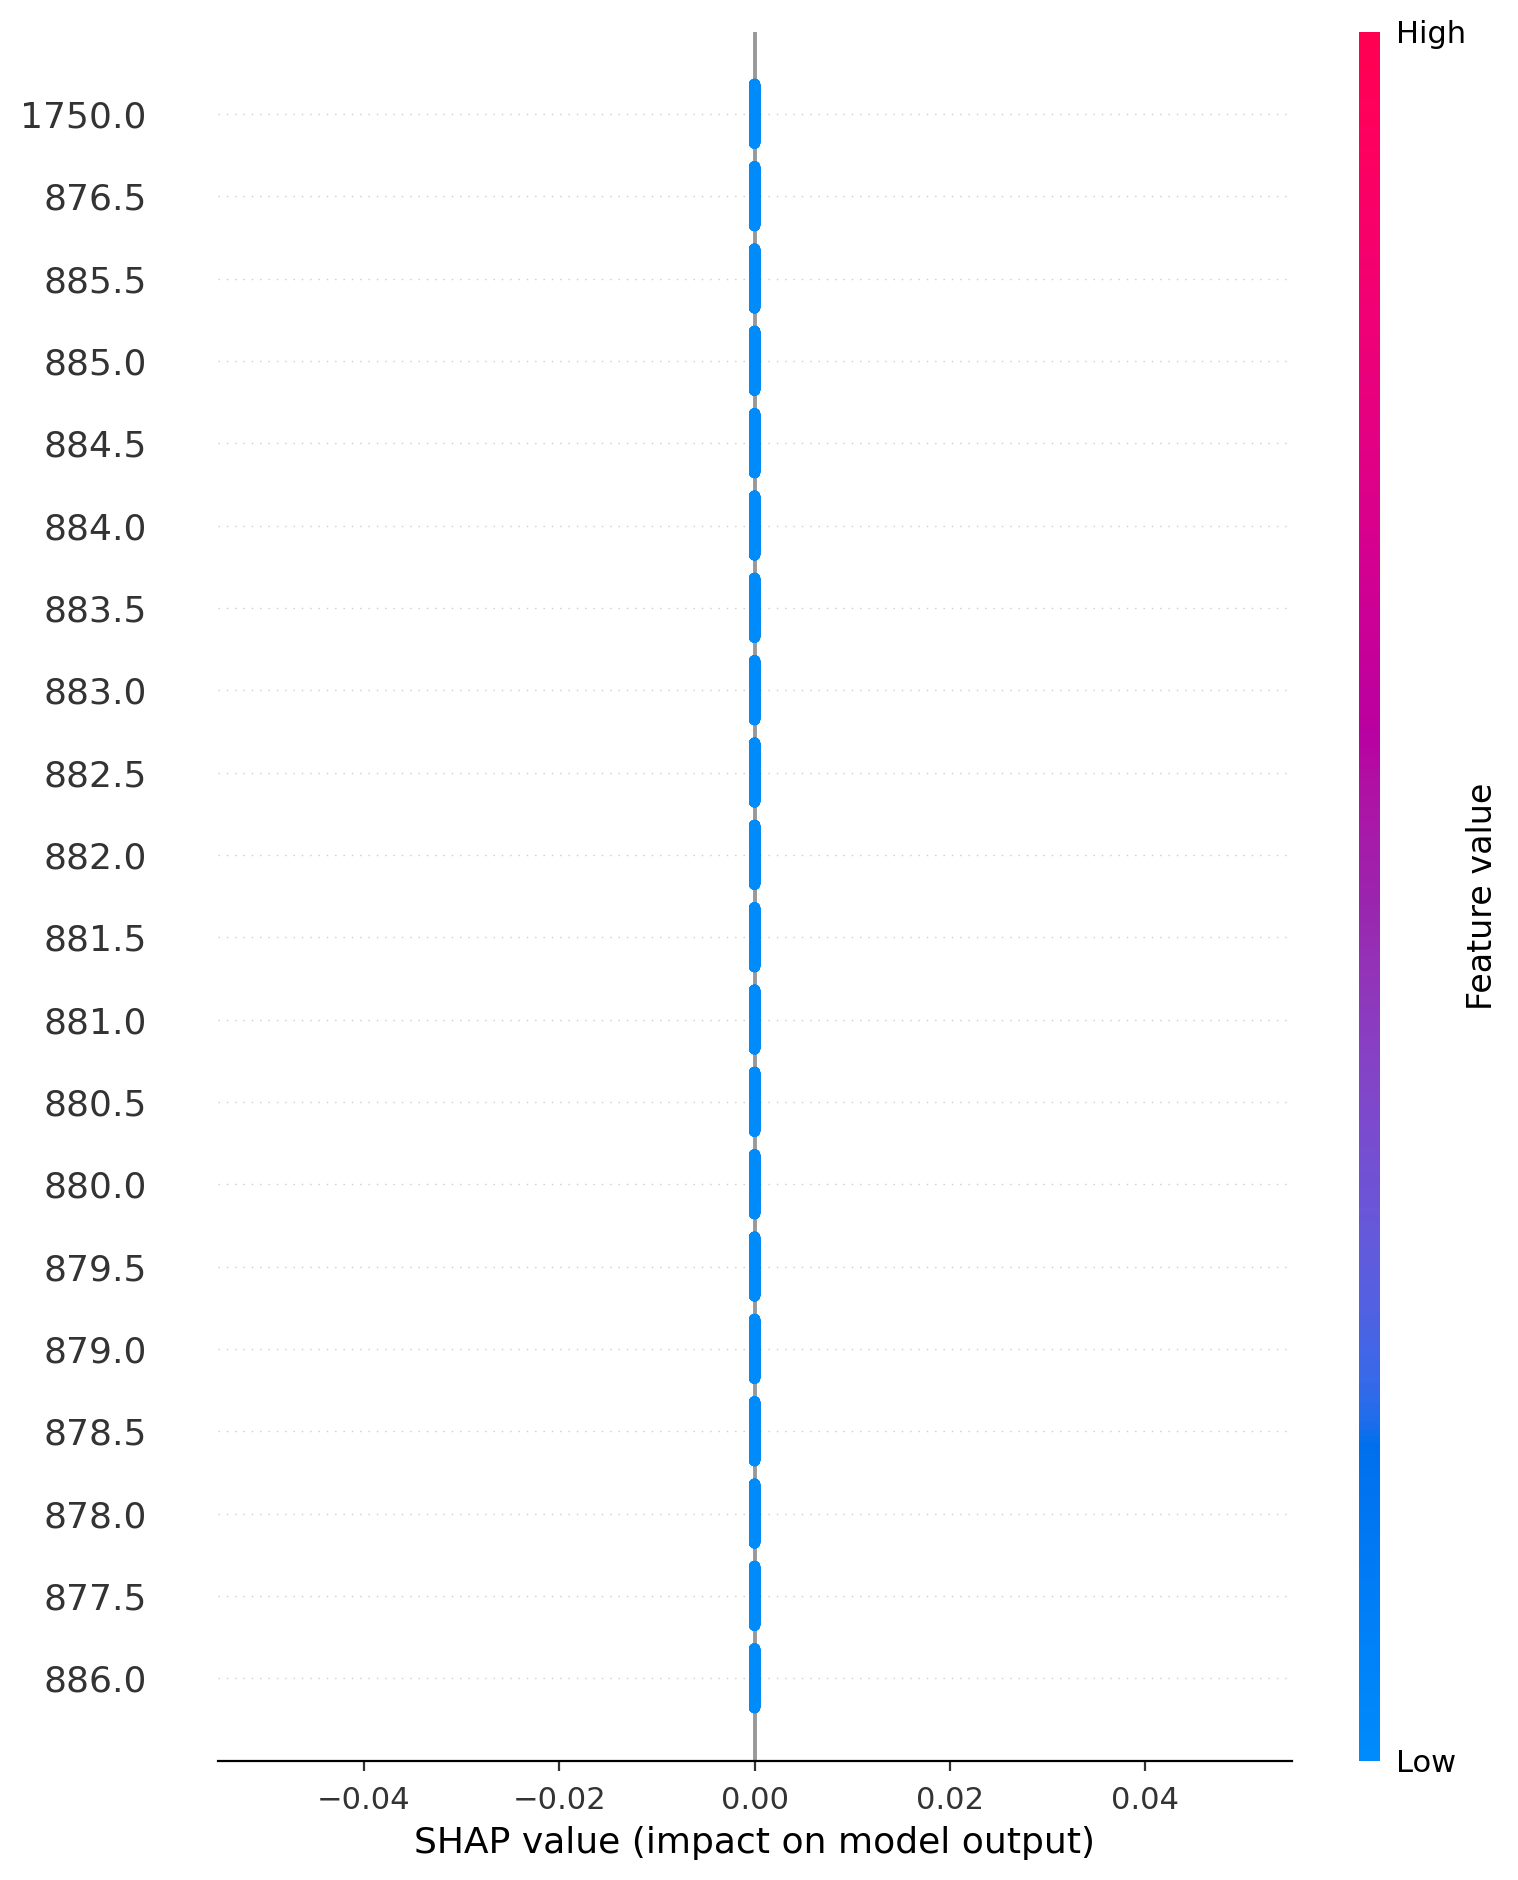

In [104]:
fig, ax = plt.subplots(figsize=(8, 12))
shap.summary_plot(explanation, feature_names=shap_features)

fig.savefig(img_path / "randomforest_shap.png", format="png", bbox_inches="tight")

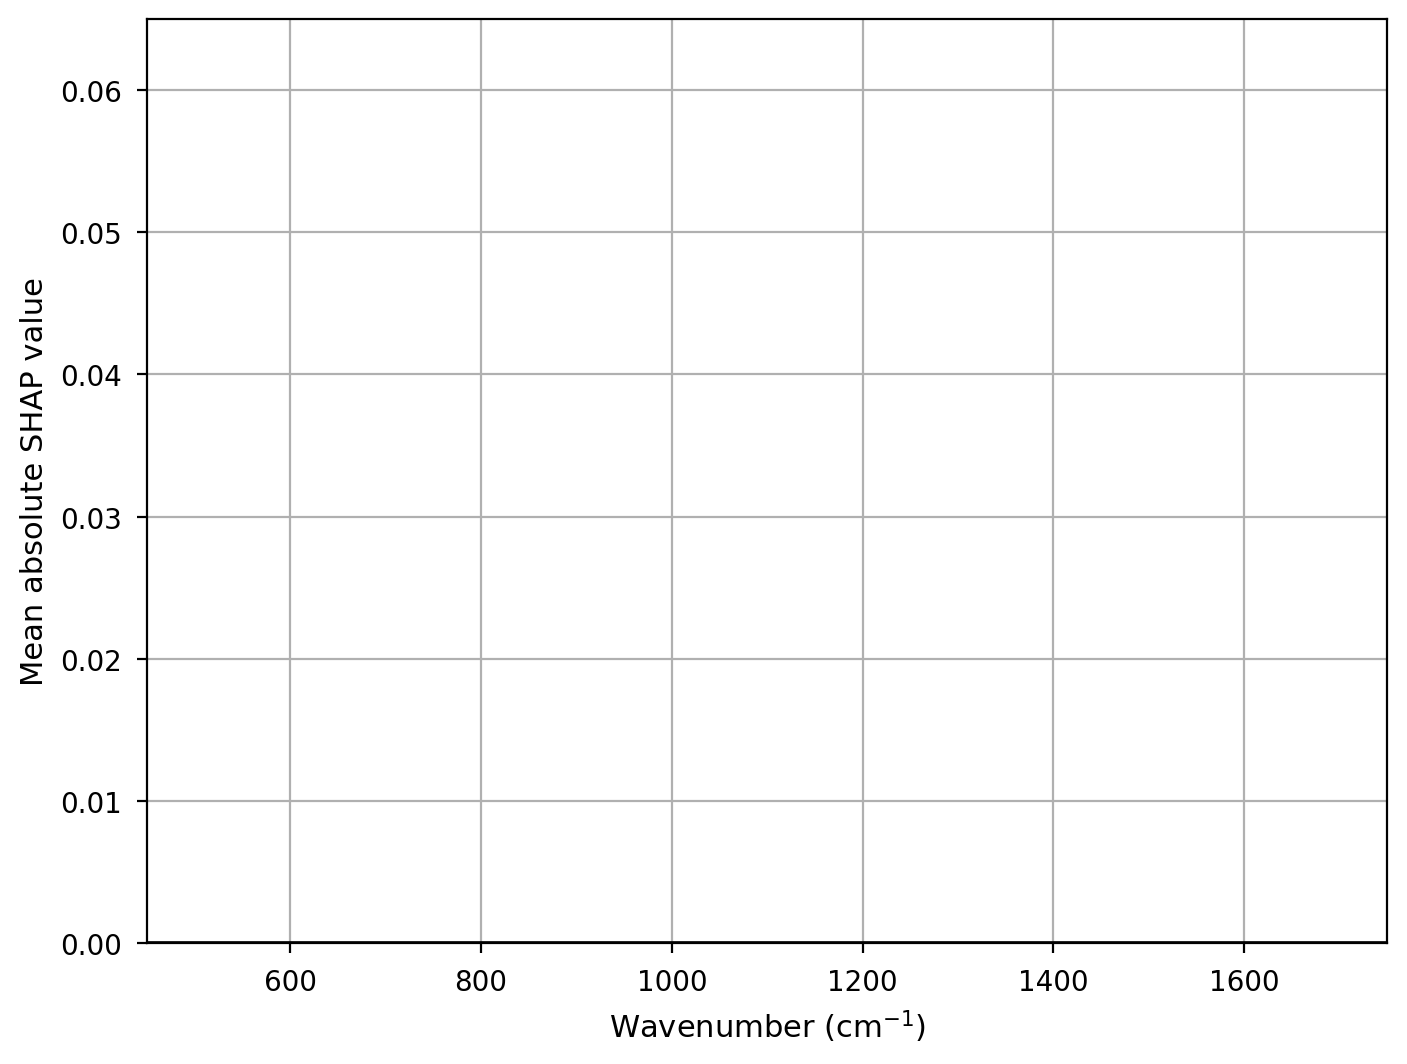

In [105]:
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

fig, ax = plt.subplots()
plot_coefs(shap_val_df, ax=ax, col=False, annotate=True, annot_kw={"min_height": 0.25, 
                                                        "min_dist": 50,
                                                        "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Mean absolute SHAP value")
ax.margins(x=0, y=0.15)
ax.set_ylim(0, None)
ax.grid()

## Gradient Boosted Trees
### Overview

In [107]:
current_path = results_path / "tree_based_models/gbdt/"
name = "Gradient-boosting"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
#f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_accuracy  test_accuracy   fit_time  predict_time       p_value
count       20.000000      20.000000  20.000000     20.000000  2.000000e+01
mean         0.999847       0.719722   7.092747      0.002390  1.169966e-56
std          0.000621       0.010215   0.584386      0.001355  5.180482e-56
min          0.997222       0.695556   6.670543      0.001694  4.336868e-65
25%          1.000000       0.711944   6.762317      0.001795  6.371354e-63
50%          1.000000       0.721111   6.896687      0.001873  1.366547e-61
75%          1.000000       0.726944   7.153424      0.002209  3.028310e-59
max          1.000000       0.734444   9.270420      0.007573  2.317892e-55

### Validation Curve

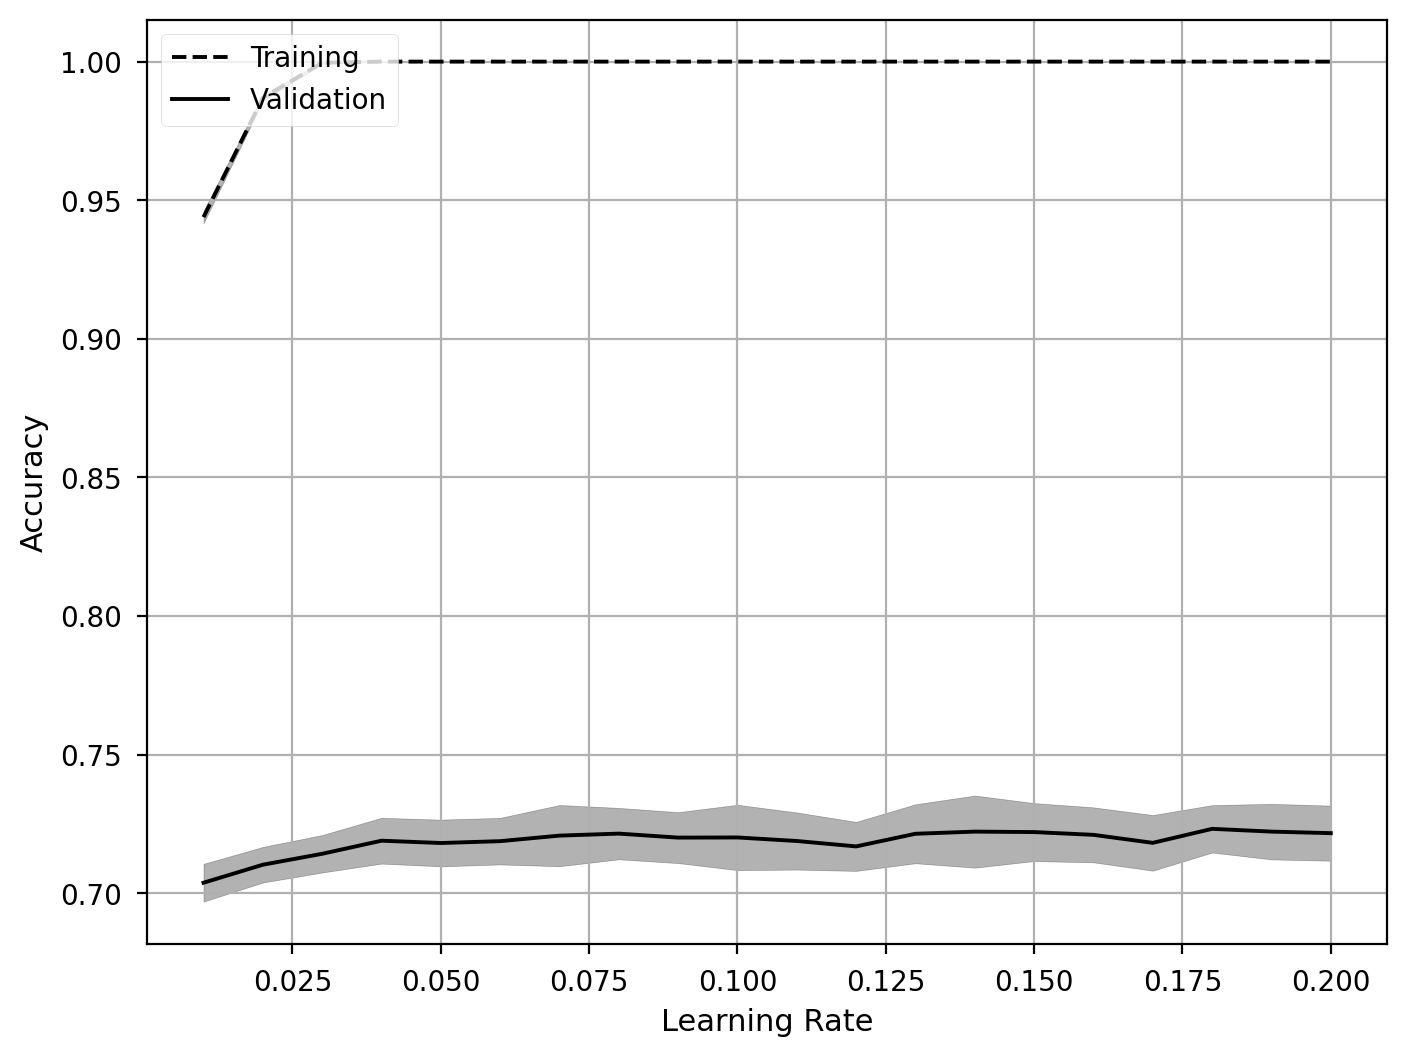

In [108]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Learning Rate")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

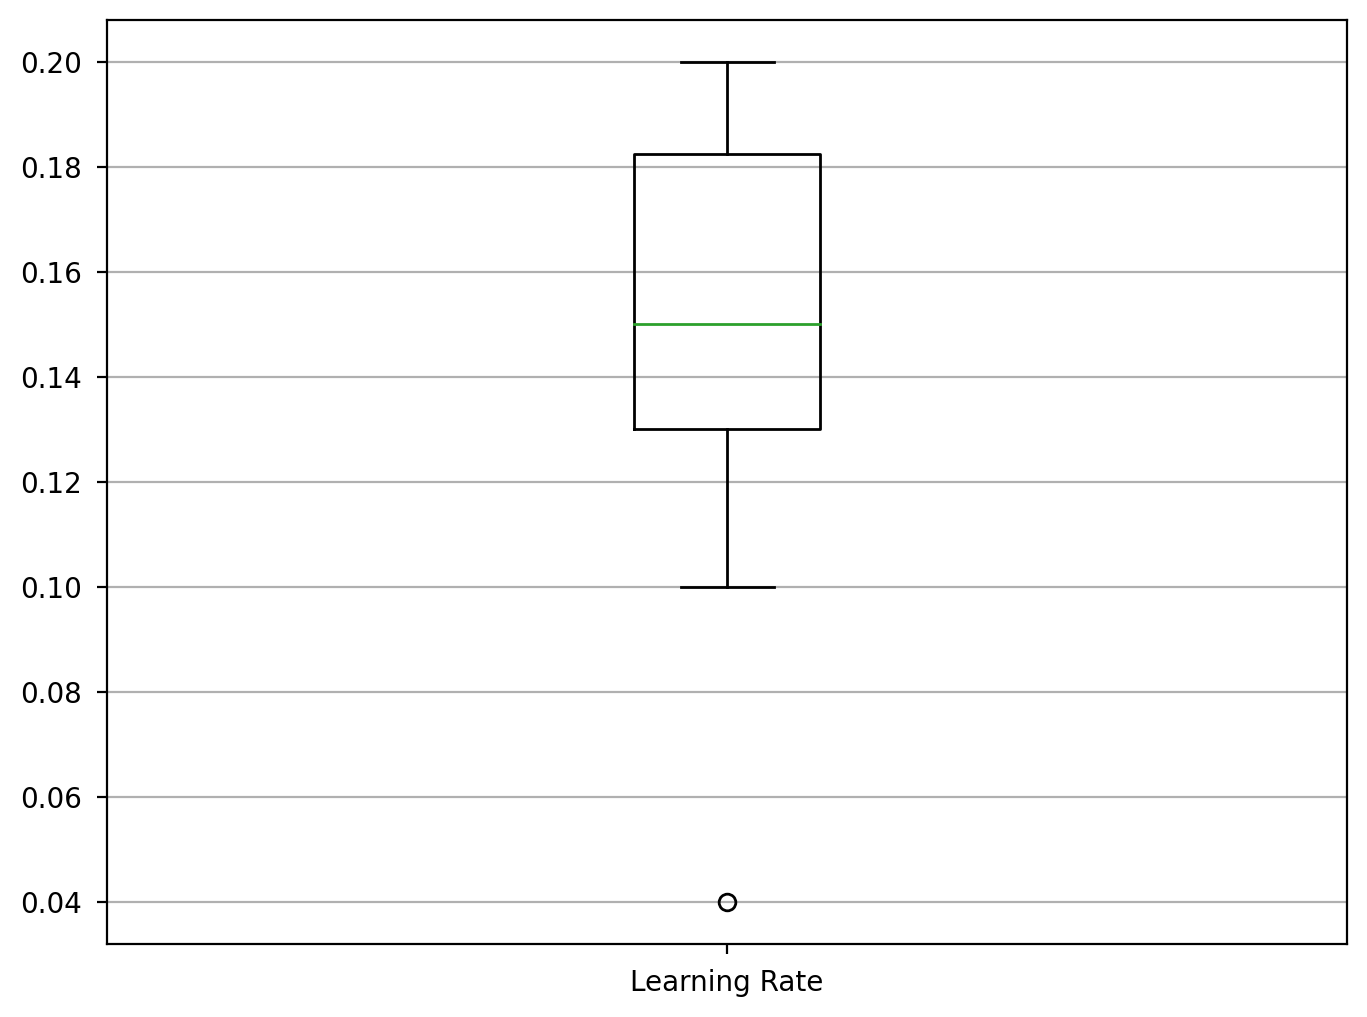

In [109]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Learning Rate"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

ValueError: Grouper and axis must be same length

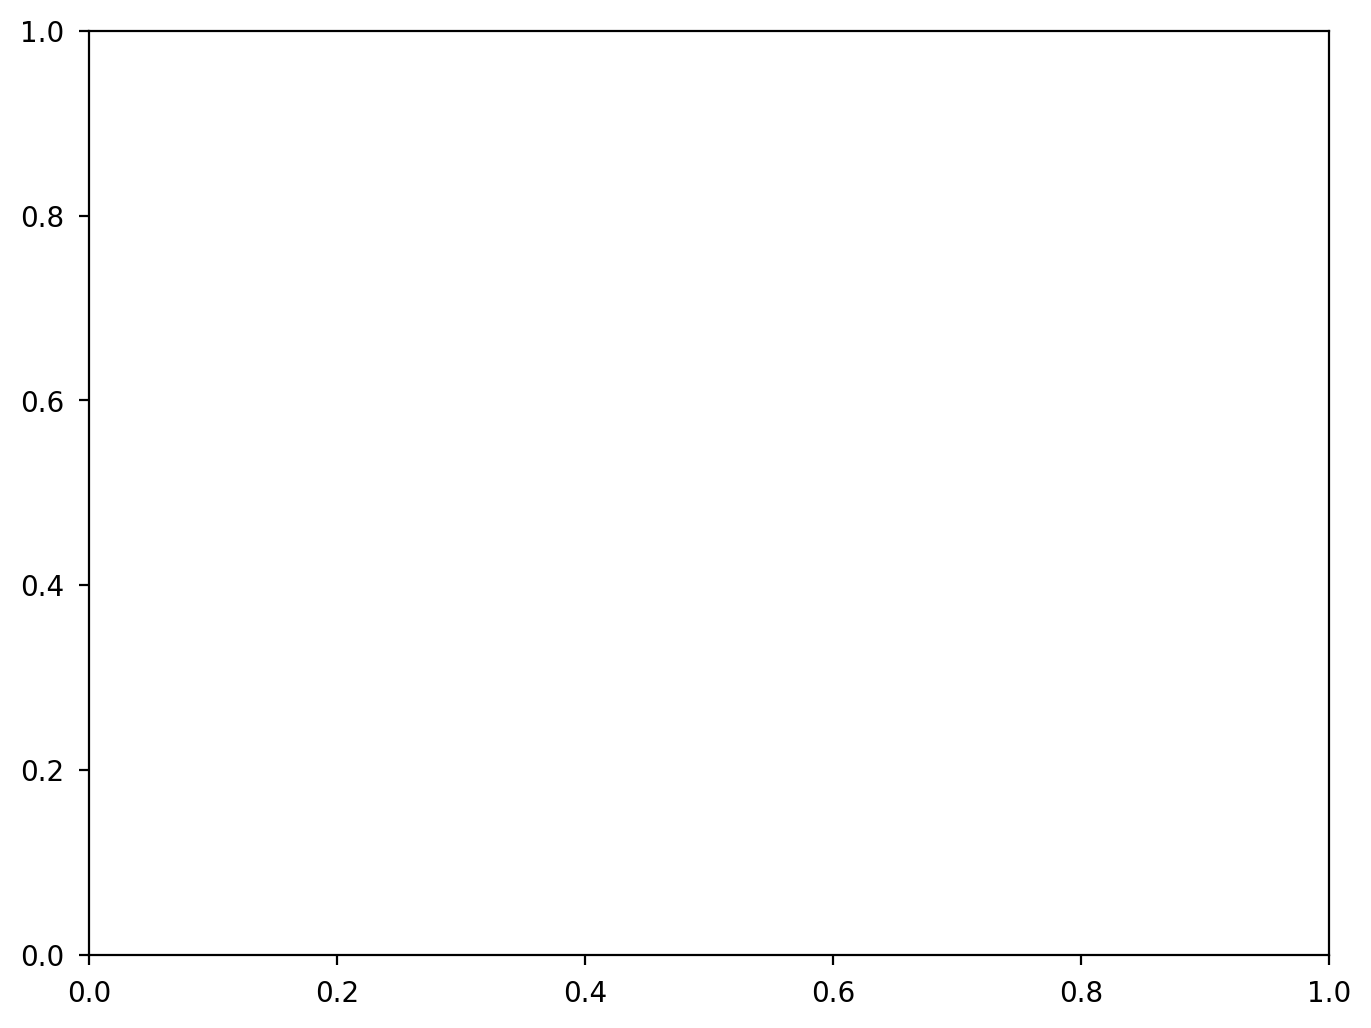

In [110]:
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(proba_df, y_key[y], y_key, ax=ax)
ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_yscale("logit")
ax.set_ylabel("Probability (-)")
ax.grid(axis="y")

### Confusion Matrix

ValueError: Found input variables with inconsistent numbers of samples: [1200, 900]

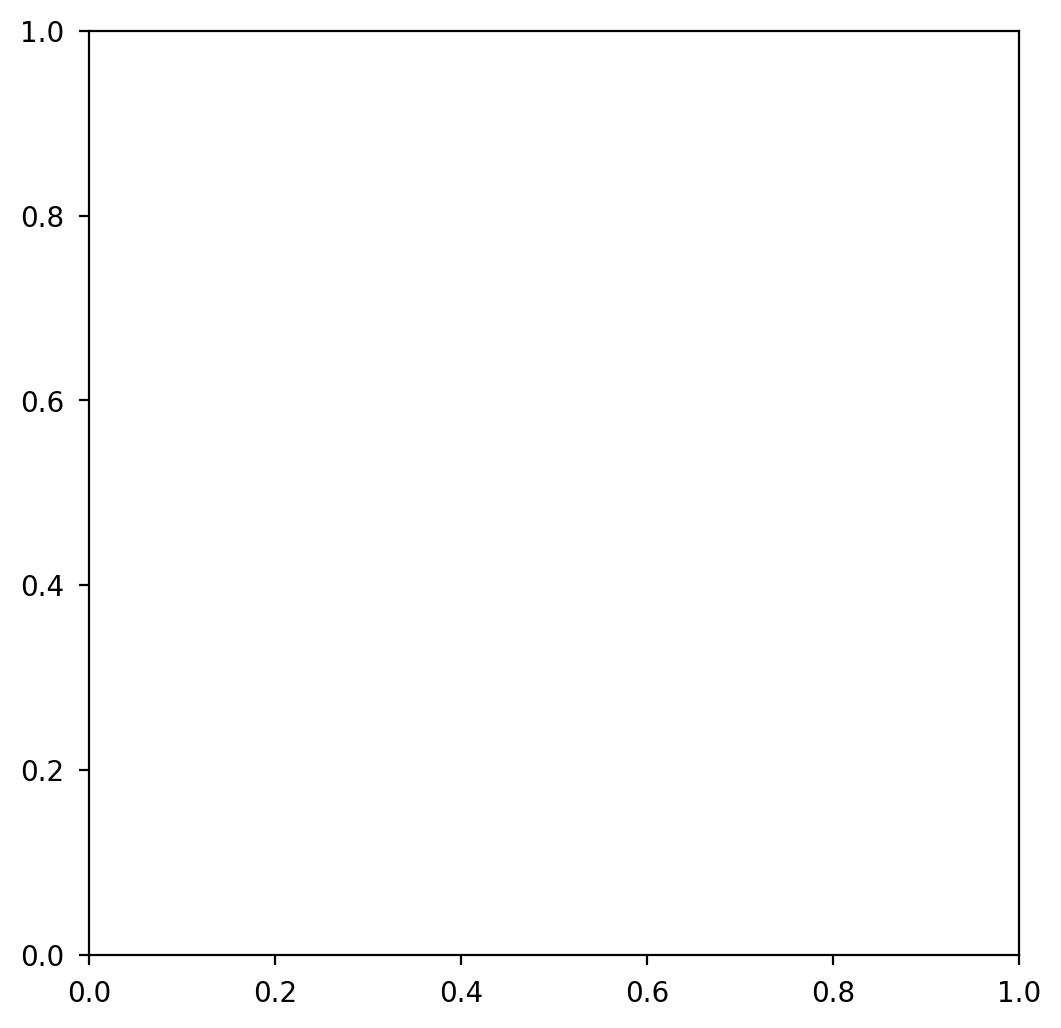

In [111]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

AxisError: axis 1 is out of bounds for array of dimension 1

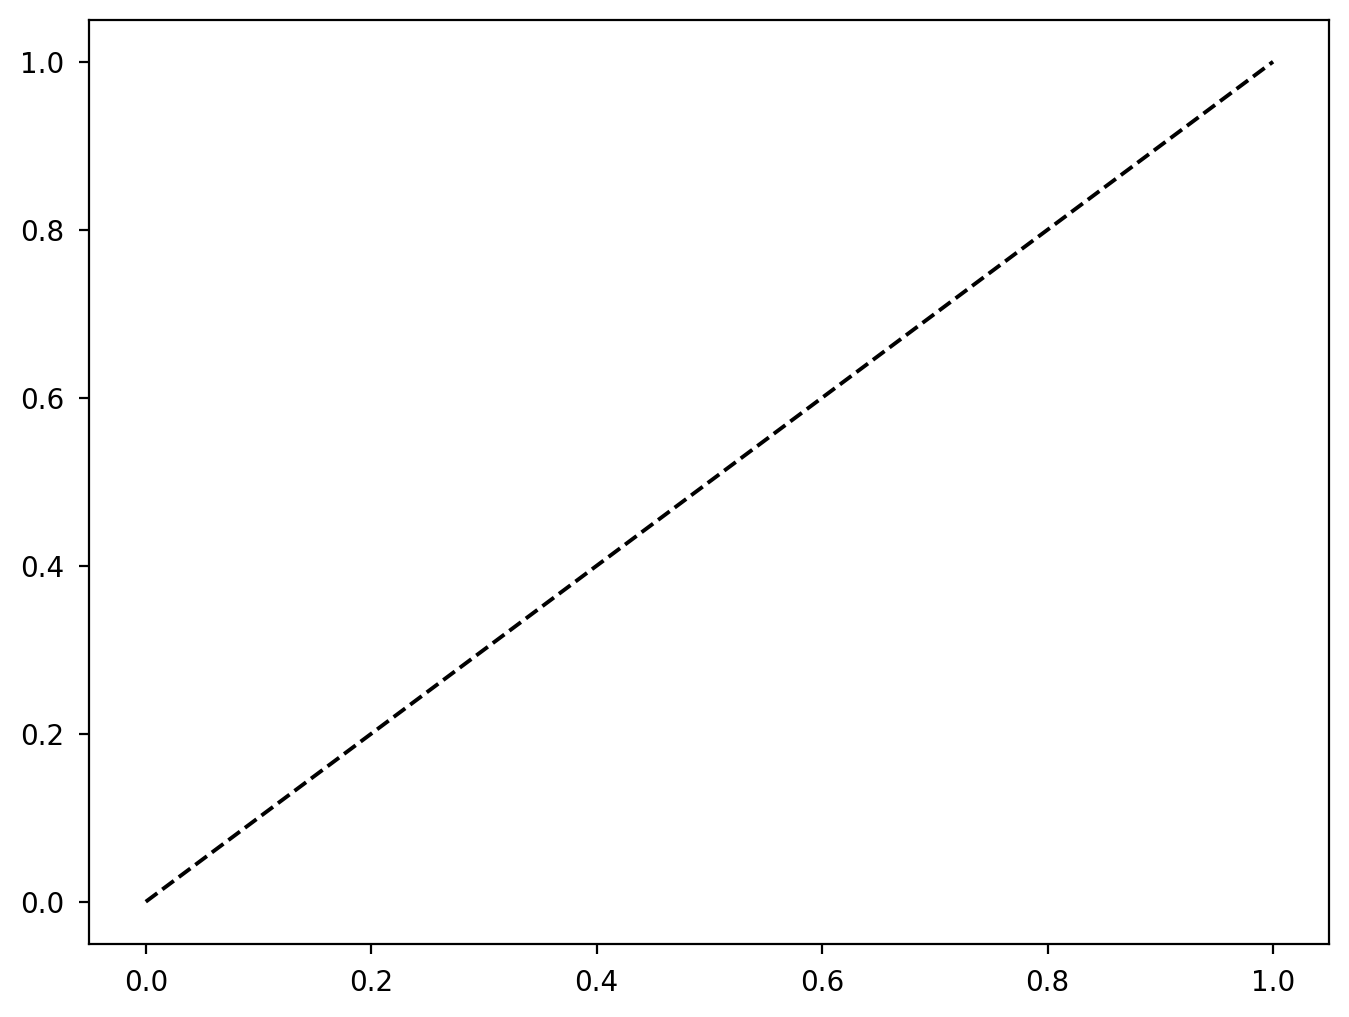

In [112]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(proba_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

### Explainable AI - SHAP

In [113]:
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)

In [114]:
fig, ax = plt.subplots()
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

fig.savefig(img_path / "gbdt_shap_waterfall.png", format="png", bbox_inches="tight")

ValueError: Image size of 1389027x1199 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1600x1300 with 3 Axes>

ValueError: Image size of 1389027x1199 pixels is too large. It must be less than 2^16 in each direction.

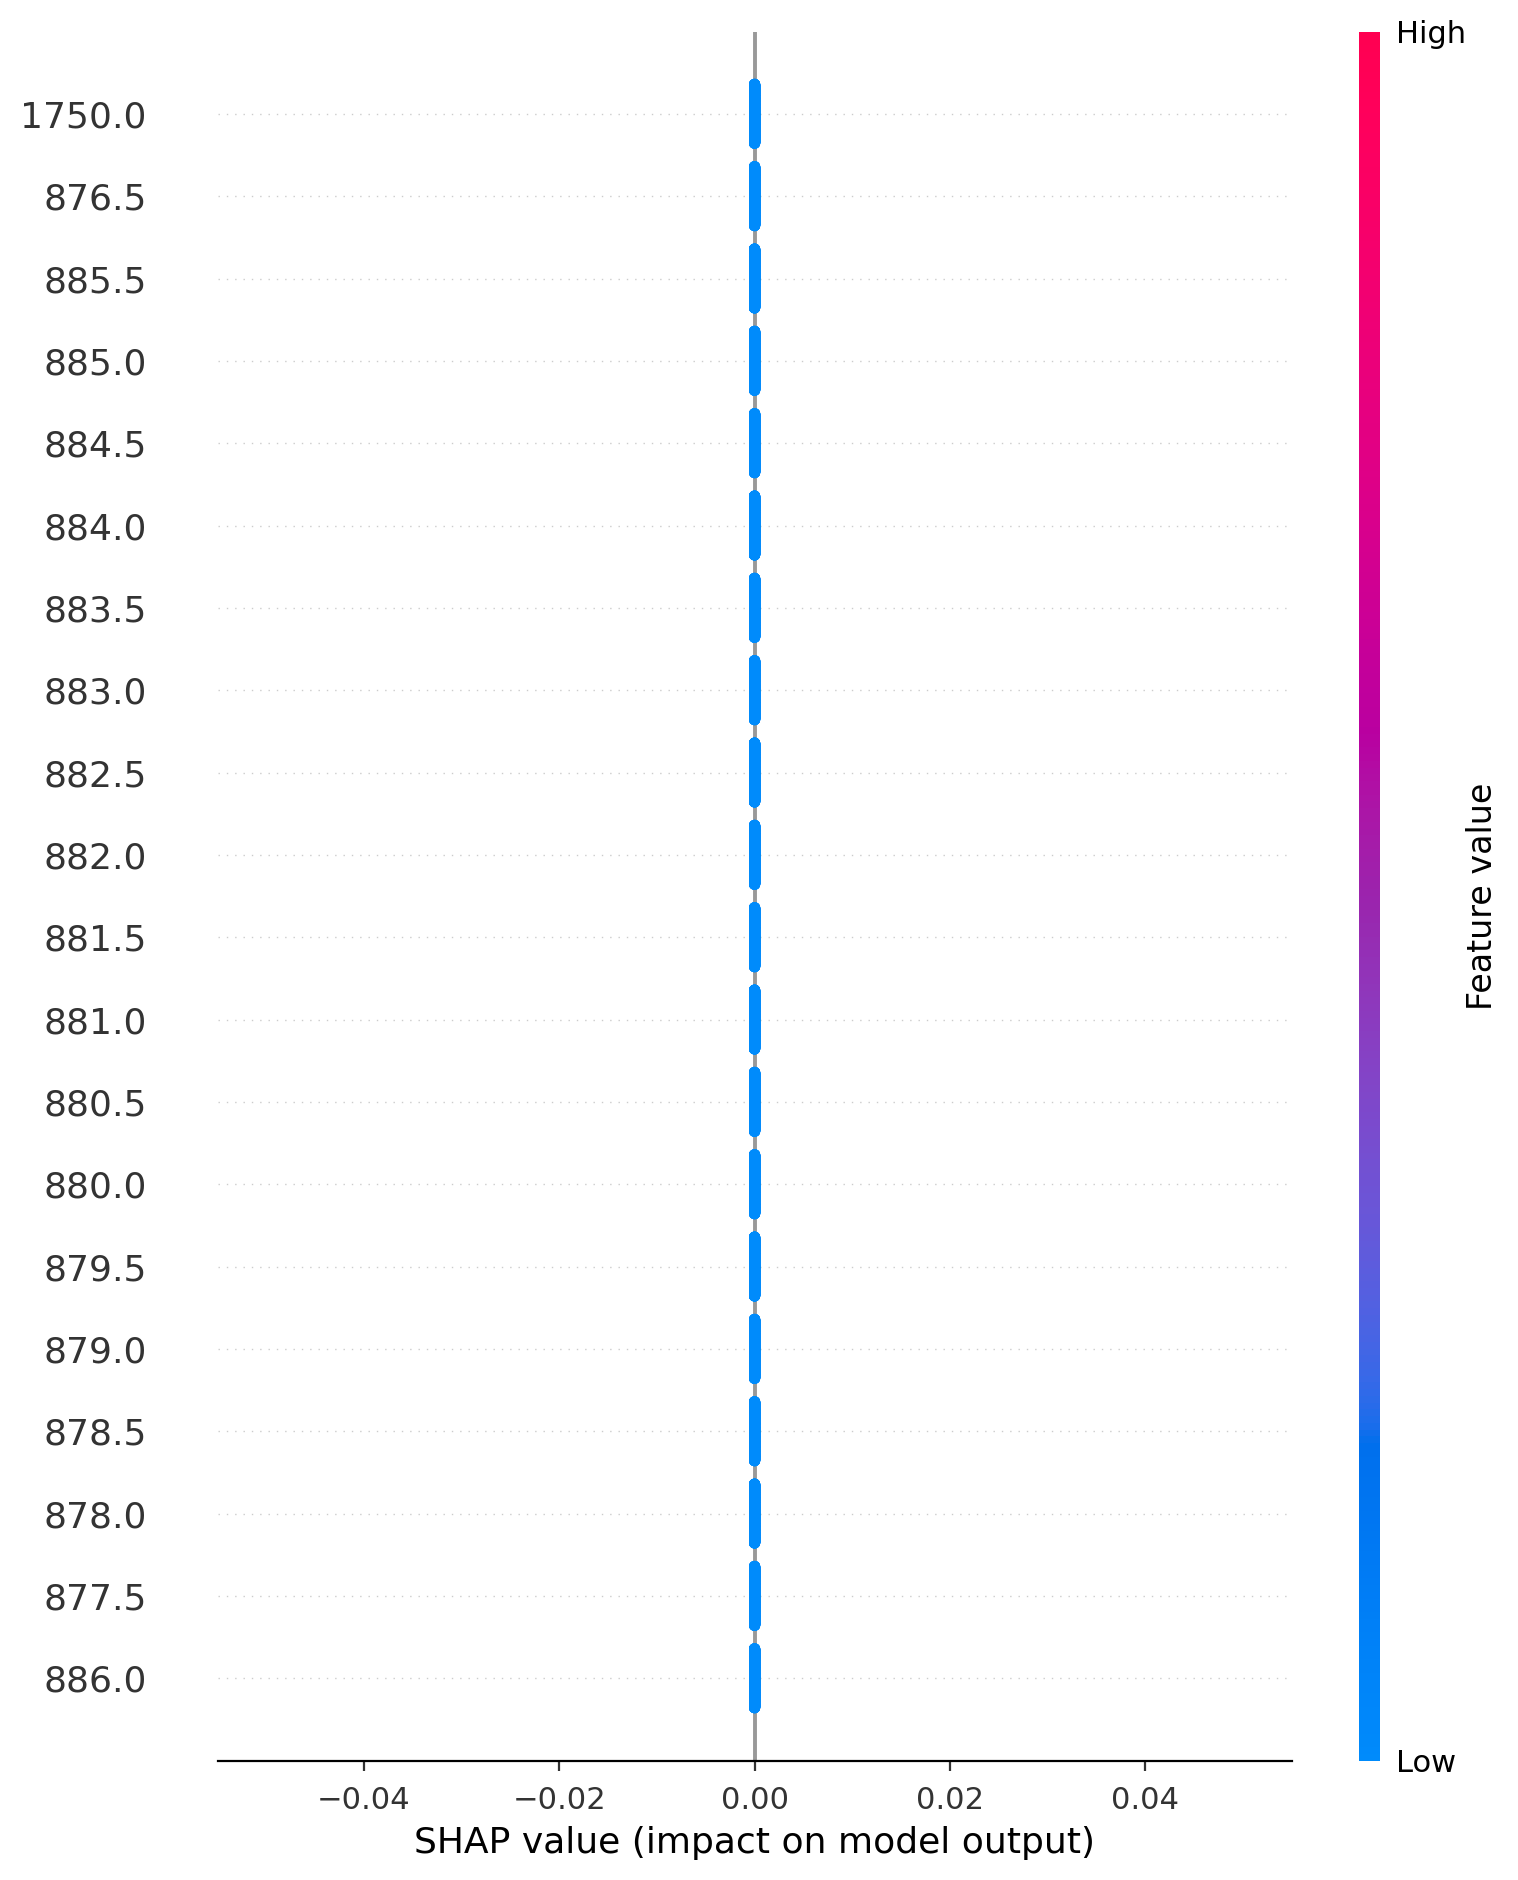

In [116]:
fig, ax = plt.subplots(figsize=(8, 12))
shap.summary_plot(explanation, feature_names=shap_features)

fig.savefig(img_path / "gbdt_shap.png", format="png", bbox_inches="tight")

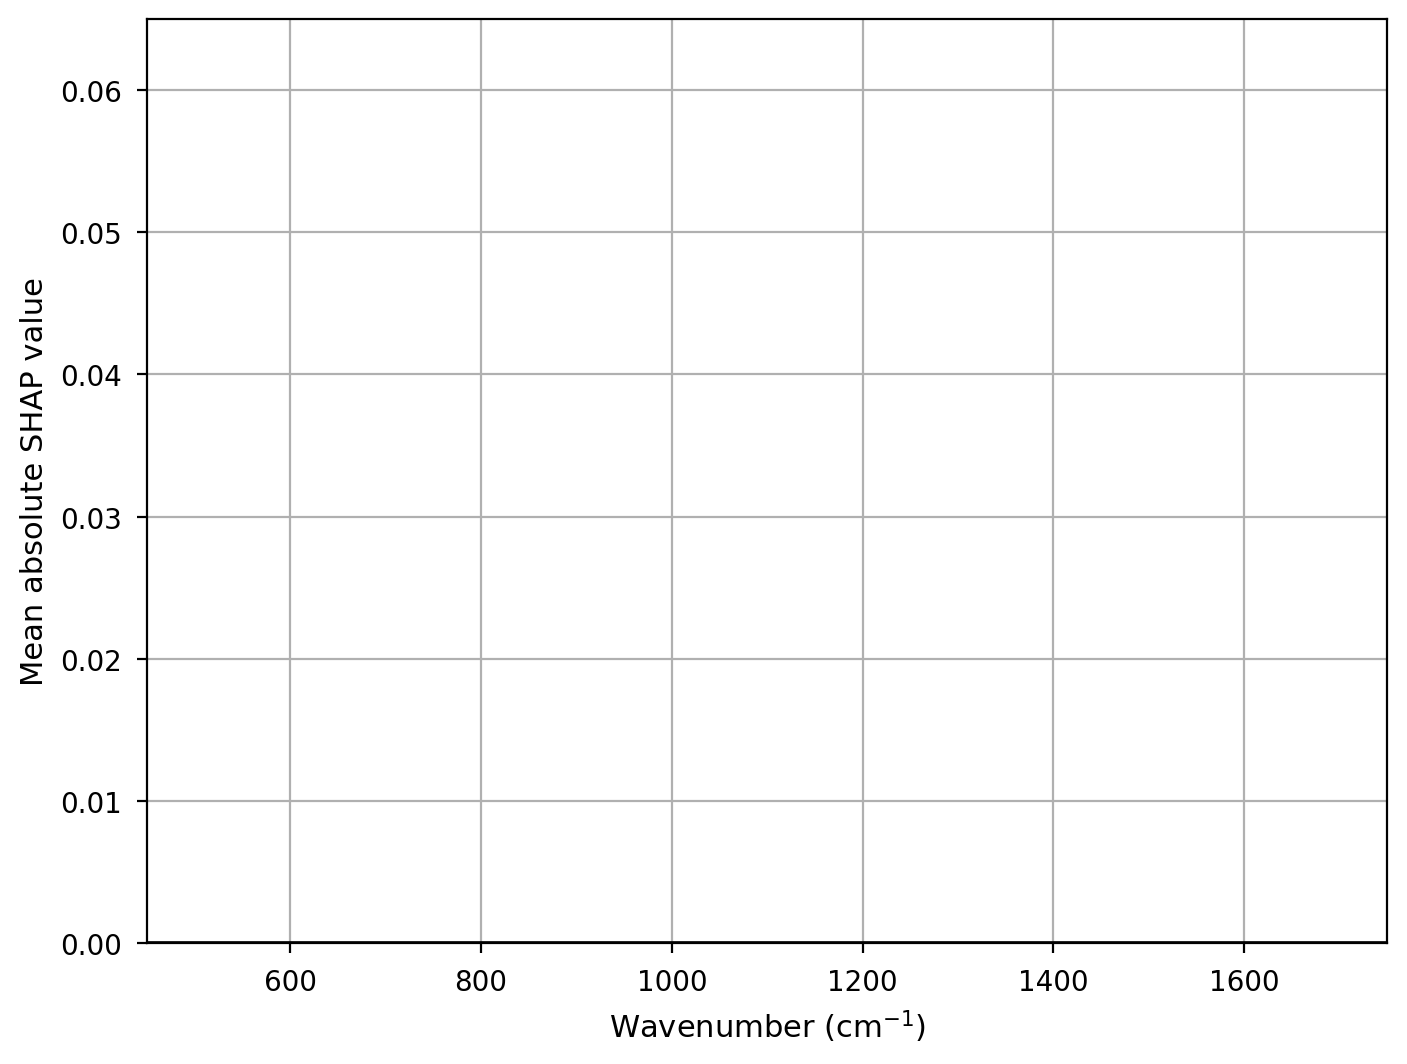

In [118]:
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

fig, ax = plt.subplots()
plot_coefs(shap_val_df, ax=ax, col=False, annotate=True, annot_kw={"min_height": 0.025, 
                                                                   "min_dist": 50,
                                                                   "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Mean absolute SHAP value")
ax.margins(x=0, y=0.15)
ax.set_ylim(0, None)
ax.grid()

## Comparison of Tree-based Models

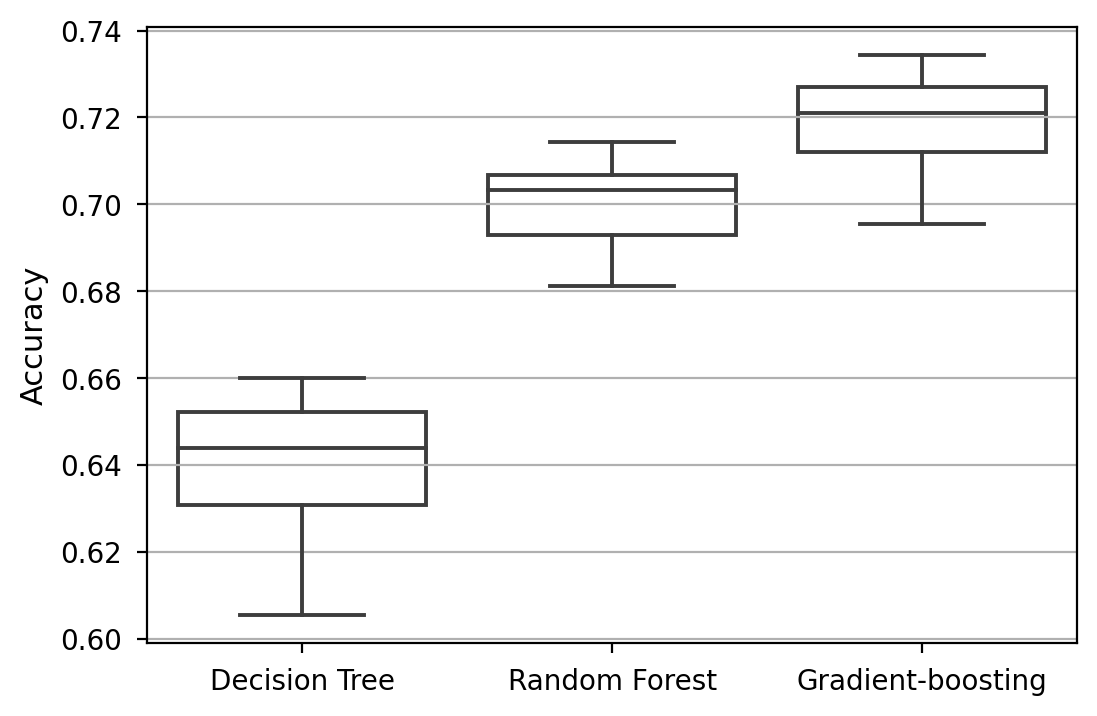

In [119]:
fig, ax = plt.subplots(figsize=(6,4))
boxplot_comparison(accs, regex="Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Accuracy")

fig.savefig(img_path / "tree_accuracy.png", format="png", bbox_inches="tight")

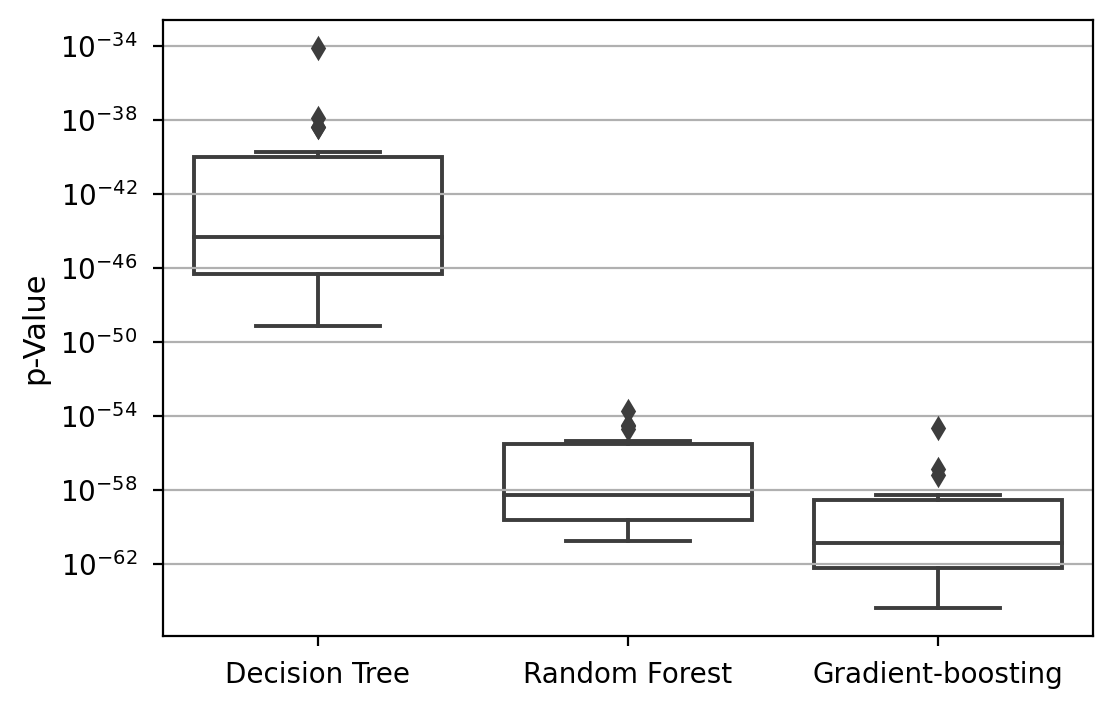

In [120]:
fig, ax = plt.subplots(figsize=(6,4))
boxplot_comparison(p_vals, regex="Tree|Forest|Gradient")

ax.set_yscale("log")
ax.grid(axis="y")
ax.set_ylabel("p-Value")

fig.savefig(img_path / "tree_pval.png", format="png", bbox_inches="tight")

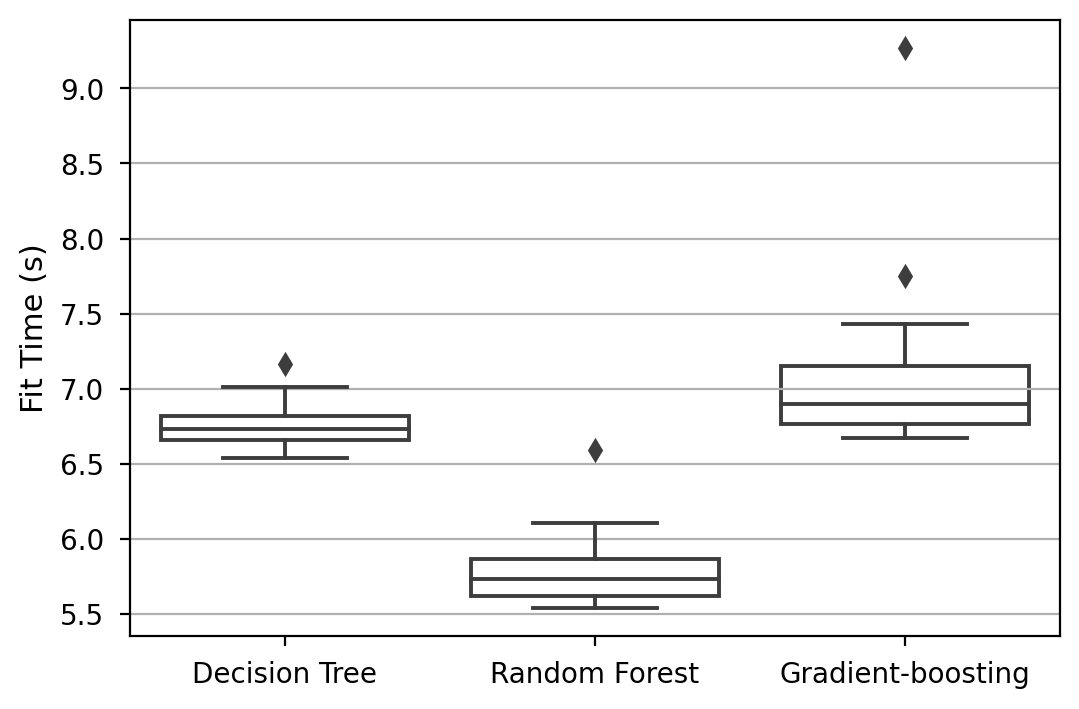

In [121]:
fig, ax = plt.subplots(figsize=(6,4))
boxplot_comparison(fit_times, regex="Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Fit Time (s)")

fig.savefig(img_path / "tree_fittime.png", format="png", bbox_inches="tight")

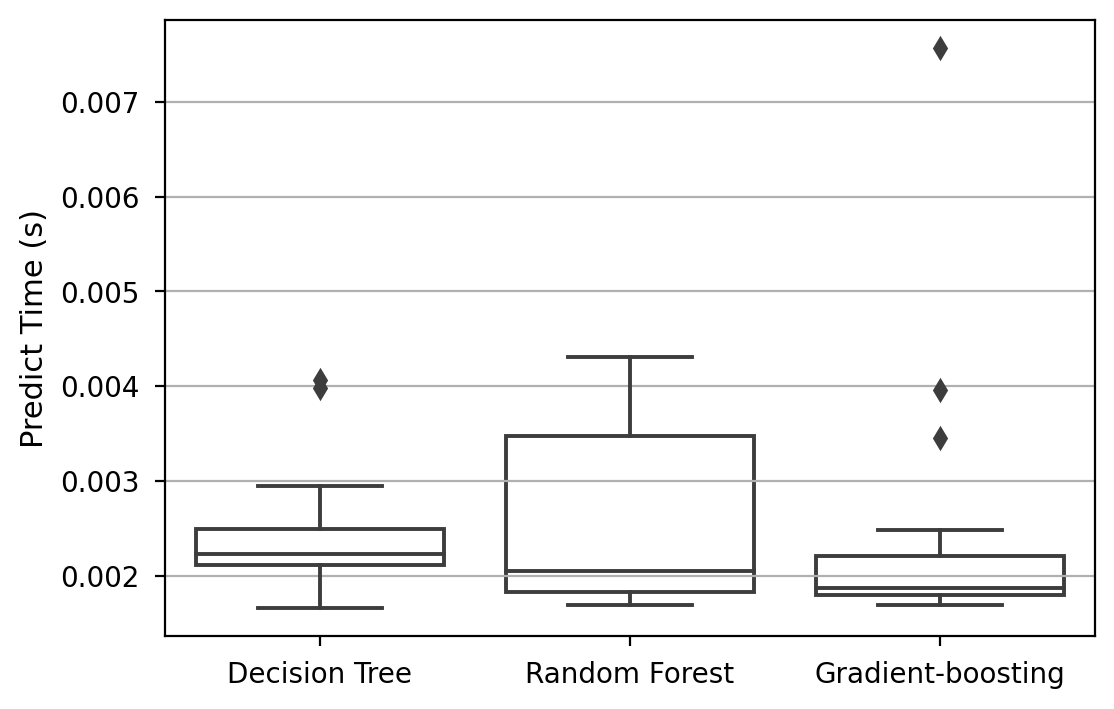

In [122]:
fig, ax = plt.subplots(figsize=(6,4))
boxplot_comparison(predict_times, regex="Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Predict Time (s)")

fig.savefig(img_path / "tree_predicttime.png", format="png", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


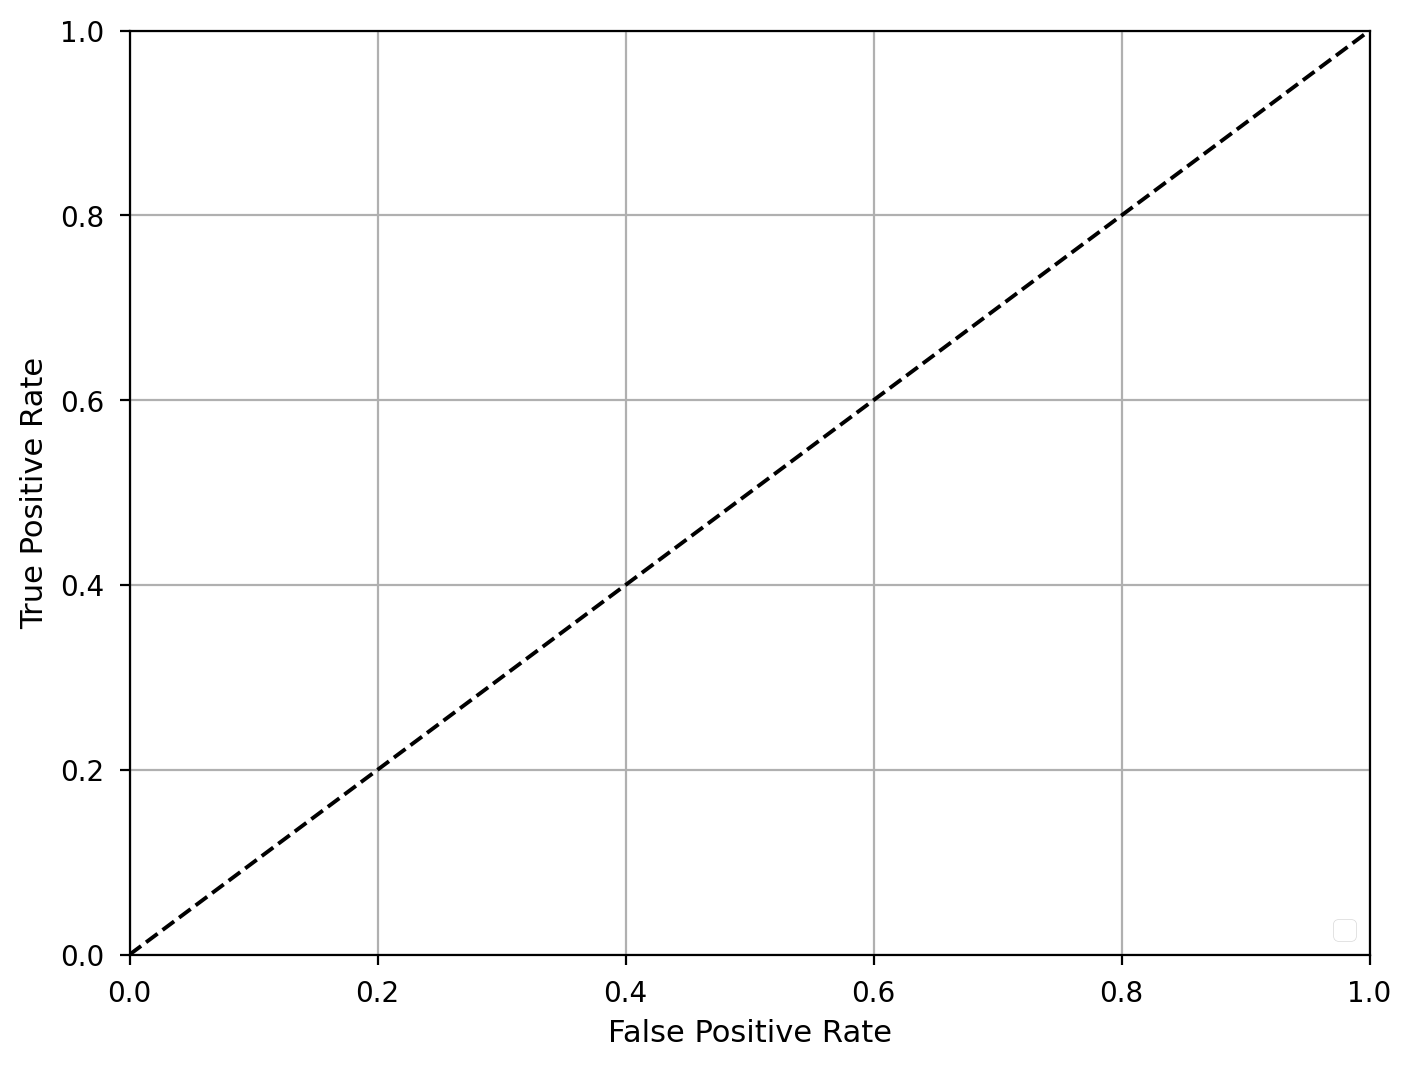

In [123]:
fig, ax = plt.subplots()
plot_roc_comparison(rocs, aucs, ax=ax, regex="Tree|Forest|Gradient")

ax.grid()
ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

fig.savefig(img_path / "tree_roc.png", format="png", bbox_inches="tight")

## Overall Comparison

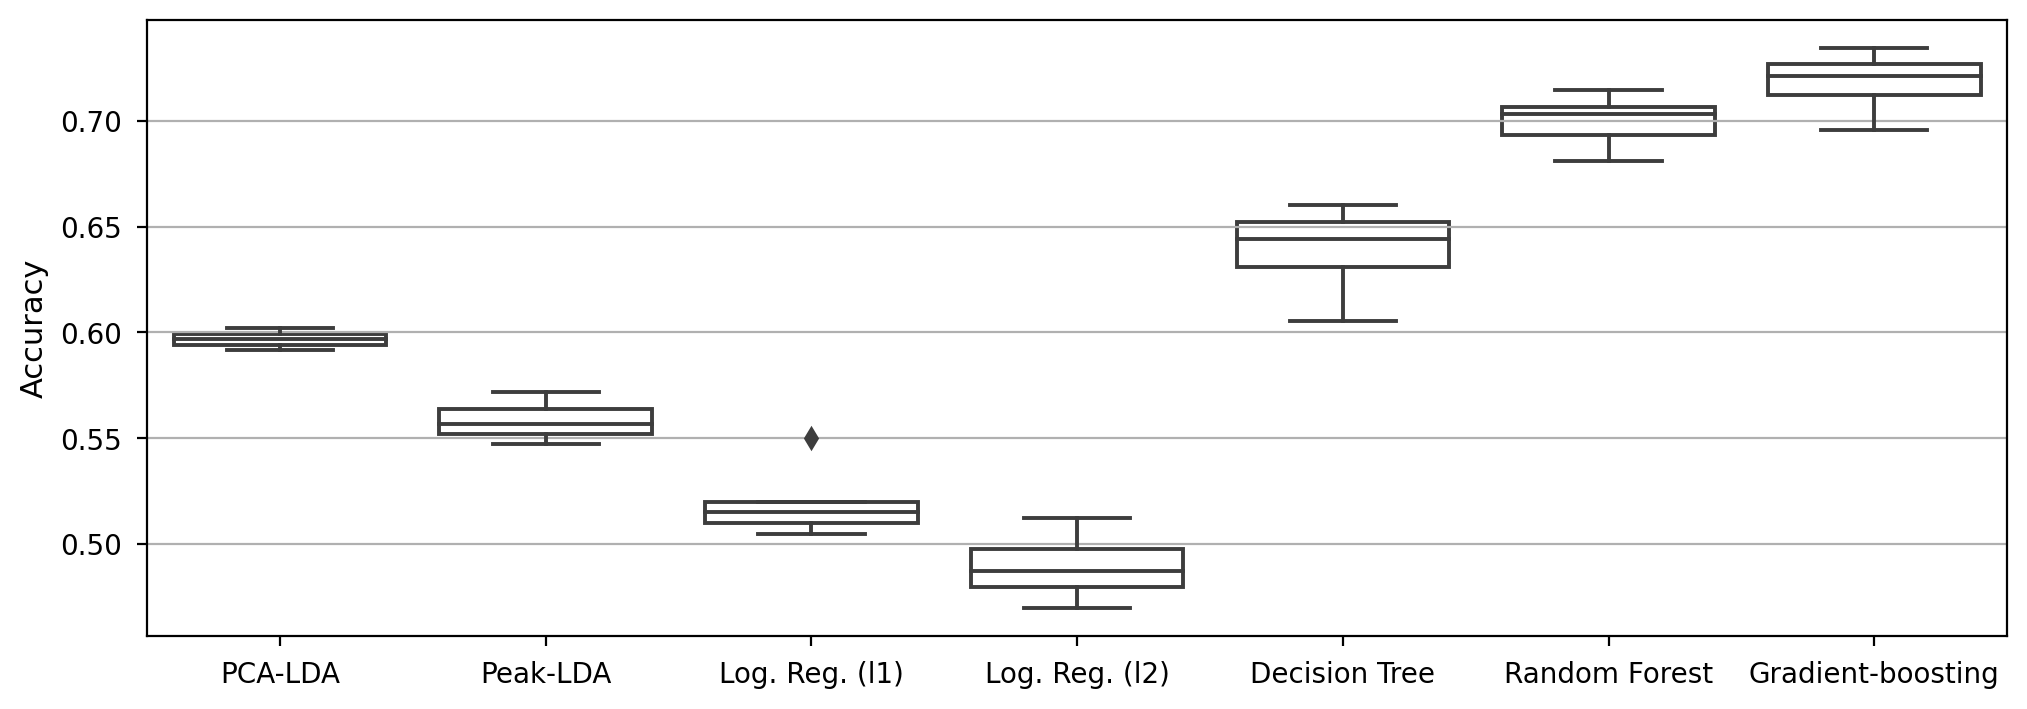

In [124]:
fig, ax = plt.subplots(figsize=(12,4)) #12,4
boxplot_comparison(accs, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Accuracy")

fig.savefig(img_path / "all_accuracy.png", format="png", bbox_inches="tight")

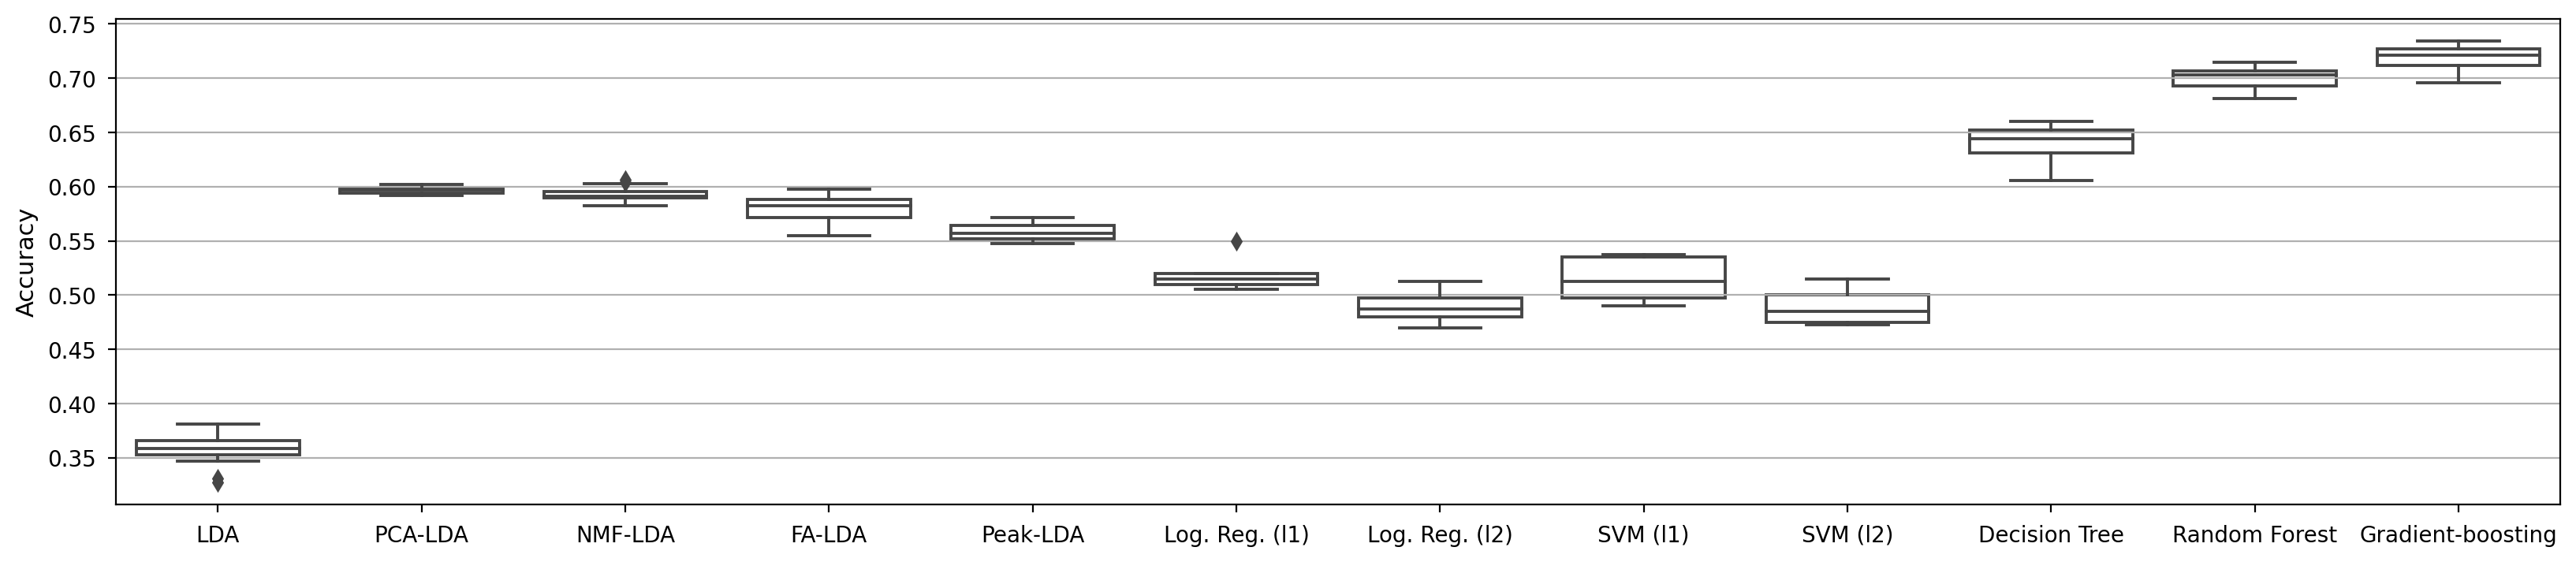

In [125]:
### all methods

fig, ax = plt.subplots(figsize=(20,4)) #12,4
boxplot_comparison(accs)

ax.grid(axis="y")
ax.set_ylabel("Accuracy")

fig.savefig(img_path / "all_accuracy.png", format="png", bbox_inches="tight")

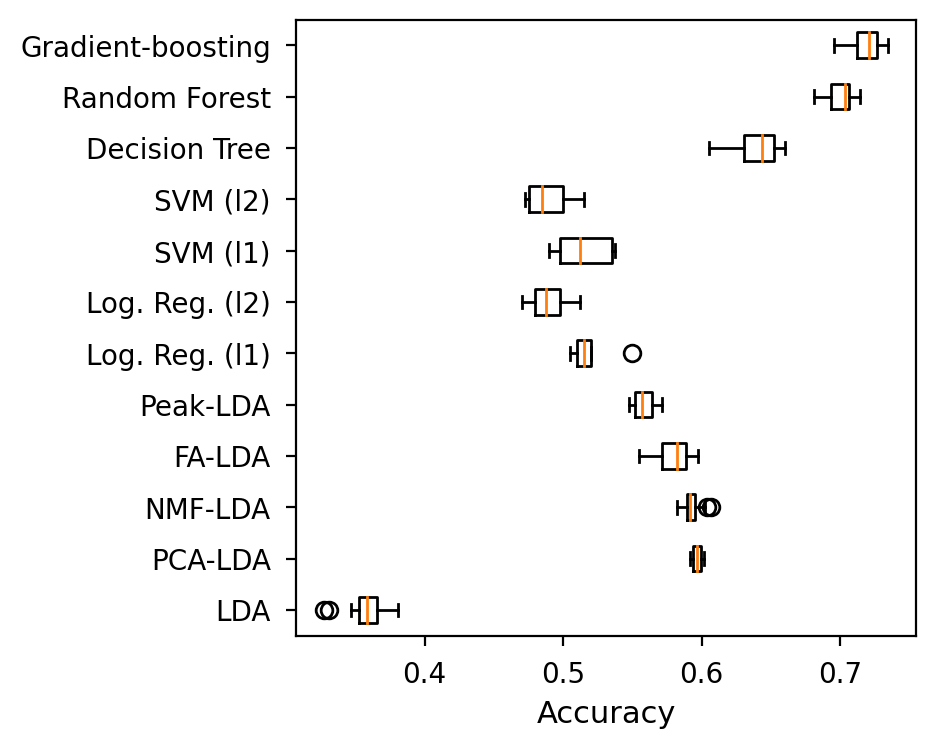

In [126]:
### transposed plot, needed to switch keys with value pair of dict in order to transpose
### another possibilty is adapting the visualization.py in lib/raman lib

fig, ax = plt.subplots(figsize=(4,4)) #12,4

accs_keys = list(accs.keys())
accs_values = list(accs.values())
comp = ax.boxplot(accs_values, labels=accs_keys, vert=False)
ax.set_xlabel("Accuracy")

fig.savefig(img_path / "all_accuracy_T.png", format="png", bbox_inches="tight")

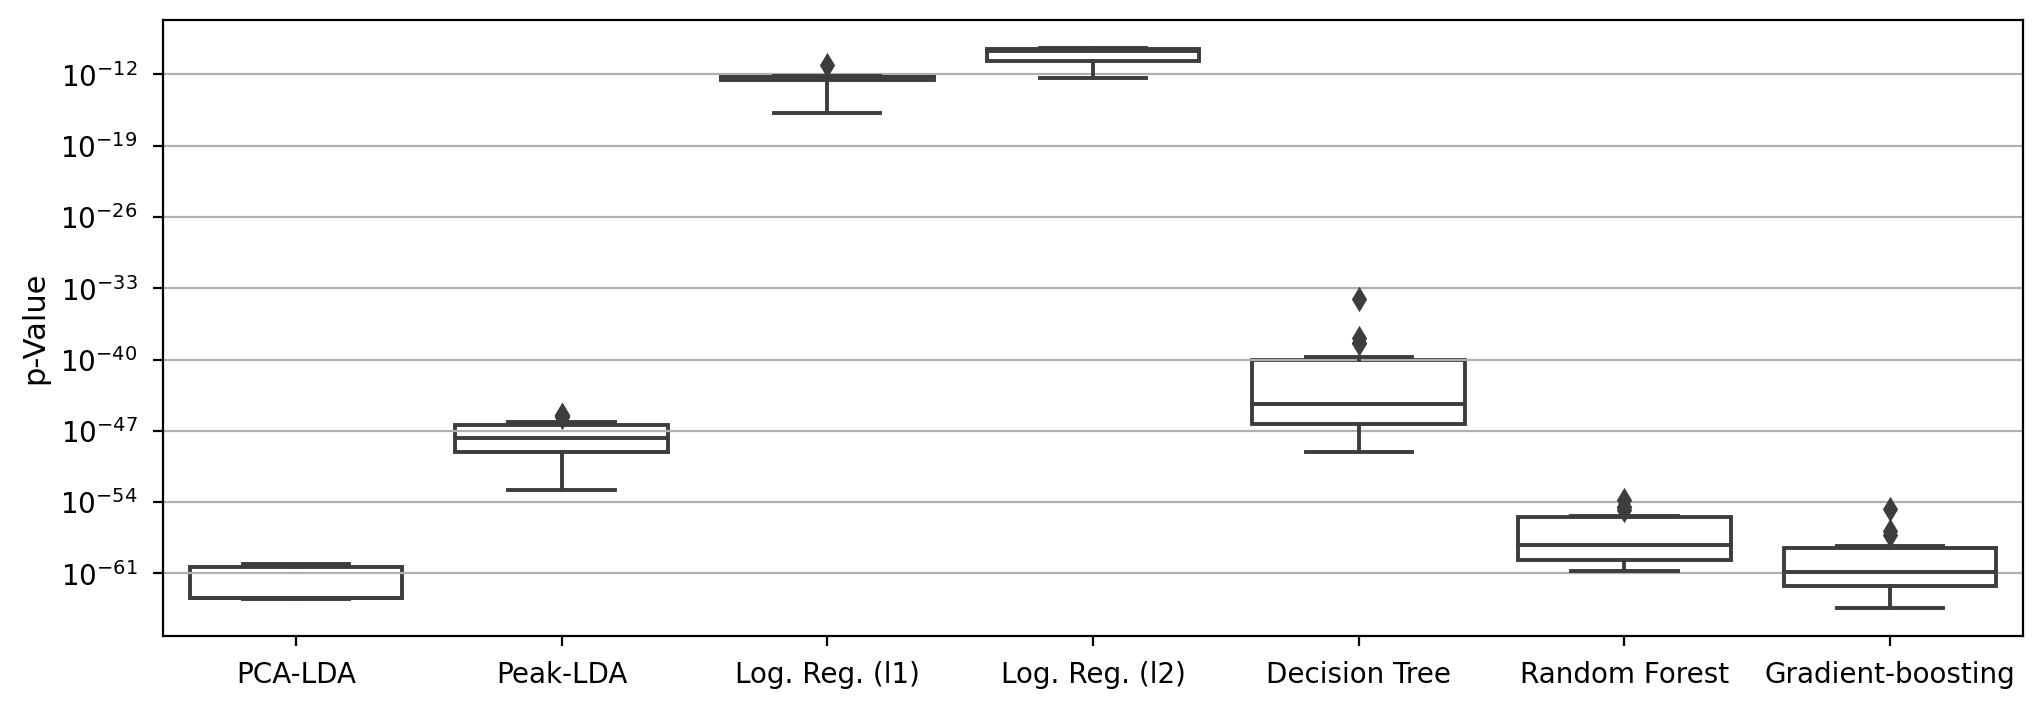

In [127]:
fig, ax = plt.subplots(figsize=(12,4))
boxplot_comparison(p_vals, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")

ax.set_yscale("log")
ax.grid(axis="y")
ax.set_ylabel("p-Value")

fig.savefig(img_path / "all_pval.png", format="png", bbox_inches="tight")

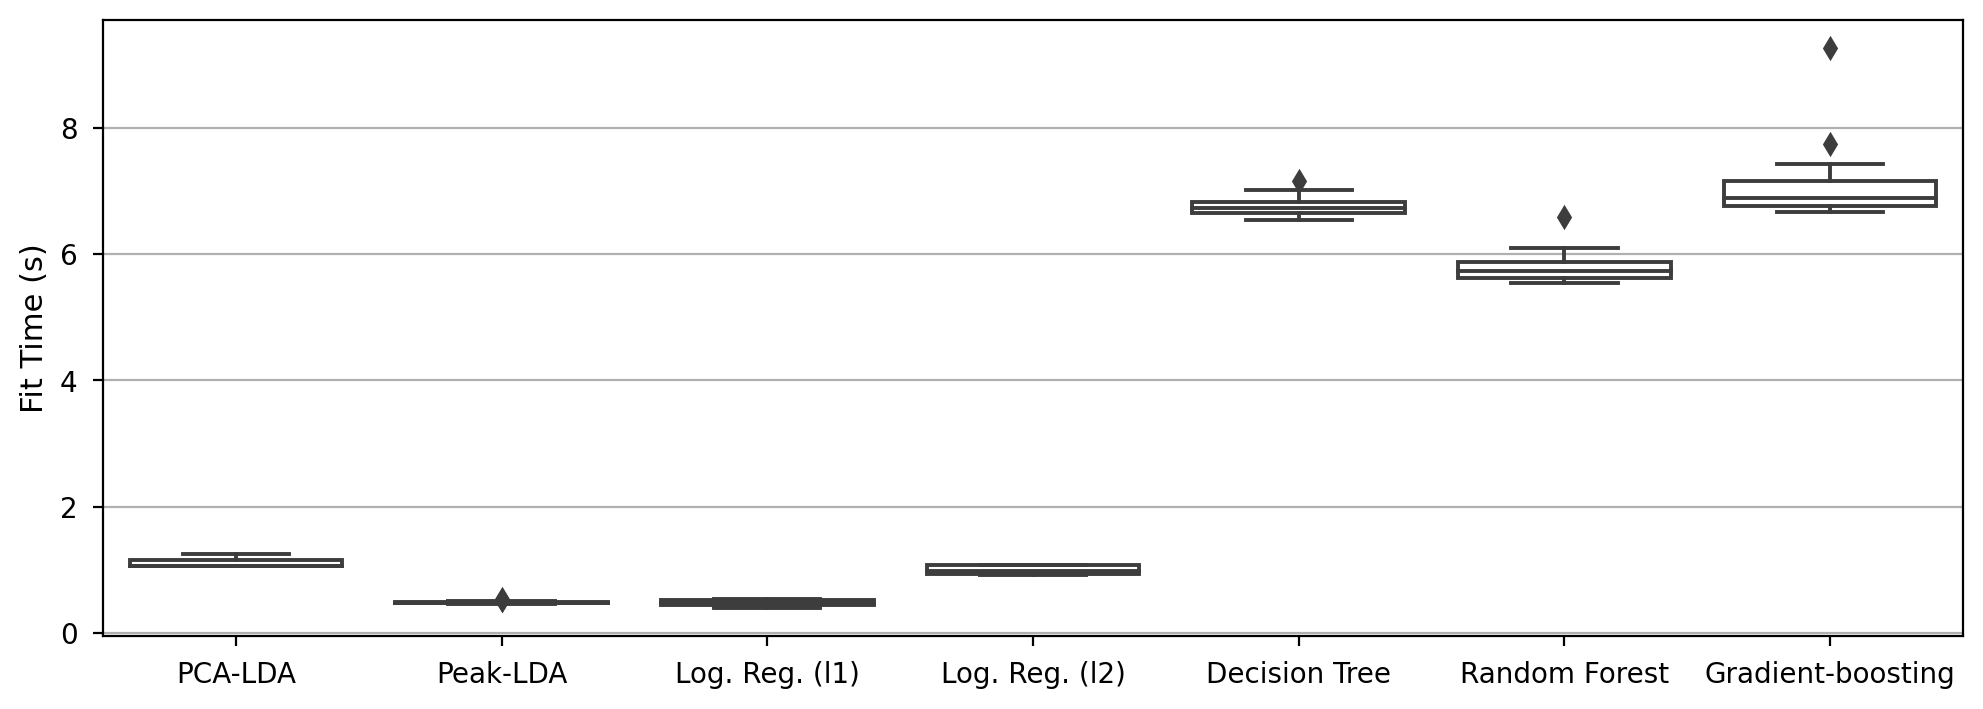

In [128]:
fig, ax = plt.subplots(figsize=(12,4))
boxplot_comparison(fit_times, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Fit Time (s)")

fig.savefig(img_path / "all_fittime.png", format="png", bbox_inches="tight")

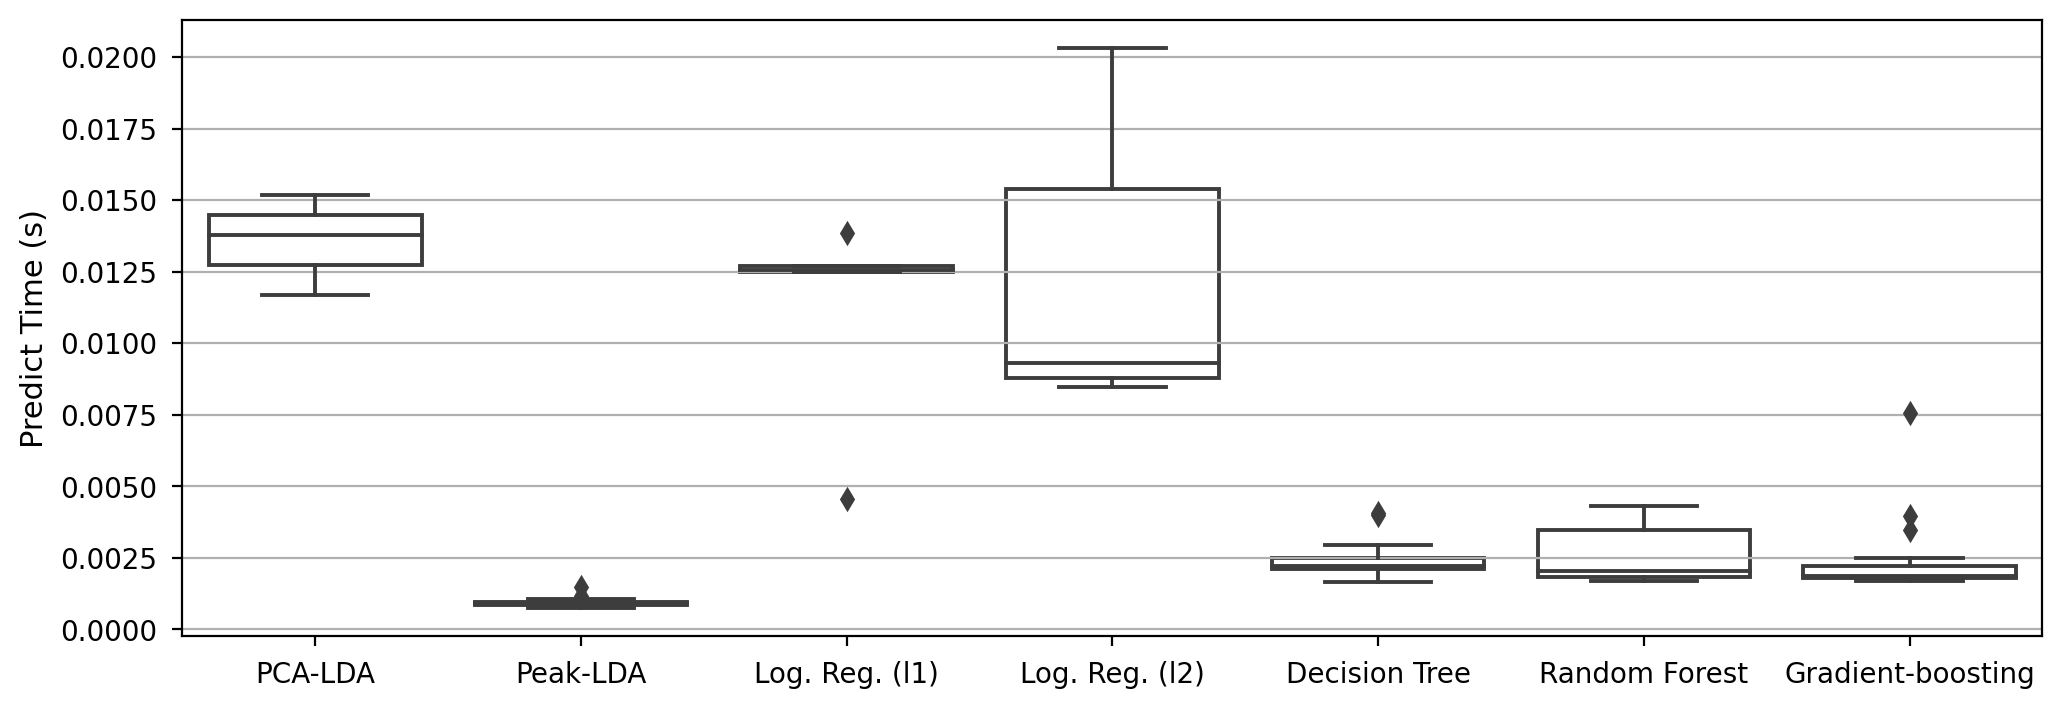

In [129]:
fig, ax = plt.subplots(figsize=(12,4))
boxplot_comparison(predict_times, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")
ax.grid(axis="y")
ax.set_ylabel("Predict Time (s)")

fig.savefig(img_path / "all_predicttime.png", format="png", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


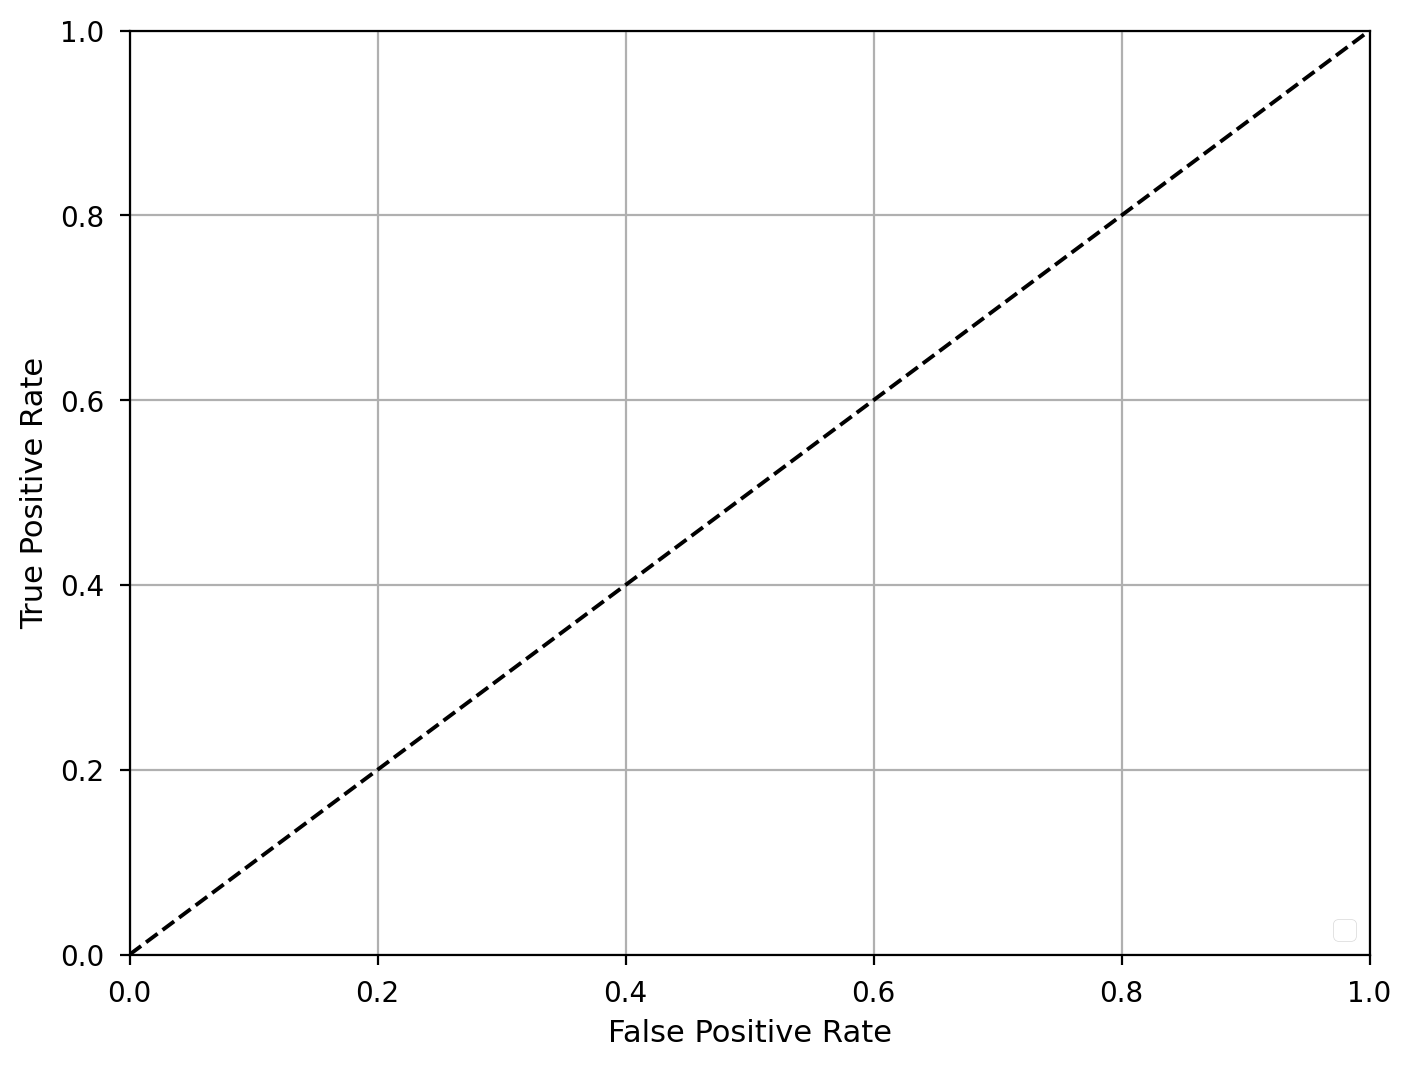

In [130]:
fig, ax = plt.subplots()
plot_roc_comparison(rocs, aucs, ax=ax, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")

ax.grid()
ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

fig.savefig(img_path / "all_roc.png", format="png", bbox_inches="tight")